## Setup

In [10]:
import torch
import torch.nn as nn
import numpy as np
!pip install matplotlib seaborn
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import torchani
from torchani.data import TransformableIterable
import pandas as pd
!pip install seaborn
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


  Using cached matplotlib-3.7.5-cp38-cp38-macosx_10_12_x86_64.whl.metadata (5.7 kB)
Using cached matplotlib-3.7.5-cp38-cp38-macosx_10_12_x86_64.whl (7.4 MB)


In [14]:
def init_aev_computer():
    Rcr = 5.2
    Rca = 3.5
    EtaR = torch.tensor([16], dtype=torch.float, device=device)
    ShfR = torch.tensor([
        0.900000, 1.168750, 1.437500, 1.706250,
        1.975000, 2.243750, 2.512500, 2.781250,
        3.050000, 3.318750, 3.587500, 3.856250,
        4.125000, 4.393750, 4.662500, 4.931250
    ], dtype=torch.float, device=device)
    EtaA = torch.tensor([8], dtype=torch.float, device=device)
    Zeta = torch.tensor([32], dtype=torch.float, device=device)
    ShfA = torch.tensor([0.90, 1.55, 2.20, 2.85], dtype=torch.float, device=device)
    ShfZ = torch.tensor([
        0.19634954, 0.58904862, 0.9817477, 1.37444680,
        1.76714590, 2.15984490, 2.5525440, 2.94524300
    ], dtype=torch.float, device=device)
    return torchani.AEVComputer(Rcr, Rca, EtaR, ShfR, EtaA, Zeta, ShfA, ShfZ, num_species=4)

aev_computer = init_aev_computer()

In [15]:
class AtomicNet(nn.Module):
    def __init__(self, dropout_rate=None):
        super().__init__()
        layers = [
            nn.Linear(384, 256), nn.ReLU(),
            nn.Dropout(dropout_rate) if dropout_rate else nn.Identity(),
            nn.Linear(256, 192), nn.ReLU(),
            nn.Dropout(dropout_rate) if dropout_rate else nn.Identity(),
            nn.Linear(192, 128), nn.ReLU(),
            nn.Dropout(dropout_rate) if dropout_rate else nn.Identity(),
            nn.Linear(128, 64), nn.ReLU(),
            nn.Dropout(dropout_rate) if dropout_rate else nn.Identity(),
            nn.Linear(64, 1)
        ]
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)


In [16]:
def load_ani_dataset(dspath): 
    energy_shifter = torchani.utils.EnergyShifter(None)
    species_order = ['H', 'C', 'N', 'O']
    dataset = torchani.data.load(dspath)
    dataset = dataset.subtract_self_energies(energy_shifter, species_order)
    dataset = dataset.species_to_indices(species_order)
    dataset = dataset.shuffle()
    return dataset

dataset = load_ani_dataset("./ani_gdb_s01_to_s04.h5")
train_data, val_data, test_data = dataset.split(0.8, 0.1, 0.1)


In [17]:
def get_data_subset(dataset, size):
    dataset = list(dataset)
    if size == 'small':
        return TransformableIterable(dataset[:5000])
    elif size == 'large':
        return TransformableIterable(dataset[:20000])
    else:
        return TransformableIterable(dataset)

train_subset = get_data_subset(train_data, 'small')
val_subset = get_data_subset(val_data, 'small')


In [18]:
def build_model(dropout, l2, device):
    nets = [AtomicNet(dropout).to(device) for _ in range(4)]
    ani_model = torchani.ANIModel(nets)
    return nn.Sequential(aev_computer, ani_model).to(device)


In [19]:
class ANITrainer:
    def __init__(self, model, batch_size=512, learning_rate=1e-3, epoch=100, l2=0.0):
        self.model = model
        self.batch_size = batch_size
        self.optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2)
        self.epoch = epoch

    def train(self, train_data, val_data, early_stop=True, draw_curve=True):
        self.model.train()
        train_loader = train_data.collate(self.batch_size).cache()
        loss_func = nn.MSELoss()
        train_loss_list = []
        val_loss_list = []
        val_rmse_list = []
        best_model = None
        lowest_val_loss = float('inf')

        for ep in tqdm(range(self.epoch), desc="Epochs"):
            total_train_loss = 0.0
            for batch in train_loader:
                species = batch['species'].to(device)
                coords = batch['coordinates'].to(device)
                energies = batch['energies'].to(device).float()

                _, pred = self.model((species, coords))
                loss = loss_func(energies, pred)

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                total_train_loss += loss.item()

            val_loss, val_rmse = self.evaluate(val_data)
            train_loss_list.append(total_train_loss)
            val_loss_list.append(val_loss)
            val_rmse_list.append(val_rmse)

            print(f"Epoch {ep+1} - Train Loss: {total_train_loss:.4f}, Val Loss: {val_loss:.4f}, RMSE: {val_rmse:.2f} kcal/mol")

            if early_stop and val_loss < lowest_val_loss:
                lowest_val_loss = val_loss
                best_model = self.model.state_dict()

        if draw_curve:
            fig, ax1 = plt.subplots()
            ax1.plot(train_loss_list, label="Train Loss")
            ax1.plot(val_loss_list, label="Val Loss")
            ax1.set_yscale("log")
            ax1.set_xlabel("Epoch")
            ax1.set_ylabel("MSE Loss")

            ax2 = ax1.twinx()
            ax2.plot(val_rmse_list, 'r--', label="Val RMSE")
            ax2.set_ylabel("RMSE (kcal/mol)", color='red')

            fig.legend(loc='upper right')
            plt.title("Training Curve")
            plt.show()

        if early_stop and best_model:
            self.model.load_state_dict(best_model)

        return train_loss_list, val_loss_list, val_rmse_list

    def evaluate(self, data, draw_plot=False):
        data_loader = data.collate(self.batch_size).cache()
        loss_func = nn.MSELoss()
        total_loss = 0.0
        true_all, pred_all = [], []

        self.model.eval()
        with torch.no_grad():
            for batch in data_loader:
                species = batch['species'].to(device)
                coords = batch['coordinates'].to(device)
                true = batch['energies'].to(device).float()
                _, pred = self.model((species, coords))

                total_loss += loss_func(true, pred).item()
                true_all.append(true.cpu().numpy())
                pred_all.append(pred.cpu().numpy())

        true_all = np.concatenate(true_all).flatten()
        pred_all = np.concatenate(pred_all).flatten()
        rmse = np.sqrt(np.mean((true_all - pred_all) ** 2)) * 627.509

        if draw_plot:
            plt.scatter(true_all, pred_all, s=2)
            plt.plot([true_all.min(), true_all.max()], [true_all.min(), true_all.max()], 'r--')
            plt.xlabel("True Energy")
            plt.ylabel("Predicted Energy")
            plt.title(f"Validation RMSE: {rmse:.2f} kcal/mol")
            plt.show()

        return total_loss, rmse


In [14]:
results = []
dropout_list = [None, 0.1, 0.2, 0.3]
l2_list = [0.0, 1e-5, 1e-4]

for dropout in dropout_list:
    for l2 in l2_list:
        print(f"\nTraining model with dropout={dropout}, L2={l2}")
        model = build_model(dropout, l2, device)
        trainer = ANITrainer(model, epoch=30, l2=l2)
        _, _, val_rmse_list = trainer.train(train_subset, val_subset, early_stop=True, draw_curve=True)
        final_rmse = val_rmse_list[-1]
        results.append({'dropout': dropout if dropout else 0.0, 'l2': l2, 'val_rmse': final_rmse})


Training model with dropout=None, L2=0.0


Epochs:   3%|█▏                                  | 1/30 [00:06<03:15,  6.73s/it]

Epoch 1 - Train Loss: 0.1207, Val Loss: 0.0503, RMSE: 44.56 kcal/mol


Epochs:   7%|██▍                                 | 2/30 [00:12<02:54,  6.24s/it]

Epoch 2 - Train Loss: 0.0299, Val Loss: 0.0203, RMSE: 28.36 kcal/mol


Epochs:  10%|███▌                                | 3/30 [00:21<03:26,  7.65s/it]

Epoch 3 - Train Loss: 0.0145, Val Loss: 0.0125, RMSE: 22.24 kcal/mol


Epochs:  13%|████▊                               | 4/30 [00:35<04:20, 10.02s/it]

Epoch 4 - Train Loss: 0.0100, Val Loss: 0.0097, RMSE: 19.60 kcal/mol


Epochs:  17%|██████                              | 5/30 [00:48<04:35, 11.00s/it]

Epoch 5 - Train Loss: 0.0074, Val Loss: 0.0072, RMSE: 16.94 kcal/mol


Epochs:  20%|███████▏                            | 6/30 [00:55<03:55,  9.82s/it]

Epoch 6 - Train Loss: 0.0052, Val Loss: 0.0052, RMSE: 14.37 kcal/mol


Epochs:  23%|████████▍                           | 7/30 [01:01<03:14,  8.45s/it]

Epoch 7 - Train Loss: 0.0037, Val Loss: 0.0039, RMSE: 12.38 kcal/mol


Epochs:  27%|█████████▌                          | 8/30 [01:06<02:43,  7.42s/it]

Epoch 8 - Train Loss: 0.0027, Val Loss: 0.0029, RMSE: 10.74 kcal/mol


Epochs:  30%|██████████▊                         | 9/30 [01:12<02:22,  6.77s/it]

Epoch 9 - Train Loss: 0.0021, Val Loss: 0.0023, RMSE: 9.63 kcal/mol


Epochs:  33%|███████████▋                       | 10/30 [01:17<02:07,  6.36s/it]

Epoch 10 - Train Loss: 0.0017, Val Loss: 0.0019, RMSE: 8.77 kcal/mol


Epochs:  37%|████████████▊                      | 11/30 [01:24<02:04,  6.58s/it]

Epoch 11 - Train Loss: 0.0014, Val Loss: 0.0016, RMSE: 8.00 kcal/mol


Epochs:  40%|██████████████                     | 12/30 [01:30<01:54,  6.39s/it]

Epoch 12 - Train Loss: 0.0011, Val Loss: 0.0013, RMSE: 7.18 kcal/mol


Epochs:  40%|██████████████                     | 12/30 [01:33<02:20,  7.82s/it]


KeyboardInterrupt: 

In [15]:
results = []
dropout_list = [None, 0.1, 0.2, 0.3]
l2_list = [0.0, 1e-5, 1e-4]

num_rows = len(dropout_list)
num_cols = len(l2_list)
fig_loss, axes_loss = plt.subplots(num_rows, num_cols, figsize=(15, 10), sharex=True, sharey=True)
fig_rmse, axes_rmse = plt.subplots(num_rows, num_cols, figsize=(15, 10), sharex=True, sharey=True)

for i, dropout in enumerate(dropout_list):
    for j, l2 in enumerate(l2_list):
        print(f"\nTraining model with dropout={dropout}, L2={l2}")
        model = build_model(dropout, l2, device)
        trainer = ANITrainer(model, epoch=30, l2=l2)
        train_losses, val_losses, val_rmses = trainer.train(
            train_subset, val_subset, early_stop=True, draw_curve=False
        )

        final_rmse = val_rmses[-1]
        results.append({'dropout': dropout if dropout else 0.0, 'l2': l2, 'val_rmse': final_rmse})

        # Plot losses
        ax_loss = axes_loss[i][j]
        ax_loss.plot(train_losses, label='Train Loss')
        ax_loss.plot(val_losses, label='Val Loss')
        ax_loss.set_yscale('log')
        ax_loss.set_title(f"dropout={dropout}, L2={l2}")
        ax_loss.legend()

        # Plot RMSE
        ax_rmse = axes_rmse[i][j]
        ax_rmse.plot(val_rmses, color='red', label='Val RMSE')
        ax_rmse.set_title(f"dropout={dropout}, L2={l2}")
        ax_rmse.set_ylabel("RMSE (kcal/mol)")
        ax_rmse.set_xlabel("Epoch")
        ax_rmse.legend()

fig_loss.suptitle("Train & Validation Loss Curves", fontsize=16)
fig_rmse.suptitle("Validation RMSE Curves", fontsize=16)
fig_loss.tight_layout(rect=[0, 0, 1, 0.97])
fig_rmse.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()



Training model with dropout=None, L2=0.0


Epochs:   3%|█▏                                  | 1/30 [00:06<03:02,  6.30s/it]

Epoch 1 - Train Loss: 0.3069, Val Loss: 0.0773, RMSE: 55.24 kcal/mol


Epochs:   7%|██▍                                 | 2/30 [00:10<02:29,  5.34s/it]

Epoch 2 - Train Loss: 0.0530, Val Loss: 0.0386, RMSE: 39.08 kcal/mol


Epochs:  10%|███▌                                | 3/30 [00:15<02:17,  5.08s/it]

Epoch 3 - Train Loss: 0.0262, Val Loss: 0.0176, RMSE: 26.37 kcal/mol


Epochs:  13%|████▊                               | 4/30 [00:21<02:14,  5.19s/it]

Epoch 4 - Train Loss: 0.0148, Val Loss: 0.0138, RMSE: 23.45 kcal/mol


Epochs:  17%|██████                              | 5/30 [00:26<02:11,  5.27s/it]

Epoch 5 - Train Loss: 0.0112, Val Loss: 0.0109, RMSE: 20.85 kcal/mol


Epochs:  20%|███████▏                            | 6/30 [00:32<02:12,  5.53s/it]

Epoch 6 - Train Loss: 0.0091, Val Loss: 0.0090, RMSE: 18.92 kcal/mol


Epochs:  23%|████████▍                           | 7/30 [00:37<02:06,  5.49s/it]

Epoch 7 - Train Loss: 0.0074, Val Loss: 0.0074, RMSE: 17.19 kcal/mol


Epochs:  27%|█████████▌                          | 8/30 [00:47<02:31,  6.91s/it]

Epoch 8 - Train Loss: 0.0056, Val Loss: 0.0059, RMSE: 15.32 kcal/mol


Epochs:  30%|██████████▊                         | 9/30 [00:55<02:29,  7.10s/it]

Epoch 9 - Train Loss: 0.0043, Val Loss: 0.0048, RMSE: 13.85 kcal/mol


Epochs:  33%|███████████▋                       | 10/30 [01:03<02:29,  7.47s/it]

Epoch 10 - Train Loss: 0.0033, Val Loss: 0.0039, RMSE: 12.43 kcal/mol


Epochs:  37%|████████████▊                      | 11/30 [01:10<02:20,  7.41s/it]

Epoch 11 - Train Loss: 0.0026, Val Loss: 0.0032, RMSE: 11.26 kcal/mol


Epochs:  40%|██████████████                     | 12/30 [01:19<02:19,  7.73s/it]

Epoch 12 - Train Loss: 0.0021, Val Loss: 0.0027, RMSE: 10.38 kcal/mol


Epochs:  43%|███████████████▏                   | 13/30 [01:28<02:17,  8.10s/it]

Epoch 13 - Train Loss: 0.0018, Val Loss: 0.0023, RMSE: 9.67 kcal/mol


Epochs:  47%|████████████████▎                  | 14/30 [01:35<02:07,  7.95s/it]

Epoch 14 - Train Loss: 0.0015, Val Loss: 0.0020, RMSE: 9.01 kcal/mol


Epochs:  50%|█████████████████▌                 | 15/30 [01:43<01:57,  7.85s/it]

Epoch 15 - Train Loss: 0.0013, Val Loss: 0.0018, RMSE: 8.46 kcal/mol


Epochs:  53%|██████████████████▋                | 16/30 [01:50<01:47,  7.65s/it]

Epoch 16 - Train Loss: 0.0012, Val Loss: 0.0016, RMSE: 7.90 kcal/mol


Epochs:  57%|███████████████████▊               | 17/30 [01:58<01:38,  7.56s/it]

Epoch 17 - Train Loss: 0.0010, Val Loss: 0.0014, RMSE: 7.56 kcal/mol


Epochs:  60%|█████████████████████              | 18/30 [02:04<01:27,  7.31s/it]

Epoch 18 - Train Loss: 0.0008, Val Loss: 0.0013, RMSE: 7.12 kcal/mol


Epochs:  63%|██████████████████████▏            | 19/30 [02:12<01:20,  7.34s/it]

Epoch 19 - Train Loss: 0.0007, Val Loss: 0.0011, RMSE: 6.75 kcal/mol


Epochs:  67%|███████████████████████▎           | 20/30 [02:19<01:14,  7.43s/it]

Epoch 20 - Train Loss: 0.0007, Val Loss: 0.0010, RMSE: 6.44 kcal/mol


Epochs:  70%|████████████████████████▌          | 21/30 [02:27<01:07,  7.51s/it]

Epoch 21 - Train Loss: 0.0006, Val Loss: 0.0010, RMSE: 6.35 kcal/mol


Epochs:  73%|█████████████████████████▋         | 22/30 [02:36<01:02,  7.81s/it]

Epoch 22 - Train Loss: 0.0005, Val Loss: 0.0009, RMSE: 5.96 kcal/mol


Epochs:  77%|██████████████████████████▊        | 23/30 [02:43<00:53,  7.70s/it]

Epoch 23 - Train Loss: 0.0005, Val Loss: 0.0009, RMSE: 5.83 kcal/mol


Epochs:  80%|████████████████████████████       | 24/30 [02:51<00:46,  7.73s/it]

Epoch 24 - Train Loss: 0.0005, Val Loss: 0.0008, RMSE: 5.79 kcal/mol


Epochs:  83%|█████████████████████████████▏     | 25/30 [02:59<00:39,  7.99s/it]

Epoch 25 - Train Loss: 0.0004, Val Loss: 0.0008, RMSE: 5.73 kcal/mol


Epochs:  87%|██████████████████████████████▎    | 26/30 [03:07<00:31,  7.97s/it]

Epoch 26 - Train Loss: 0.0004, Val Loss: 0.0008, RMSE: 5.65 kcal/mol


Epochs:  90%|███████████████████████████████▌   | 27/30 [03:16<00:24,  8.26s/it]

Epoch 27 - Train Loss: 0.0004, Val Loss: 0.0007, RMSE: 5.44 kcal/mol


Epochs:  93%|████████████████████████████████▋  | 28/30 [03:24<00:15,  7.94s/it]

Epoch 28 - Train Loss: 0.0004, Val Loss: 0.0007, RMSE: 5.24 kcal/mol


Epochs:  97%|█████████████████████████████████▊ | 29/30 [03:33<00:08,  8.30s/it]

Epoch 29 - Train Loss: 0.0004, Val Loss: 0.0008, RMSE: 5.51 kcal/mol


Epochs: 100%|███████████████████████████████████| 30/30 [03:40<00:00,  7.33s/it]

Epoch 30 - Train Loss: 0.0004, Val Loss: 0.0009, RMSE: 6.04 kcal/mol

Training model with dropout=None, L2=1e-05



Epochs:   3%|█▏                                  | 1/30 [00:08<03:55,  8.12s/it]

Epoch 1 - Train Loss: 0.9701, Val Loss: 0.0678, RMSE: 51.75 kcal/mol


Epochs:   7%|██▍                                 | 2/30 [00:18<04:22,  9.37s/it]

Epoch 2 - Train Loss: 0.0988, Val Loss: 0.0449, RMSE: 42.12 kcal/mol


Epochs:  10%|███▌                                | 3/30 [00:26<03:54,  8.68s/it]

Epoch 3 - Train Loss: 0.0441, Val Loss: 0.0319, RMSE: 35.56 kcal/mol


Epochs:  13%|████▊                               | 4/30 [00:35<03:52,  8.93s/it]

Epoch 4 - Train Loss: 0.0289, Val Loss: 0.0259, RMSE: 32.02 kcal/mol


Epochs:  17%|██████                              | 5/30 [00:43<03:38,  8.75s/it]

Epoch 5 - Train Loss: 0.0209, Val Loss: 0.0197, RMSE: 27.98 kcal/mol


Epochs:  20%|███████▏                            | 6/30 [00:51<03:19,  8.32s/it]

Epoch 6 - Train Loss: 0.0171, Val Loss: 0.0165, RMSE: 25.65 kcal/mol


Epochs:  23%|████████▍                           | 7/30 [00:58<03:02,  7.94s/it]

Epoch 7 - Train Loss: 0.0142, Val Loss: 0.0138, RMSE: 23.45 kcal/mol


Epochs:  27%|█████████▌                          | 8/30 [01:05<02:48,  7.68s/it]

Epoch 8 - Train Loss: 0.0115, Val Loss: 0.0107, RMSE: 20.63 kcal/mol


Epochs:  30%|██████████▊                         | 9/30 [01:14<02:45,  7.89s/it]

Epoch 9 - Train Loss: 0.0083, Val Loss: 0.0072, RMSE: 16.93 kcal/mol


Epochs:  33%|███████████▋                       | 10/30 [01:22<02:40,  8.01s/it]

Epoch 10 - Train Loss: 0.0054, Val Loss: 0.0049, RMSE: 13.89 kcal/mol


Epochs:  37%|████████████▊                      | 11/30 [01:30<02:34,  8.11s/it]

Epoch 11 - Train Loss: 0.0038, Val Loss: 0.0037, RMSE: 12.12 kcal/mol


Epochs:  40%|██████████████                     | 12/30 [01:38<02:23,  7.98s/it]

Epoch 12 - Train Loss: 0.0029, Val Loss: 0.0031, RMSE: 11.13 kcal/mol


Epochs:  43%|███████████████▏                   | 13/30 [01:45<02:11,  7.73s/it]

Epoch 13 - Train Loss: 0.0024, Val Loss: 0.0026, RMSE: 10.20 kcal/mol


Epochs:  47%|████████████████▎                  | 14/30 [01:54<02:09,  8.08s/it]

Epoch 14 - Train Loss: 0.0019, Val Loss: 0.0022, RMSE: 9.28 kcal/mol


Epochs:  50%|█████████████████▌                 | 15/30 [02:02<01:58,  7.92s/it]

Epoch 15 - Train Loss: 0.0017, Val Loss: 0.0020, RMSE: 8.79 kcal/mol


Epochs:  53%|██████████████████▋                | 16/30 [02:11<01:56,  8.33s/it]

Epoch 16 - Train Loss: 0.0015, Val Loss: 0.0018, RMSE: 8.41 kcal/mol


Epochs:  57%|███████████████████▊               | 17/30 [02:19<01:45,  8.15s/it]

Epoch 17 - Train Loss: 0.0014, Val Loss: 0.0016, RMSE: 7.92 kcal/mol


Epochs:  60%|█████████████████████              | 18/30 [02:27<01:38,  8.18s/it]

Epoch 18 - Train Loss: 0.0012, Val Loss: 0.0015, RMSE: 7.59 kcal/mol


Epochs:  63%|██████████████████████▏            | 19/30 [02:35<01:29,  8.17s/it]

Epoch 19 - Train Loss: 0.0011, Val Loss: 0.0014, RMSE: 7.35 kcal/mol


Epochs:  67%|███████████████████████▎           | 20/30 [02:42<01:18,  7.86s/it]

Epoch 20 - Train Loss: 0.0010, Val Loss: 0.0013, RMSE: 7.08 kcal/mol


Epochs:  70%|████████████████████████▌          | 21/30 [02:50<01:12,  8.01s/it]

Epoch 21 - Train Loss: 0.0009, Val Loss: 0.0012, RMSE: 6.89 kcal/mol


Epochs:  73%|█████████████████████████▋         | 22/30 [02:58<01:04,  8.02s/it]

Epoch 22 - Train Loss: 0.0009, Val Loss: 0.0012, RMSE: 6.86 kcal/mol


Epochs:  77%|██████████████████████████▊        | 23/30 [03:08<00:58,  8.37s/it]

Epoch 23 - Train Loss: 0.0008, Val Loss: 0.0012, RMSE: 6.96 kcal/mol


Epochs:  80%|████████████████████████████       | 24/30 [03:19<00:55,  9.31s/it]

Epoch 24 - Train Loss: 0.0008, Val Loss: 0.0011, RMSE: 6.74 kcal/mol


Epochs:  83%|█████████████████████████████▏     | 25/30 [03:26<00:43,  8.63s/it]

Epoch 25 - Train Loss: 0.0007, Val Loss: 0.0012, RMSE: 6.92 kcal/mol


Epochs:  87%|██████████████████████████████▎    | 26/30 [03:33<00:32,  8.20s/it]

Epoch 26 - Train Loss: 0.0007, Val Loss: 0.0011, RMSE: 6.57 kcal/mol


Epochs:  90%|███████████████████████████████▌   | 27/30 [03:40<00:23,  7.87s/it]

Epoch 27 - Train Loss: 0.0007, Val Loss: 0.0011, RMSE: 6.58 kcal/mol


Epochs:  93%|████████████████████████████████▋  | 28/30 [03:47<00:15,  7.61s/it]

Epoch 28 - Train Loss: 0.0007, Val Loss: 0.0011, RMSE: 6.70 kcal/mol


Epochs:  97%|█████████████████████████████████▊ | 29/30 [03:55<00:07,  7.64s/it]

Epoch 29 - Train Loss: 0.0007, Val Loss: 0.0010, RMSE: 6.44 kcal/mol


Epochs: 100%|███████████████████████████████████| 30/30 [04:03<00:00,  8.11s/it]

Epoch 30 - Train Loss: 0.0006, Val Loss: 0.0010, RMSE: 6.28 kcal/mol

Training model with dropout=None, L2=0.0001



Epochs:   3%|█▏                                  | 1/30 [00:06<03:16,  6.79s/it]

Epoch 1 - Train Loss: 0.2930, Val Loss: 0.1206, RMSE: 69.01 kcal/mol


Epochs:   7%|██▍                                 | 2/30 [00:15<03:38,  7.81s/it]

Epoch 2 - Train Loss: 0.0604, Val Loss: 0.0372, RMSE: 38.38 kcal/mol


Epochs:  10%|███▌                                | 3/30 [00:23<03:40,  8.18s/it]

Epoch 3 - Train Loss: 0.0273, Val Loss: 0.0242, RMSE: 30.94 kcal/mol


Epochs:  13%|████▊                               | 4/30 [00:33<03:49,  8.82s/it]

Epoch 4 - Train Loss: 0.0214, Val Loss: 0.0194, RMSE: 27.75 kcal/mol


Epochs:  17%|██████                              | 5/30 [00:44<03:54,  9.37s/it]

Epoch 5 - Train Loss: 0.0169, Val Loss: 0.0165, RMSE: 25.60 kcal/mol


Epochs:  20%|███████▏                            | 6/30 [00:51<03:25,  8.55s/it]

Epoch 6 - Train Loss: 0.0139, Val Loss: 0.0132, RMSE: 22.93 kcal/mol


Epochs:  23%|████████▍                           | 7/30 [00:59<03:17,  8.60s/it]

Epoch 7 - Train Loss: 0.0105, Val Loss: 0.0095, RMSE: 19.42 kcal/mol


Epochs:  27%|█████████▌                          | 8/30 [01:08<03:09,  8.62s/it]

Epoch 8 - Train Loss: 0.0076, Val Loss: 0.0071, RMSE: 16.78 kcal/mol


Epochs:  30%|██████████▊                         | 9/30 [01:18<03:08,  8.98s/it]

Epoch 9 - Train Loss: 0.0058, Val Loss: 0.0056, RMSE: 14.94 kcal/mol


Epochs:  33%|███████████▋                       | 10/30 [01:26<02:52,  8.64s/it]

Epoch 10 - Train Loss: 0.0045, Val Loss: 0.0047, RMSE: 13.69 kcal/mol


Epochs:  37%|████████████▊                      | 11/30 [01:33<02:35,  8.19s/it]

Epoch 11 - Train Loss: 0.0040, Val Loss: 0.0046, RMSE: 13.54 kcal/mol


Epochs:  40%|██████████████                     | 12/30 [01:40<02:22,  7.94s/it]

Epoch 12 - Train Loss: 0.0034, Val Loss: 0.0037, RMSE: 12.14 kcal/mol


Epochs:  43%|███████████████▏                   | 13/30 [01:52<02:34,  9.09s/it]

Epoch 13 - Train Loss: 0.0031, Val Loss: 0.0042, RMSE: 12.92 kcal/mol


Epochs:  47%|████████████████▎                  | 14/30 [02:11<03:15, 12.23s/it]

Epoch 14 - Train Loss: 0.0030, Val Loss: 0.0033, RMSE: 11.36 kcal/mol


Epochs:  50%|█████████████████▌                 | 15/30 [02:23<03:00, 12.06s/it]

Epoch 15 - Train Loss: 0.0027, Val Loss: 0.0029, RMSE: 10.80 kcal/mol


Epochs:  53%|██████████████████▋                | 16/30 [02:34<02:45, 11.84s/it]

Epoch 16 - Train Loss: 0.0025, Val Loss: 0.0032, RMSE: 11.18 kcal/mol


Epochs:  57%|███████████████████▊               | 17/30 [02:44<02:25, 11.21s/it]

Epoch 17 - Train Loss: 0.0025, Val Loss: 0.0031, RMSE: 11.09 kcal/mol


Epochs:  60%|█████████████████████              | 18/30 [02:53<02:05, 10.47s/it]

Epoch 18 - Train Loss: 0.0025, Val Loss: 0.0037, RMSE: 12.02 kcal/mol


Epochs:  63%|██████████████████████▏            | 19/30 [03:02<01:49,  9.96s/it]

Epoch 19 - Train Loss: 0.0026, Val Loss: 0.0027, RMSE: 10.27 kcal/mol


Epochs:  67%|███████████████████████▎           | 20/30 [03:09<01:33,  9.32s/it]

Epoch 20 - Train Loss: 0.0023, Val Loss: 0.0025, RMSE: 9.88 kcal/mol


Epochs:  70%|████████████████████████▌          | 21/30 [03:17<01:19,  8.79s/it]

Epoch 21 - Train Loss: 0.0021, Val Loss: 0.0030, RMSE: 10.96 kcal/mol


Epochs:  73%|█████████████████████████▋         | 22/30 [03:26<01:11,  8.95s/it]

Epoch 22 - Train Loss: 0.0023, Val Loss: 0.0027, RMSE: 10.30 kcal/mol


Epochs:  77%|██████████████████████████▊        | 23/30 [03:34<01:00,  8.57s/it]

Epoch 23 - Train Loss: 0.0021, Val Loss: 0.0023, RMSE: 9.56 kcal/mol


Epochs:  80%|████████████████████████████       | 24/30 [03:43<00:52,  8.79s/it]

Epoch 24 - Train Loss: 0.0020, Val Loss: 0.0025, RMSE: 9.85 kcal/mol


Epochs:  83%|█████████████████████████████▏     | 25/30 [03:52<00:44,  8.87s/it]

Epoch 25 - Train Loss: 0.0020, Val Loss: 0.0036, RMSE: 11.97 kcal/mol


Epochs:  87%|██████████████████████████████▎    | 26/30 [04:00<00:33,  8.44s/it]

Epoch 26 - Train Loss: 0.0026, Val Loss: 0.0025, RMSE: 10.01 kcal/mol


Epochs:  90%|███████████████████████████████▌   | 27/30 [04:07<00:24,  8.20s/it]

Epoch 27 - Train Loss: 0.0021, Val Loss: 0.0022, RMSE: 9.29 kcal/mol


Epochs:  93%|████████████████████████████████▋  | 28/30 [04:19<00:18,  9.14s/it]

Epoch 28 - Train Loss: 0.0019, Val Loss: 0.0027, RMSE: 10.28 kcal/mol


Epochs:  97%|█████████████████████████████████▊ | 29/30 [04:32<00:10, 10.44s/it]

Epoch 29 - Train Loss: 0.0020, Val Loss: 0.0029, RMSE: 10.76 kcal/mol


Epochs: 100%|███████████████████████████████████| 30/30 [04:41<00:00,  9.37s/it]

Epoch 30 - Train Loss: 0.0021, Val Loss: 0.0023, RMSE: 9.43 kcal/mol

Training model with dropout=0.1, L2=0.0



Epochs:   3%|█▏                                  | 1/30 [00:10<05:12, 10.76s/it]

Epoch 1 - Train Loss: 1.2534, Val Loss: 0.0263, RMSE: 32.30 kcal/mol


Epochs:   7%|██▍                                 | 2/30 [00:18<04:14,  9.10s/it]

Epoch 2 - Train Loss: 0.0961, Val Loss: 0.0218, RMSE: 29.40 kcal/mol


Epochs:  10%|███▌                                | 3/30 [00:31<04:56, 11.00s/it]

Epoch 3 - Train Loss: 0.0394, Val Loss: 0.0212, RMSE: 29.01 kcal/mol


Epochs:  13%|████▊                               | 4/30 [00:39<04:07,  9.51s/it]

Epoch 4 - Train Loss: 0.0251, Val Loss: 0.0205, RMSE: 28.52 kcal/mol


Epochs:  17%|██████                              | 5/30 [00:47<03:43,  8.93s/it]

Epoch 5 - Train Loss: 0.0189, Val Loss: 0.0184, RMSE: 27.05 kcal/mol


Epochs:  20%|███████▏                            | 6/30 [00:53<03:09,  7.91s/it]

Epoch 6 - Train Loss: 0.0164, Val Loss: 0.0158, RMSE: 25.01 kcal/mol


Epochs:  23%|████████▍                           | 7/30 [00:59<02:47,  7.30s/it]

Epoch 7 - Train Loss: 0.0138, Val Loss: 0.0139, RMSE: 23.52 kcal/mol


Epochs:  27%|█████████▌                          | 8/30 [01:04<02:30,  6.84s/it]

Epoch 8 - Train Loss: 0.0118, Val Loss: 0.0119, RMSE: 21.75 kcal/mol


Epochs:  30%|██████████▊                         | 9/30 [01:10<02:14,  6.43s/it]

Epoch 9 - Train Loss: 0.0100, Val Loss: 0.0101, RMSE: 19.99 kcal/mol


Epochs:  33%|███████████▋                       | 10/30 [01:15<02:02,  6.13s/it]

Epoch 10 - Train Loss: 0.0083, Val Loss: 0.0083, RMSE: 18.16 kcal/mol


Epochs:  37%|████████████▊                      | 11/30 [01:21<01:53,  5.97s/it]

Epoch 11 - Train Loss: 0.0067, Val Loss: 0.0067, RMSE: 16.31 kcal/mol


Epochs:  40%|██████████████                     | 12/30 [01:28<01:52,  6.25s/it]

Epoch 12 - Train Loss: 0.0053, Val Loss: 0.0054, RMSE: 14.58 kcal/mol


Epochs:  43%|███████████████▏                   | 13/30 [01:35<01:50,  6.51s/it]

Epoch 13 - Train Loss: 0.0041, Val Loss: 0.0043, RMSE: 12.99 kcal/mol


Epochs:  47%|████████████████▎                  | 14/30 [01:45<02:01,  7.62s/it]

Epoch 14 - Train Loss: 0.0033, Val Loss: 0.0035, RMSE: 11.82 kcal/mol


Epochs:  50%|█████████████████▌                 | 15/30 [01:52<01:49,  7.29s/it]

Epoch 15 - Train Loss: 0.0027, Val Loss: 0.0030, RMSE: 10.94 kcal/mol


Epochs:  53%|██████████████████▋                | 16/30 [02:01<01:51,  7.99s/it]

Epoch 16 - Train Loss: 0.0022, Val Loss: 0.0026, RMSE: 10.05 kcal/mol


Epochs:  57%|███████████████████▊               | 17/30 [02:08<01:36,  7.46s/it]

Epoch 17 - Train Loss: 0.0019, Val Loss: 0.0022, RMSE: 9.31 kcal/mol


Epochs:  60%|█████████████████████              | 18/30 [02:13<01:21,  6.81s/it]

Epoch 18 - Train Loss: 0.0017, Val Loss: 0.0019, RMSE: 8.75 kcal/mol


Epochs:  63%|██████████████████████▏            | 19/30 [02:19<01:11,  6.47s/it]

Epoch 19 - Train Loss: 0.0015, Val Loss: 0.0017, RMSE: 8.26 kcal/mol


Epochs:  67%|███████████████████████▎           | 20/30 [02:24<01:01,  6.18s/it]

Epoch 20 - Train Loss: 0.0013, Val Loss: 0.0015, RMSE: 7.81 kcal/mol


Epochs:  70%|████████████████████████▌          | 21/30 [02:31<00:56,  6.31s/it]

Epoch 21 - Train Loss: 0.0011, Val Loss: 0.0014, RMSE: 7.44 kcal/mol


Epochs:  73%|█████████████████████████▋         | 22/30 [02:39<00:54,  6.84s/it]

Epoch 22 - Train Loss: 0.0010, Val Loss: 0.0013, RMSE: 7.13 kcal/mol


Epochs:  77%|██████████████████████████▊        | 23/30 [02:46<00:48,  6.96s/it]

Epoch 23 - Train Loss: 0.0009, Val Loss: 0.0012, RMSE: 6.86 kcal/mol


Epochs:  80%|████████████████████████████       | 24/30 [02:53<00:41,  6.85s/it]

Epoch 24 - Train Loss: 0.0009, Val Loss: 0.0011, RMSE: 6.61 kcal/mol


Epochs:  83%|█████████████████████████████▏     | 25/30 [02:59<00:33,  6.68s/it]

Epoch 25 - Train Loss: 0.0008, Val Loss: 0.0010, RMSE: 6.38 kcal/mol


Epochs:  87%|██████████████████████████████▎    | 26/30 [03:05<00:26,  6.63s/it]

Epoch 26 - Train Loss: 0.0007, Val Loss: 0.0010, RMSE: 6.19 kcal/mol


Epochs:  90%|███████████████████████████████▌   | 27/30 [03:12<00:19,  6.56s/it]

Epoch 27 - Train Loss: 0.0007, Val Loss: 0.0009, RMSE: 6.03 kcal/mol


Epochs:  93%|████████████████████████████████▋  | 28/30 [03:17<00:12,  6.29s/it]

Epoch 28 - Train Loss: 0.0006, Val Loss: 0.0009, RMSE: 5.89 kcal/mol


Epochs:  97%|█████████████████████████████████▊ | 29/30 [03:23<00:06,  6.21s/it]

Epoch 29 - Train Loss: 0.0006, Val Loss: 0.0008, RMSE: 5.76 kcal/mol


Epochs: 100%|███████████████████████████████████| 30/30 [03:30<00:00,  7.01s/it]

Epoch 30 - Train Loss: 0.0006, Val Loss: 0.0008, RMSE: 5.67 kcal/mol

Training model with dropout=0.1, L2=1e-05



Epochs:   3%|█▏                                  | 1/30 [00:07<03:32,  7.33s/it]

Epoch 1 - Train Loss: 0.1118, Val Loss: 0.0267, RMSE: 32.53 kcal/mol


Epochs:   7%|██▍                                 | 2/30 [00:14<03:21,  7.19s/it]

Epoch 2 - Train Loss: 0.0302, Val Loss: 0.0284, RMSE: 33.56 kcal/mol


Epochs:  10%|███▌                                | 3/30 [00:21<03:13,  7.18s/it]

Epoch 3 - Train Loss: 0.0201, Val Loss: 0.0186, RMSE: 27.18 kcal/mol


Epochs:  13%|████▊                               | 4/30 [00:28<02:59,  6.92s/it]

Epoch 4 - Train Loss: 0.0150, Val Loss: 0.0137, RMSE: 23.33 kcal/mol


Epochs:  17%|██████                              | 5/30 [00:34<02:48,  6.73s/it]

Epoch 5 - Train Loss: 0.0116, Val Loss: 0.0113, RMSE: 21.19 kcal/mol


Epochs:  20%|███████▏                            | 6/30 [00:40<02:39,  6.64s/it]

Epoch 6 - Train Loss: 0.0091, Val Loss: 0.0091, RMSE: 18.99 kcal/mol


Epochs:  23%|████████▍                           | 7/30 [00:47<02:32,  6.61s/it]

Epoch 7 - Train Loss: 0.0067, Val Loss: 0.0064, RMSE: 15.94 kcal/mol


Epochs:  27%|█████████▌                          | 8/30 [00:53<02:24,  6.55s/it]

Epoch 8 - Train Loss: 0.0047, Val Loss: 0.0047, RMSE: 13.64 kcal/mol


Epochs:  30%|██████████▊                         | 9/30 [01:00<02:15,  6.43s/it]

Epoch 9 - Train Loss: 0.0034, Val Loss: 0.0038, RMSE: 12.21 kcal/mol


Epochs:  33%|███████████▋                       | 10/30 [01:07<02:11,  6.59s/it]

Epoch 10 - Train Loss: 0.0026, Val Loss: 0.0032, RMSE: 11.32 kcal/mol


Epochs:  37%|████████████▊                      | 11/30 [01:12<02:00,  6.35s/it]

Epoch 11 - Train Loss: 0.0021, Val Loss: 0.0025, RMSE: 9.97 kcal/mol


Epochs:  40%|██████████████                     | 12/30 [01:20<02:02,  6.80s/it]

Epoch 12 - Train Loss: 0.0017, Val Loss: 0.0021, RMSE: 9.18 kcal/mol


Epochs:  43%|███████████████▏                   | 13/30 [01:27<01:53,  6.67s/it]

Epoch 13 - Train Loss: 0.0014, Val Loss: 0.0019, RMSE: 8.63 kcal/mol


Epochs:  47%|████████████████▎                  | 14/30 [01:33<01:46,  6.67s/it]

Epoch 14 - Train Loss: 0.0013, Val Loss: 0.0017, RMSE: 8.20 kcal/mol


Epochs:  50%|█████████████████▌                 | 15/30 [01:39<01:35,  6.38s/it]

Epoch 15 - Train Loss: 0.0011, Val Loss: 0.0015, RMSE: 7.81 kcal/mol


Epochs:  53%|██████████████████▋                | 16/30 [01:44<01:25,  6.12s/it]

Epoch 16 - Train Loss: 0.0010, Val Loss: 0.0014, RMSE: 7.50 kcal/mol


Epochs:  57%|███████████████████▊               | 17/30 [01:50<01:17,  5.94s/it]

Epoch 17 - Train Loss: 0.0009, Val Loss: 0.0013, RMSE: 7.25 kcal/mol


Epochs:  60%|█████████████████████              | 18/30 [01:56<01:10,  5.85s/it]

Epoch 18 - Train Loss: 0.0009, Val Loss: 0.0012, RMSE: 6.99 kcal/mol


Epochs:  63%|██████████████████████▏            | 19/30 [02:05<01:15,  6.84s/it]

Epoch 19 - Train Loss: 0.0008, Val Loss: 0.0012, RMSE: 6.79 kcal/mol


Epochs:  67%|███████████████████████▎           | 20/30 [02:10<01:04,  6.49s/it]

Epoch 20 - Train Loss: 0.0007, Val Loss: 0.0011, RMSE: 6.53 kcal/mol


Epochs:  70%|████████████████████████▌          | 21/30 [02:17<00:57,  6.38s/it]

Epoch 21 - Train Loss: 0.0006, Val Loss: 0.0010, RMSE: 6.28 kcal/mol


Epochs:  73%|█████████████████████████▋         | 22/30 [02:22<00:49,  6.14s/it]

Epoch 22 - Train Loss: 0.0006, Val Loss: 0.0010, RMSE: 6.26 kcal/mol


Epochs:  77%|██████████████████████████▊        | 23/30 [02:28<00:42,  6.06s/it]

Epoch 23 - Train Loss: 0.0006, Val Loss: 0.0010, RMSE: 6.33 kcal/mol


Epochs:  80%|████████████████████████████       | 24/30 [02:34<00:36,  6.13s/it]

Epoch 24 - Train Loss: 0.0006, Val Loss: 0.0010, RMSE: 6.36 kcal/mol


Epochs:  83%|█████████████████████████████▏     | 25/30 [02:40<00:30,  6.04s/it]

Epoch 25 - Train Loss: 0.0006, Val Loss: 0.0010, RMSE: 6.21 kcal/mol


Epochs:  87%|██████████████████████████████▎    | 26/30 [02:46<00:23,  5.90s/it]

Epoch 26 - Train Loss: 0.0005, Val Loss: 0.0009, RMSE: 6.12 kcal/mol


Epochs:  90%|███████████████████████████████▌   | 27/30 [02:52<00:18,  6.07s/it]

Epoch 27 - Train Loss: 0.0005, Val Loss: 0.0009, RMSE: 6.10 kcal/mol


Epochs:  93%|████████████████████████████████▋  | 28/30 [02:59<00:12,  6.23s/it]

Epoch 28 - Train Loss: 0.0005, Val Loss: 0.0010, RMSE: 6.19 kcal/mol


Epochs:  97%|█████████████████████████████████▊ | 29/30 [03:07<00:06,  6.96s/it]

Epoch 29 - Train Loss: 0.0005, Val Loss: 0.0009, RMSE: 5.92 kcal/mol


Epochs: 100%|███████████████████████████████████| 30/30 [03:13<00:00,  6.45s/it]

Epoch 30 - Train Loss: 0.0005, Val Loss: 0.0008, RMSE: 5.76 kcal/mol

Training model with dropout=0.1, L2=0.0001



Epochs:   3%|█▏                                  | 1/30 [00:05<02:42,  5.59s/it]

Epoch 1 - Train Loss: 0.8473, Val Loss: 0.1541, RMSE: 78.00 kcal/mol


Epochs:   7%|██▍                                 | 2/30 [00:12<03:00,  6.43s/it]

Epoch 2 - Train Loss: 0.1380, Val Loss: 0.0756, RMSE: 54.63 kcal/mol


Epochs:  10%|███▌                                | 3/30 [00:18<02:51,  6.36s/it]

Epoch 3 - Train Loss: 0.0604, Val Loss: 0.0494, RMSE: 44.20 kcal/mol


Epochs:  13%|████▊                               | 4/30 [00:23<02:31,  5.83s/it]

Epoch 4 - Train Loss: 0.0330, Val Loss: 0.0200, RMSE: 28.14 kcal/mol


Epochs:  17%|██████                              | 5/30 [00:29<02:19,  5.58s/it]

Epoch 5 - Train Loss: 0.0168, Val Loss: 0.0157, RMSE: 24.95 kcal/mol


Epochs:  20%|███████▏                            | 6/30 [00:34<02:09,  5.39s/it]

Epoch 6 - Train Loss: 0.0132, Val Loss: 0.0128, RMSE: 22.56 kcal/mol


Epochs:  23%|████████▍                           | 7/30 [00:39<02:02,  5.32s/it]

Epoch 7 - Train Loss: 0.0111, Val Loss: 0.0113, RMSE: 21.16 kcal/mol


Epochs:  27%|█████████▌                          | 8/30 [00:44<01:54,  5.21s/it]

Epoch 8 - Train Loss: 0.0094, Val Loss: 0.0097, RMSE: 19.63 kcal/mol


Epochs:  30%|██████████▊                         | 9/30 [00:49<01:48,  5.17s/it]

Epoch 9 - Train Loss: 0.0079, Val Loss: 0.0081, RMSE: 17.91 kcal/mol


Epochs:  33%|███████████▋                       | 10/30 [00:54<01:43,  5.19s/it]

Epoch 10 - Train Loss: 0.0064, Val Loss: 0.0067, RMSE: 16.29 kcal/mol


Epochs:  37%|████████████▊                      | 11/30 [01:02<01:52,  5.94s/it]

Epoch 11 - Train Loss: 0.0053, Val Loss: 0.0059, RMSE: 15.28 kcal/mol


Epochs:  40%|██████████████                     | 12/30 [01:09<01:52,  6.25s/it]

Epoch 12 - Train Loss: 0.0046, Val Loss: 0.0055, RMSE: 14.77 kcal/mol


Epochs:  43%|███████████████▏                   | 13/30 [01:15<01:47,  6.33s/it]

Epoch 13 - Train Loss: 0.0042, Val Loss: 0.0050, RMSE: 14.15 kcal/mol


Epochs:  47%|████████████████▎                  | 14/30 [01:21<01:38,  6.13s/it]

Epoch 14 - Train Loss: 0.0039, Val Loss: 0.0045, RMSE: 13.41 kcal/mol


Epochs:  50%|█████████████████▌                 | 15/30 [01:27<01:31,  6.10s/it]

Epoch 15 - Train Loss: 0.0037, Val Loss: 0.0041, RMSE: 12.75 kcal/mol


Epochs:  53%|██████████████████▋                | 16/30 [01:33<01:26,  6.17s/it]

Epoch 16 - Train Loss: 0.0034, Val Loss: 0.0038, RMSE: 12.24 kcal/mol


Epochs:  57%|███████████████████▊               | 17/30 [01:40<01:21,  6.26s/it]

Epoch 17 - Train Loss: 0.0031, Val Loss: 0.0036, RMSE: 11.87 kcal/mol


Epochs:  60%|█████████████████████              | 18/30 [01:46<01:14,  6.21s/it]

Epoch 18 - Train Loss: 0.0029, Val Loss: 0.0034, RMSE: 11.68 kcal/mol


Epochs:  63%|██████████████████████▏            | 19/30 [01:52<01:08,  6.26s/it]

Epoch 19 - Train Loss: 0.0027, Val Loss: 0.0032, RMSE: 11.27 kcal/mol


Epochs:  67%|███████████████████████▎           | 20/30 [01:58<01:01,  6.11s/it]

Epoch 20 - Train Loss: 0.0025, Val Loss: 0.0029, RMSE: 10.63 kcal/mol


Epochs:  70%|████████████████████████▌          | 21/30 [02:03<00:52,  5.84s/it]

Epoch 21 - Train Loss: 0.0023, Val Loss: 0.0027, RMSE: 10.25 kcal/mol


Epochs:  73%|█████████████████████████▋         | 22/30 [02:08<00:45,  5.70s/it]

Epoch 22 - Train Loss: 0.0022, Val Loss: 0.0025, RMSE: 9.96 kcal/mol


Epochs:  77%|██████████████████████████▊        | 23/30 [02:15<00:42,  6.07s/it]

Epoch 23 - Train Loss: 0.0021, Val Loss: 0.0024, RMSE: 9.72 kcal/mol


Epochs:  80%|████████████████████████████       | 24/30 [02:28<00:48,  8.07s/it]

Epoch 24 - Train Loss: 0.0020, Val Loss: 0.0023, RMSE: 9.52 kcal/mol


Epochs:  83%|█████████████████████████████▏     | 25/30 [02:35<00:38,  7.62s/it]

Epoch 25 - Train Loss: 0.0019, Val Loss: 0.0022, RMSE: 9.39 kcal/mol


Epochs:  87%|██████████████████████████████▎    | 26/30 [02:49<00:38,  9.61s/it]

Epoch 26 - Train Loss: 0.0019, Val Loss: 0.0022, RMSE: 9.27 kcal/mol


Epochs:  90%|███████████████████████████████▌   | 27/30 [02:58<00:28,  9.54s/it]

Epoch 27 - Train Loss: 0.0018, Val Loss: 0.0021, RMSE: 9.16 kcal/mol


Epochs:  93%|████████████████████████████████▋  | 28/30 [03:07<00:18,  9.31s/it]

Epoch 28 - Train Loss: 0.0018, Val Loss: 0.0021, RMSE: 9.05 kcal/mol


Epochs:  97%|█████████████████████████████████▊ | 29/30 [03:14<00:08,  8.72s/it]

Epoch 29 - Train Loss: 0.0017, Val Loss: 0.0020, RMSE: 8.94 kcal/mol


Epochs: 100%|███████████████████████████████████| 30/30 [03:21<00:00,  6.73s/it]

Epoch 30 - Train Loss: 0.0017, Val Loss: 0.0020, RMSE: 8.82 kcal/mol

Training model with dropout=0.2, L2=0.0



Epochs:   3%|█▏                                  | 1/30 [00:07<03:26,  7.13s/it]

Epoch 1 - Train Loss: 0.9063, Val Loss: 0.0737, RMSE: 53.97 kcal/mol


Epochs:   7%|██▍                                 | 2/30 [00:12<02:57,  6.34s/it]

Epoch 2 - Train Loss: 0.0941, Val Loss: 0.0364, RMSE: 37.94 kcal/mol


Epochs:  10%|███▌                                | 3/30 [00:19<02:52,  6.39s/it]

Epoch 3 - Train Loss: 0.0453, Val Loss: 0.0273, RMSE: 32.87 kcal/mol


Epochs:  13%|████▊                               | 4/30 [00:25<02:47,  6.43s/it]

Epoch 4 - Train Loss: 0.0289, Val Loss: 0.0226, RMSE: 29.97 kcal/mol


Epochs:  17%|██████                              | 5/30 [00:31<02:35,  6.22s/it]

Epoch 5 - Train Loss: 0.0213, Val Loss: 0.0195, RMSE: 27.86 kcal/mol


Epochs:  20%|███████▏                            | 6/30 [00:38<02:30,  6.27s/it]

Epoch 6 - Train Loss: 0.0172, Val Loss: 0.0168, RMSE: 25.82 kcal/mol


Epochs:  23%|████████▍                           | 7/30 [00:43<02:18,  6.02s/it]

Epoch 7 - Train Loss: 0.0142, Val Loss: 0.0142, RMSE: 23.73 kcal/mol


Epochs:  27%|█████████▌                          | 8/30 [00:48<02:01,  5.54s/it]

Epoch 8 - Train Loss: 0.0122, Val Loss: 0.0122, RMSE: 22.02 kcal/mol


Epochs:  30%|██████████▊                         | 9/30 [00:52<01:45,  5.04s/it]

Epoch 9 - Train Loss: 0.0102, Val Loss: 0.0102, RMSE: 20.09 kcal/mol


Epochs:  33%|███████████▋                       | 10/30 [00:54<01:26,  4.35s/it]

Epoch 10 - Train Loss: 0.0082, Val Loss: 0.0080, RMSE: 17.85 kcal/mol


Epochs:  37%|████████████▊                      | 11/30 [00:57<01:13,  3.86s/it]

Epoch 11 - Train Loss: 0.0063, Val Loss: 0.0062, RMSE: 15.73 kcal/mol


Epochs:  40%|██████████████                     | 12/30 [01:00<01:03,  3.54s/it]

Epoch 12 - Train Loss: 0.0048, Val Loss: 0.0050, RMSE: 14.04 kcal/mol


Epochs:  43%|███████████████▏                   | 13/30 [01:03<00:56,  3.32s/it]

Epoch 13 - Train Loss: 0.0038, Val Loss: 0.0041, RMSE: 12.69 kcal/mol


Epochs:  47%|████████████████▎                  | 14/30 [01:06<00:50,  3.16s/it]

Epoch 14 - Train Loss: 0.0031, Val Loss: 0.0036, RMSE: 11.92 kcal/mol


Epochs:  50%|█████████████████▌                 | 15/30 [01:08<00:45,  3.04s/it]

Epoch 15 - Train Loss: 0.0026, Val Loss: 0.0031, RMSE: 11.04 kcal/mol


Epochs:  53%|██████████████████▋                | 16/30 [01:11<00:41,  2.96s/it]

Epoch 16 - Train Loss: 0.0022, Val Loss: 0.0027, RMSE: 10.30 kcal/mol


Epochs:  57%|███████████████████▊               | 17/30 [01:14<00:37,  2.92s/it]

Epoch 17 - Train Loss: 0.0019, Val Loss: 0.0024, RMSE: 9.77 kcal/mol


Epochs:  60%|█████████████████████              | 18/30 [01:17<00:35,  2.92s/it]

Epoch 18 - Train Loss: 0.0017, Val Loss: 0.0022, RMSE: 9.33 kcal/mol


Epochs:  63%|██████████████████████▏            | 19/30 [01:20<00:34,  3.13s/it]

Epoch 19 - Train Loss: 0.0015, Val Loss: 0.0020, RMSE: 8.88 kcal/mol


Epochs:  67%|███████████████████████▎           | 20/30 [01:23<00:30,  3.09s/it]

Epoch 20 - Train Loss: 0.0013, Val Loss: 0.0018, RMSE: 8.37 kcal/mol


Epochs:  70%|████████████████████████▌          | 21/30 [01:26<00:26,  2.98s/it]

Epoch 21 - Train Loss: 0.0011, Val Loss: 0.0016, RMSE: 7.94 kcal/mol


Epochs:  73%|█████████████████████████▋         | 22/30 [01:29<00:23,  2.92s/it]

Epoch 22 - Train Loss: 0.0010, Val Loss: 0.0014, RMSE: 7.52 kcal/mol


Epochs:  77%|██████████████████████████▊        | 23/30 [01:32<00:20,  2.88s/it]

Epoch 23 - Train Loss: 0.0009, Val Loss: 0.0013, RMSE: 7.13 kcal/mol


Epochs:  80%|████████████████████████████       | 24/30 [01:34<00:17,  2.85s/it]

Epoch 24 - Train Loss: 0.0008, Val Loss: 0.0012, RMSE: 6.80 kcal/mol


Epochs:  83%|█████████████████████████████▏     | 25/30 [01:37<00:14,  2.82s/it]

Epoch 25 - Train Loss: 0.0007, Val Loss: 0.0011, RMSE: 6.54 kcal/mol


Epochs:  87%|██████████████████████████████▎    | 26/30 [01:40<00:11,  2.79s/it]

Epoch 26 - Train Loss: 0.0006, Val Loss: 0.0010, RMSE: 6.29 kcal/mol


Epochs:  90%|███████████████████████████████▌   | 27/30 [01:43<00:08,  2.79s/it]

Epoch 27 - Train Loss: 0.0006, Val Loss: 0.0009, RMSE: 6.09 kcal/mol


Epochs:  93%|████████████████████████████████▋  | 28/30 [01:46<00:05,  2.85s/it]

Epoch 28 - Train Loss: 0.0005, Val Loss: 0.0009, RMSE: 5.92 kcal/mol


Epochs:  97%|█████████████████████████████████▊ | 29/30 [01:48<00:02,  2.83s/it]

Epoch 29 - Train Loss: 0.0005, Val Loss: 0.0008, RMSE: 5.71 kcal/mol


Epochs: 100%|███████████████████████████████████| 30/30 [01:51<00:00,  3.73s/it]

Epoch 30 - Train Loss: 0.0005, Val Loss: 0.0008, RMSE: 5.59 kcal/mol

Training model with dropout=0.2, L2=1e-05



Epochs:   3%|█▏                                  | 1/30 [00:03<01:45,  3.64s/it]

Epoch 1 - Train Loss: 0.9525, Val Loss: 0.0392, RMSE: 39.46 kcal/mol


Epochs:   7%|██▍                                 | 2/30 [00:06<01:26,  3.09s/it]

Epoch 2 - Train Loss: 0.0663, Val Loss: 0.0308, RMSE: 34.97 kcal/mol


Epochs:  10%|███▌                                | 3/30 [00:09<01:22,  3.05s/it]

Epoch 3 - Train Loss: 0.0332, Val Loss: 0.0311, RMSE: 35.16 kcal/mol


Epochs:  13%|████▊                               | 4/30 [00:12<01:16,  2.93s/it]

Epoch 4 - Train Loss: 0.0269, Val Loss: 0.0262, RMSE: 32.25 kcal/mol


Epochs:  17%|██████                              | 5/30 [00:14<01:12,  2.88s/it]

Epoch 5 - Train Loss: 0.0222, Val Loss: 0.0219, RMSE: 29.46 kcal/mol


Epochs:  20%|███████▏                            | 6/30 [00:17<01:08,  2.85s/it]

Epoch 6 - Train Loss: 0.0187, Val Loss: 0.0184, RMSE: 27.02 kcal/mol


Epochs:  23%|████████▍                           | 7/30 [00:20<01:04,  2.82s/it]

Epoch 7 - Train Loss: 0.0161, Val Loss: 0.0161, RMSE: 25.32 kcal/mol


Epochs:  27%|█████████▌                          | 8/30 [00:23<01:02,  2.83s/it]

Epoch 8 - Train Loss: 0.0141, Val Loss: 0.0142, RMSE: 23.73 kcal/mol


Epochs:  30%|██████████▊                         | 9/30 [00:26<00:58,  2.80s/it]

Epoch 9 - Train Loss: 0.0119, Val Loss: 0.0116, RMSE: 21.50 kcal/mol


Epochs:  33%|███████████▋                       | 10/30 [00:28<00:56,  2.80s/it]

Epoch 10 - Train Loss: 0.0094, Val Loss: 0.0092, RMSE: 19.11 kcal/mol


Epochs:  37%|████████████▊                      | 11/30 [00:31<00:53,  2.80s/it]

Epoch 11 - Train Loss: 0.0073, Val Loss: 0.0071, RMSE: 16.79 kcal/mol


Epochs:  40%|██████████████                     | 12/30 [00:34<00:50,  2.79s/it]

Epoch 12 - Train Loss: 0.0058, Val Loss: 0.0057, RMSE: 15.05 kcal/mol


Epochs:  43%|███████████████▏                   | 13/30 [00:37<00:47,  2.77s/it]

Epoch 13 - Train Loss: 0.0047, Val Loss: 0.0048, RMSE: 13.85 kcal/mol


Epochs:  47%|████████████████▎                  | 14/30 [00:39<00:44,  2.78s/it]

Epoch 14 - Train Loss: 0.0040, Val Loss: 0.0042, RMSE: 12.95 kcal/mol


Epochs:  50%|█████████████████▌                 | 15/30 [00:42<00:41,  2.78s/it]

Epoch 15 - Train Loss: 0.0034, Val Loss: 0.0037, RMSE: 12.13 kcal/mol


Epochs:  53%|██████████████████▋                | 16/30 [00:45<00:39,  2.79s/it]

Epoch 16 - Train Loss: 0.0029, Val Loss: 0.0033, RMSE: 11.47 kcal/mol


Epochs:  57%|███████████████████▊               | 17/30 [00:48<00:36,  2.81s/it]

Epoch 17 - Train Loss: 0.0026, Val Loss: 0.0031, RMSE: 11.09 kcal/mol


Epochs:  60%|█████████████████████              | 18/30 [00:51<00:33,  2.83s/it]

Epoch 18 - Train Loss: 0.0024, Val Loss: 0.0029, RMSE: 10.76 kcal/mol


Epochs:  63%|██████████████████████▏            | 19/30 [00:54<00:31,  2.82s/it]

Epoch 19 - Train Loss: 0.0022, Val Loss: 0.0028, RMSE: 10.47 kcal/mol


Epochs:  67%|███████████████████████▎           | 20/30 [00:56<00:28,  2.86s/it]

Epoch 20 - Train Loss: 0.0020, Val Loss: 0.0026, RMSE: 10.09 kcal/mol


Epochs:  70%|████████████████████████▌          | 21/30 [00:59<00:25,  2.83s/it]

Epoch 21 - Train Loss: 0.0019, Val Loss: 0.0024, RMSE: 9.70 kcal/mol


Epochs:  73%|█████████████████████████▋         | 22/30 [01:02<00:22,  2.80s/it]

Epoch 22 - Train Loss: 0.0018, Val Loss: 0.0022, RMSE: 9.39 kcal/mol


Epochs:  77%|██████████████████████████▊        | 23/30 [01:05<00:19,  2.80s/it]

Epoch 23 - Train Loss: 0.0017, Val Loss: 0.0021, RMSE: 9.12 kcal/mol


Epochs:  80%|████████████████████████████       | 24/30 [01:09<00:18,  3.13s/it]

Epoch 24 - Train Loss: 0.0016, Val Loss: 0.0020, RMSE: 8.81 kcal/mol


Epochs:  83%|█████████████████████████████▏     | 25/30 [01:13<00:17,  3.42s/it]

Epoch 25 - Train Loss: 0.0015, Val Loss: 0.0018, RMSE: 8.56 kcal/mol


Epochs:  87%|██████████████████████████████▎    | 26/30 [01:17<00:14,  3.57s/it]

Epoch 26 - Train Loss: 0.0014, Val Loss: 0.0018, RMSE: 8.35 kcal/mol


Epochs:  90%|███████████████████████████████▌   | 27/30 [01:19<00:10,  3.34s/it]

Epoch 27 - Train Loss: 0.0013, Val Loss: 0.0017, RMSE: 8.13 kcal/mol


Epochs:  93%|████████████████████████████████▋  | 28/30 [01:22<00:06,  3.17s/it]

Epoch 28 - Train Loss: 0.0012, Val Loss: 0.0016, RMSE: 7.94 kcal/mol


Epochs:  97%|█████████████████████████████████▊ | 29/30 [01:25<00:03,  3.05s/it]

Epoch 29 - Train Loss: 0.0012, Val Loss: 0.0015, RMSE: 7.77 kcal/mol


Epochs: 100%|███████████████████████████████████| 30/30 [01:28<00:00,  2.94s/it]

Epoch 30 - Train Loss: 0.0011, Val Loss: 0.0015, RMSE: 7.62 kcal/mol

Training model with dropout=0.2, L2=0.0001



Epochs:   3%|█▏                                  | 1/30 [00:03<01:45,  3.65s/it]

Epoch 1 - Train Loss: 1.1561, Val Loss: 0.0366, RMSE: 38.10 kcal/mol


Epochs:   7%|██▍                                 | 2/30 [00:06<01:27,  3.14s/it]

Epoch 2 - Train Loss: 0.0896, Val Loss: 0.0356, RMSE: 37.59 kcal/mol


Epochs:  10%|███▌                                | 3/30 [00:09<01:19,  2.95s/it]

Epoch 3 - Train Loss: 0.0450, Val Loss: 0.0347, RMSE: 37.09 kcal/mol


Epochs:  13%|████▊                               | 4/30 [00:11<01:15,  2.89s/it]

Epoch 4 - Train Loss: 0.0324, Val Loss: 0.0326, RMSE: 35.96 kcal/mol


Epochs:  17%|██████                              | 5/30 [00:14<01:11,  2.85s/it]

Epoch 5 - Train Loss: 0.0282, Val Loss: 0.0288, RMSE: 33.81 kcal/mol


Epochs:  20%|███████▏                            | 6/30 [00:17<01:07,  2.81s/it]

Epoch 6 - Train Loss: 0.0251, Val Loss: 0.0254, RMSE: 31.77 kcal/mol


Epochs:  23%|████████▍                           | 7/30 [00:20<01:04,  2.80s/it]

Epoch 7 - Train Loss: 0.0226, Val Loss: 0.0227, RMSE: 30.01 kcal/mol


Epochs:  27%|█████████▌                          | 8/30 [00:23<01:01,  2.80s/it]

Epoch 8 - Train Loss: 0.0197, Val Loss: 0.0193, RMSE: 27.67 kcal/mol


Epochs:  30%|██████████▊                         | 9/30 [00:25<00:58,  2.79s/it]

Epoch 9 - Train Loss: 0.0166, Val Loss: 0.0162, RMSE: 25.38 kcal/mol


Epochs:  33%|███████████▋                       | 10/30 [00:28<00:55,  2.78s/it]

Epoch 10 - Train Loss: 0.0138, Val Loss: 0.0133, RMSE: 23.02 kcal/mol


Epochs:  37%|████████████▊                      | 11/30 [00:31<00:53,  2.82s/it]

Epoch 11 - Train Loss: 0.0113, Val Loss: 0.0107, RMSE: 20.64 kcal/mol


Epochs:  40%|██████████████                     | 12/30 [00:34<00:50,  2.81s/it]

Epoch 12 - Train Loss: 0.0089, Val Loss: 0.0084, RMSE: 18.28 kcal/mol


Epochs:  43%|███████████████▏                   | 13/30 [00:37<00:47,  2.81s/it]

Epoch 13 - Train Loss: 0.0070, Val Loss: 0.0068, RMSE: 16.41 kcal/mol


Epochs:  47%|████████████████▎                  | 14/30 [00:39<00:44,  2.78s/it]

Epoch 14 - Train Loss: 0.0057, Val Loss: 0.0057, RMSE: 15.01 kcal/mol


Epochs:  50%|█████████████████▌                 | 15/30 [00:42<00:41,  2.78s/it]

Epoch 15 - Train Loss: 0.0048, Val Loss: 0.0049, RMSE: 13.95 kcal/mol


Epochs:  53%|██████████████████▋                | 16/30 [00:45<00:38,  2.78s/it]

Epoch 16 - Train Loss: 0.0042, Val Loss: 0.0045, RMSE: 13.29 kcal/mol


Epochs:  57%|███████████████████▊               | 17/30 [00:48<00:36,  2.78s/it]

Epoch 17 - Train Loss: 0.0037, Val Loss: 0.0041, RMSE: 12.71 kcal/mol


Epochs:  60%|█████████████████████              | 18/30 [00:50<00:33,  2.79s/it]

Epoch 18 - Train Loss: 0.0034, Val Loss: 0.0038, RMSE: 12.22 kcal/mol


Epochs:  63%|██████████████████████▏            | 19/30 [00:53<00:30,  2.78s/it]

Epoch 19 - Train Loss: 0.0032, Val Loss: 0.0036, RMSE: 12.00 kcal/mol


Epochs:  67%|███████████████████████▎           | 20/30 [00:56<00:27,  2.78s/it]

Epoch 20 - Train Loss: 0.0031, Val Loss: 0.0036, RMSE: 11.93 kcal/mol


Epochs:  70%|████████████████████████▌          | 21/30 [00:59<00:24,  2.76s/it]

Epoch 21 - Train Loss: 0.0029, Val Loss: 0.0035, RMSE: 11.80 kcal/mol


Epochs:  73%|█████████████████████████▋         | 22/30 [01:02<00:22,  2.78s/it]

Epoch 22 - Train Loss: 0.0028, Val Loss: 0.0034, RMSE: 11.57 kcal/mol


Epochs:  77%|██████████████████████████▊        | 23/30 [01:04<00:19,  2.78s/it]

Epoch 23 - Train Loss: 0.0027, Val Loss: 0.0032, RMSE: 11.31 kcal/mol


Epochs:  80%|████████████████████████████       | 24/30 [01:07<00:16,  2.77s/it]

Epoch 24 - Train Loss: 0.0026, Val Loss: 0.0030, RMSE: 10.98 kcal/mol


Epochs:  83%|█████████████████████████████▏     | 25/30 [01:10<00:13,  2.77s/it]

Epoch 25 - Train Loss: 0.0024, Val Loss: 0.0029, RMSE: 10.69 kcal/mol


Epochs:  87%|██████████████████████████████▎    | 26/30 [01:13<00:11,  2.78s/it]

Epoch 26 - Train Loss: 0.0023, Val Loss: 0.0028, RMSE: 10.50 kcal/mol


Epochs:  90%|███████████████████████████████▌   | 27/30 [01:15<00:08,  2.78s/it]

Epoch 27 - Train Loss: 0.0023, Val Loss: 0.0027, RMSE: 10.35 kcal/mol


Epochs:  93%|████████████████████████████████▋  | 28/30 [01:18<00:05,  2.78s/it]

Epoch 28 - Train Loss: 0.0022, Val Loss: 0.0026, RMSE: 10.20 kcal/mol


Epochs:  97%|█████████████████████████████████▊ | 29/30 [01:21<00:02,  2.80s/it]

Epoch 29 - Train Loss: 0.0022, Val Loss: 0.0026, RMSE: 10.07 kcal/mol


Epochs: 100%|███████████████████████████████████| 30/30 [01:24<00:00,  2.81s/it]

Epoch 30 - Train Loss: 0.0021, Val Loss: 0.0025, RMSE: 9.95 kcal/mol

Training model with dropout=0.3, L2=0.0



Epochs:   3%|█▏                                  | 1/30 [00:03<01:47,  3.71s/it]

Epoch 1 - Train Loss: 0.1832, Val Loss: 0.0681, RMSE: 51.81 kcal/mol


Epochs:   7%|██▍                                 | 2/30 [00:06<01:28,  3.17s/it]

Epoch 2 - Train Loss: 0.0373, Val Loss: 0.0308, RMSE: 34.99 kcal/mol


Epochs:  10%|███▌                                | 3/30 [00:09<01:20,  2.98s/it]

Epoch 3 - Train Loss: 0.0221, Val Loss: 0.0223, RMSE: 29.76 kcal/mol


Epochs:  13%|████▊                               | 4/30 [00:12<01:15,  2.90s/it]

Epoch 4 - Train Loss: 0.0182, Val Loss: 0.0156, RMSE: 24.91 kcal/mol


Epochs:  17%|██████                              | 5/30 [00:14<01:10,  2.83s/it]

Epoch 5 - Train Loss: 0.0141, Val Loss: 0.0134, RMSE: 23.04 kcal/mol


Epochs:  20%|███████▏                            | 6/30 [00:17<01:07,  2.81s/it]

Epoch 6 - Train Loss: 0.0115, Val Loss: 0.0109, RMSE: 20.80 kcal/mol


Epochs:  23%|████████▍                           | 7/30 [00:20<01:04,  2.81s/it]

Epoch 7 - Train Loss: 0.0089, Val Loss: 0.0080, RMSE: 17.87 kcal/mol


Epochs:  27%|█████████▌                          | 8/30 [00:23<01:01,  2.79s/it]

Epoch 8 - Train Loss: 0.0063, Val Loss: 0.0058, RMSE: 15.17 kcal/mol


Epochs:  30%|██████████▊                         | 9/30 [00:25<00:58,  2.81s/it]

Epoch 9 - Train Loss: 0.0045, Val Loss: 0.0043, RMSE: 13.11 kcal/mol


Epochs:  33%|███████████▋                       | 10/30 [00:28<00:56,  2.82s/it]

Epoch 10 - Train Loss: 0.0033, Val Loss: 0.0034, RMSE: 11.54 kcal/mol


Epochs:  37%|████████████▊                      | 11/30 [00:31<00:53,  2.83s/it]

Epoch 11 - Train Loss: 0.0025, Val Loss: 0.0027, RMSE: 10.39 kcal/mol


Epochs:  40%|██████████████                     | 12/30 [00:34<00:50,  2.82s/it]

Epoch 12 - Train Loss: 0.0020, Val Loss: 0.0023, RMSE: 9.59 kcal/mol


Epochs:  43%|███████████████▏                   | 13/30 [00:37<00:48,  2.83s/it]

Epoch 13 - Train Loss: 0.0016, Val Loss: 0.0020, RMSE: 8.87 kcal/mol


Epochs:  47%|████████████████▎                  | 14/30 [00:40<00:44,  2.81s/it]

Epoch 14 - Train Loss: 0.0014, Val Loss: 0.0017, RMSE: 8.23 kcal/mol


Epochs:  50%|█████████████████▌                 | 15/30 [00:42<00:42,  2.81s/it]

Epoch 15 - Train Loss: 0.0011, Val Loss: 0.0015, RMSE: 7.64 kcal/mol


Epochs:  53%|██████████████████▋                | 16/30 [00:45<00:39,  2.79s/it]

Epoch 16 - Train Loss: 0.0010, Val Loss: 0.0013, RMSE: 7.13 kcal/mol


Epochs:  57%|███████████████████▊               | 17/30 [00:48<00:36,  2.80s/it]

Epoch 17 - Train Loss: 0.0008, Val Loss: 0.0011, RMSE: 6.70 kcal/mol


Epochs:  60%|█████████████████████              | 18/30 [00:51<00:33,  2.80s/it]

Epoch 18 - Train Loss: 0.0007, Val Loss: 0.0010, RMSE: 6.36 kcal/mol


Epochs:  63%|██████████████████████▏            | 19/30 [00:53<00:30,  2.78s/it]

Epoch 19 - Train Loss: 0.0007, Val Loss: 0.0009, RMSE: 6.07 kcal/mol


Epochs:  67%|███████████████████████▎           | 20/30 [00:56<00:27,  2.77s/it]

Epoch 20 - Train Loss: 0.0006, Val Loss: 0.0009, RMSE: 5.89 kcal/mol


Epochs:  70%|████████████████████████▌          | 21/30 [00:59<00:24,  2.77s/it]

Epoch 21 - Train Loss: 0.0005, Val Loss: 0.0009, RMSE: 5.90 kcal/mol


Epochs:  73%|█████████████████████████▋         | 22/30 [01:02<00:22,  2.78s/it]

Epoch 22 - Train Loss: 0.0005, Val Loss: 0.0009, RMSE: 5.84 kcal/mol


Epochs:  77%|██████████████████████████▊        | 23/30 [01:05<00:19,  2.78s/it]

Epoch 23 - Train Loss: 0.0004, Val Loss: 0.0008, RMSE: 5.60 kcal/mol


Epochs:  80%|████████████████████████████       | 24/30 [01:07<00:16,  2.79s/it]

Epoch 24 - Train Loss: 0.0004, Val Loss: 0.0007, RMSE: 5.36 kcal/mol


Epochs:  83%|█████████████████████████████▏     | 25/30 [01:10<00:13,  2.79s/it]

Epoch 25 - Train Loss: 0.0004, Val Loss: 0.0007, RMSE: 5.21 kcal/mol


Epochs:  87%|██████████████████████████████▎    | 26/30 [01:13<00:11,  2.79s/it]

Epoch 26 - Train Loss: 0.0003, Val Loss: 0.0007, RMSE: 5.11 kcal/mol


Epochs:  90%|███████████████████████████████▌   | 27/30 [01:16<00:08,  2.80s/it]

Epoch 27 - Train Loss: 0.0003, Val Loss: 0.0006, RMSE: 5.00 kcal/mol


Epochs:  93%|████████████████████████████████▋  | 28/30 [01:19<00:05,  2.88s/it]

Epoch 28 - Train Loss: 0.0003, Val Loss: 0.0006, RMSE: 4.86 kcal/mol


Epochs:  97%|█████████████████████████████████▊ | 29/30 [01:22<00:02,  2.84s/it]

Epoch 29 - Train Loss: 0.0003, Val Loss: 0.0006, RMSE: 4.75 kcal/mol


Epochs: 100%|███████████████████████████████████| 30/30 [01:24<00:00,  2.83s/it]

Epoch 30 - Train Loss: 0.0002, Val Loss: 0.0006, RMSE: 4.70 kcal/mol

Training model with dropout=0.3, L2=1e-05



Epochs:   3%|█▏                                  | 1/30 [00:03<01:49,  3.78s/it]

Epoch 1 - Train Loss: 0.1418, Val Loss: 0.0421, RMSE: 40.83 kcal/mol


Epochs:   7%|██▍                                 | 2/30 [00:06<01:32,  3.29s/it]

Epoch 2 - Train Loss: 0.0249, Val Loss: 0.0202, RMSE: 28.33 kcal/mol


Epochs:  10%|███▌                                | 3/30 [00:09<01:25,  3.16s/it]

Epoch 3 - Train Loss: 0.0162, Val Loss: 0.0144, RMSE: 23.95 kcal/mol


Epochs:  13%|████▊                               | 4/30 [00:12<01:18,  3.03s/it]

Epoch 4 - Train Loss: 0.0119, Val Loss: 0.0112, RMSE: 21.10 kcal/mol


Epochs:  17%|██████                              | 5/30 [00:15<01:13,  2.95s/it]

Epoch 5 - Train Loss: 0.0090, Val Loss: 0.0086, RMSE: 18.47 kcal/mol


Epochs:  20%|███████▏                            | 6/30 [00:18<01:09,  2.89s/it]

Epoch 6 - Train Loss: 0.0066, Val Loss: 0.0065, RMSE: 16.05 kcal/mol


Epochs:  23%|████████▍                           | 7/30 [00:20<01:05,  2.86s/it]

Epoch 7 - Train Loss: 0.0048, Val Loss: 0.0046, RMSE: 13.55 kcal/mol


Epochs:  27%|█████████▌                          | 8/30 [00:23<01:02,  2.85s/it]

Epoch 8 - Train Loss: 0.0036, Val Loss: 0.0037, RMSE: 12.10 kcal/mol


Epochs:  30%|██████████▊                         | 9/30 [00:26<00:59,  2.82s/it]

Epoch 9 - Train Loss: 0.0029, Val Loss: 0.0033, RMSE: 11.39 kcal/mol


Epochs:  33%|███████████▋                       | 10/30 [00:29<00:56,  2.81s/it]

Epoch 10 - Train Loss: 0.0024, Val Loss: 0.0026, RMSE: 10.07 kcal/mol


Epochs:  37%|████████████▊                      | 11/30 [00:32<00:53,  2.79s/it]

Epoch 11 - Train Loss: 0.0019, Val Loss: 0.0022, RMSE: 9.31 kcal/mol


Epochs:  40%|██████████████                     | 12/30 [00:34<00:50,  2.79s/it]

Epoch 12 - Train Loss: 0.0016, Val Loss: 0.0019, RMSE: 8.69 kcal/mol


Epochs:  43%|███████████████▏                   | 13/30 [00:37<00:47,  2.79s/it]

Epoch 13 - Train Loss: 0.0014, Val Loss: 0.0019, RMSE: 8.61 kcal/mol


Epochs:  47%|████████████████▎                  | 14/30 [00:40<00:44,  2.77s/it]

Epoch 14 - Train Loss: 0.0012, Val Loss: 0.0017, RMSE: 8.09 kcal/mol


Epochs:  50%|█████████████████▌                 | 15/30 [00:43<00:41,  2.78s/it]

Epoch 15 - Train Loss: 0.0011, Val Loss: 0.0015, RMSE: 7.68 kcal/mol


Epochs:  53%|██████████████████▋                | 16/30 [00:45<00:38,  2.78s/it]

Epoch 16 - Train Loss: 0.0010, Val Loss: 0.0014, RMSE: 7.53 kcal/mol


Epochs:  57%|███████████████████▊               | 17/30 [00:48<00:36,  2.78s/it]

Epoch 17 - Train Loss: 0.0010, Val Loss: 0.0013, RMSE: 7.28 kcal/mol


Epochs:  60%|█████████████████████              | 18/30 [00:51<00:34,  2.84s/it]

Epoch 18 - Train Loss: 0.0009, Val Loss: 0.0012, RMSE: 6.93 kcal/mol


Epochs:  63%|██████████████████████▏            | 19/30 [00:54<00:31,  2.84s/it]

Epoch 19 - Train Loss: 0.0008, Val Loss: 0.0012, RMSE: 6.87 kcal/mol


Epochs:  67%|███████████████████████▎           | 20/30 [00:57<00:28,  2.85s/it]

Epoch 20 - Train Loss: 0.0008, Val Loss: 0.0013, RMSE: 7.12 kcal/mol


Epochs:  70%|████████████████████████▌          | 21/30 [01:00<00:25,  2.82s/it]

Epoch 21 - Train Loss: 0.0008, Val Loss: 0.0012, RMSE: 6.79 kcal/mol


Epochs:  73%|█████████████████████████▋         | 22/30 [01:03<00:22,  2.85s/it]

Epoch 22 - Train Loss: 0.0008, Val Loss: 0.0010, RMSE: 6.24 kcal/mol


Epochs:  77%|██████████████████████████▊        | 23/30 [01:06<00:21,  3.13s/it]

Epoch 23 - Train Loss: 0.0006, Val Loss: 0.0009, RMSE: 6.13 kcal/mol


Epochs:  80%|████████████████████████████       | 24/30 [01:11<00:21,  3.64s/it]

Epoch 24 - Train Loss: 0.0006, Val Loss: 0.0011, RMSE: 6.59 kcal/mol


Epochs:  83%|█████████████████████████████▏     | 25/30 [01:16<00:19,  3.87s/it]

Epoch 25 - Train Loss: 0.0007, Val Loss: 0.0012, RMSE: 6.94 kcal/mol


Epochs:  87%|██████████████████████████████▎    | 26/30 [01:19<00:15,  3.84s/it]

Epoch 26 - Train Loss: 0.0008, Val Loss: 0.0014, RMSE: 7.42 kcal/mol


Epochs:  90%|███████████████████████████████▌   | 27/30 [01:22<00:10,  3.53s/it]

Epoch 27 - Train Loss: 0.0008, Val Loss: 0.0010, RMSE: 6.13 kcal/mol


Epochs:  93%|████████████████████████████████▋  | 28/30 [01:25<00:06,  3.30s/it]

Epoch 28 - Train Loss: 0.0007, Val Loss: 0.0010, RMSE: 6.22 kcal/mol


Epochs:  97%|█████████████████████████████████▊ | 29/30 [01:28<00:03,  3.14s/it]

Epoch 29 - Train Loss: 0.0006, Val Loss: 0.0008, RMSE: 5.76 kcal/mol


Epochs: 100%|███████████████████████████████████| 30/30 [01:31<00:00,  3.03s/it]

Epoch 30 - Train Loss: 0.0005, Val Loss: 0.0009, RMSE: 5.84 kcal/mol

Training model with dropout=0.3, L2=0.0001



Epochs:   3%|█▏                                  | 1/30 [00:03<01:50,  3.81s/it]

Epoch 1 - Train Loss: 4.3262, Val Loss: 0.1521, RMSE: 77.55 kcal/mol


Epochs:   7%|██▍                                 | 2/30 [00:06<01:30,  3.21s/it]

Epoch 2 - Train Loss: 0.2846, Val Loss: 0.1366, RMSE: 73.46 kcal/mol


Epochs:  10%|███▌                                | 3/30 [00:09<01:23,  3.09s/it]

Epoch 3 - Train Loss: 0.1142, Val Loss: 0.0797, RMSE: 56.16 kcal/mol


Epochs:  13%|████▊                               | 4/30 [00:12<01:17,  2.98s/it]

Epoch 4 - Train Loss: 0.0612, Val Loss: 0.0422, RMSE: 40.89 kcal/mol


Epochs:  17%|██████                              | 5/30 [00:15<01:13,  2.94s/it]

Epoch 5 - Train Loss: 0.0344, Val Loss: 0.0289, RMSE: 33.85 kcal/mol


Epochs:  20%|███████▏                            | 6/30 [00:18<01:10,  2.93s/it]

Epoch 6 - Train Loss: 0.0262, Val Loss: 0.0240, RMSE: 30.83 kcal/mol


Epochs:  23%|████████▍                           | 7/30 [00:20<01:06,  2.87s/it]

Epoch 7 - Train Loss: 0.0209, Val Loss: 0.0194, RMSE: 27.78 kcal/mol


Epochs:  27%|█████████▌                          | 8/30 [00:23<01:02,  2.84s/it]

Epoch 8 - Train Loss: 0.0166, Val Loss: 0.0155, RMSE: 24.78 kcal/mol


Epochs:  30%|██████████▊                         | 9/30 [00:26<00:59,  2.83s/it]

Epoch 9 - Train Loss: 0.0134, Val Loss: 0.0128, RMSE: 22.51 kcal/mol


Epochs:  33%|███████████▋                       | 10/30 [00:29<00:56,  2.83s/it]

Epoch 10 - Train Loss: 0.0108, Val Loss: 0.0104, RMSE: 20.36 kcal/mol


Epochs:  37%|████████████▊                      | 11/30 [00:32<00:55,  2.93s/it]

Epoch 11 - Train Loss: 0.0089, Val Loss: 0.0088, RMSE: 18.72 kcal/mol


Epochs:  40%|██████████████                     | 12/30 [00:35<00:55,  3.06s/it]

Epoch 12 - Train Loss: 0.0074, Val Loss: 0.0076, RMSE: 17.38 kcal/mol


Epochs:  43%|███████████████▏                   | 13/30 [00:39<00:54,  3.20s/it]

Epoch 13 - Train Loss: 0.0063, Val Loss: 0.0067, RMSE: 16.29 kcal/mol


Epochs:  47%|████████████████▎                  | 14/30 [00:42<00:52,  3.28s/it]

Epoch 14 - Train Loss: 0.0054, Val Loss: 0.0060, RMSE: 15.38 kcal/mol


Epochs:  50%|█████████████████▌                 | 15/30 [00:45<00:48,  3.22s/it]

Epoch 15 - Train Loss: 0.0048, Val Loss: 0.0054, RMSE: 14.70 kcal/mol


Epochs:  53%|██████████████████▋                | 16/30 [00:48<00:43,  3.08s/it]

Epoch 16 - Train Loss: 0.0043, Val Loss: 0.0050, RMSE: 14.16 kcal/mol


Epochs:  57%|███████████████████▊               | 17/30 [00:51<00:39,  3.01s/it]

Epoch 17 - Train Loss: 0.0040, Val Loss: 0.0047, RMSE: 13.73 kcal/mol


Epochs:  60%|█████████████████████              | 18/30 [00:54<00:35,  2.93s/it]

Epoch 18 - Train Loss: 0.0037, Val Loss: 0.0045, RMSE: 13.37 kcal/mol


Epochs:  63%|██████████████████████▏            | 19/30 [00:57<00:31,  2.91s/it]

Epoch 19 - Train Loss: 0.0036, Val Loss: 0.0043, RMSE: 13.00 kcal/mol


Epochs:  67%|███████████████████████▎           | 20/30 [00:59<00:28,  2.85s/it]

Epoch 20 - Train Loss: 0.0034, Val Loss: 0.0041, RMSE: 12.70 kcal/mol


Epochs:  70%|████████████████████████▌          | 21/30 [01:02<00:25,  2.83s/it]

Epoch 21 - Train Loss: 0.0032, Val Loss: 0.0039, RMSE: 12.41 kcal/mol


Epochs:  73%|█████████████████████████▋         | 22/30 [01:05<00:22,  2.84s/it]

Epoch 22 - Train Loss: 0.0030, Val Loss: 0.0037, RMSE: 12.16 kcal/mol


Epochs:  77%|██████████████████████████▊        | 23/30 [01:08<00:19,  2.81s/it]

Epoch 23 - Train Loss: 0.0029, Val Loss: 0.0036, RMSE: 11.92 kcal/mol


Epochs:  80%|████████████████████████████       | 24/30 [01:10<00:16,  2.80s/it]

Epoch 24 - Train Loss: 0.0028, Val Loss: 0.0034, RMSE: 11.67 kcal/mol


Epochs:  83%|█████████████████████████████▏     | 25/30 [01:13<00:13,  2.80s/it]

Epoch 25 - Train Loss: 0.0027, Val Loss: 0.0033, RMSE: 11.44 kcal/mol


Epochs:  87%|██████████████████████████████▎    | 26/30 [01:16<00:11,  2.79s/it]

Epoch 26 - Train Loss: 0.0026, Val Loss: 0.0032, RMSE: 11.25 kcal/mol


Epochs:  90%|███████████████████████████████▌   | 27/30 [01:19<00:08,  2.78s/it]

Epoch 27 - Train Loss: 0.0025, Val Loss: 0.0031, RMSE: 11.09 kcal/mol


Epochs:  93%|████████████████████████████████▋  | 28/30 [01:21<00:05,  2.76s/it]

Epoch 28 - Train Loss: 0.0025, Val Loss: 0.0030, RMSE: 10.94 kcal/mol


Epochs:  97%|█████████████████████████████████▊ | 29/30 [01:24<00:02,  2.76s/it]

Epoch 29 - Train Loss: 0.0024, Val Loss: 0.0029, RMSE: 10.81 kcal/mol


Epochs: 100%|███████████████████████████████████| 30/30 [01:27<00:00,  2.93s/it]

Epoch 30 - Train Loss: 0.0023, Val Loss: 0.0029, RMSE: 10.69 kcal/mol


ImportError: cannot import name '_png' from 'matplotlib' (/Users/saadhvi/opt/anaconda3/envs/ani_env/lib/python3.8/site-packages/matplotlib/__init__.py)

<Figure size 1500x1000 with 12 Axes>

ImportError: cannot import name '_png' from 'matplotlib' (/Users/saadhvi/opt/anaconda3/envs/ani_env/lib/python3.8/site-packages/matplotlib/__init__.py)

<Figure size 1500x1000 with 12 Axes>

In [20]:
df = pd.DataFrame(results)
heatmap_data = df.pivot(index='dropout', columns='l2', values='val_rmse')
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="viridis")
plt.title("Validation RMSE (kcal/mol)")
plt.xlabel("L2 Regularization")
plt.ylabel("Dropout Rate")
plt.show()


ImportError: cannot import name '_png' from 'matplotlib' (/Users/saadhvi/opt/anaconda3/envs/ani_env/lib/python3.8/site-packages/matplotlib/__init__.py)

<Figure size 640x480 with 2 Axes>

In [22]:
# Find best RMSE model config
best_result = min(results, key=lambda x: x['val_rmse'])
best_dropout = best_result['dropout']
best_l2 = best_result['l2']

# Retrain best model to get predictions
print(f"\nRetraining best model: dropout={best_dropout}, L2={best_l2}")
best_model = build_model(best_dropout, best_l2, device)
best_trainer = ANITrainer(best_model, epoch=30, l2=best_l2)
best_trainer.train(train_subset, val_subset, early_stop=True, draw_curve=False)

# Evaluate on validation set with scatter plot
best_trainer.evaluate(val_subset, draw_plot=True)



Retraining best model: dropout=0.3, L2=0.0


Epochs:   3%|█▏                                  | 1/30 [00:04<02:00,  4.17s/it]

Epoch 1 - Train Loss: 1.0258, Val Loss: 0.1222, RMSE: 69.54 kcal/mol


Epochs:   7%|██▍                                 | 2/30 [00:07<01:36,  3.44s/it]

Epoch 2 - Train Loss: 0.1263, Val Loss: 0.0618, RMSE: 49.51 kcal/mol


Epochs:  10%|███▌                                | 3/30 [00:10<01:27,  3.24s/it]

Epoch 3 - Train Loss: 0.0531, Val Loss: 0.0336, RMSE: 36.52 kcal/mol


Epochs:  13%|████▊                               | 4/30 [00:13<01:21,  3.14s/it]

Epoch 4 - Train Loss: 0.0333, Val Loss: 0.0313, RMSE: 35.22 kcal/mol


Epochs:  17%|██████                              | 5/30 [00:16<01:17,  3.08s/it]

Epoch 5 - Train Loss: 0.0269, Val Loss: 0.0262, RMSE: 32.26 kcal/mol


Epochs:  20%|███████▏                            | 6/30 [00:19<01:14,  3.12s/it]

Epoch 6 - Train Loss: 0.0216, Val Loss: 0.0205, RMSE: 28.50 kcal/mol


Epochs:  23%|████████▍                           | 7/30 [00:22<01:14,  3.25s/it]

Epoch 7 - Train Loss: 0.0172, Val Loss: 0.0165, RMSE: 25.64 kcal/mol


Epochs:  27%|█████████▌                          | 8/30 [00:26<01:12,  3.30s/it]

Epoch 8 - Train Loss: 0.0140, Val Loss: 0.0137, RMSE: 23.36 kcal/mol


Epochs:  30%|██████████▊                         | 9/30 [00:29<01:06,  3.16s/it]

Epoch 9 - Train Loss: 0.0114, Val Loss: 0.0109, RMSE: 20.80 kcal/mol


Epochs:  33%|███████████▋                       | 10/30 [00:31<01:01,  3.06s/it]

Epoch 10 - Train Loss: 0.0089, Val Loss: 0.0084, RMSE: 18.28 kcal/mol


Epochs:  37%|████████████▊                      | 11/30 [00:34<00:56,  2.98s/it]

Epoch 11 - Train Loss: 0.0068, Val Loss: 0.0064, RMSE: 15.87 kcal/mol


Epochs:  40%|██████████████                     | 12/30 [00:37<00:54,  3.03s/it]

Epoch 12 - Train Loss: 0.0052, Val Loss: 0.0051, RMSE: 14.17 kcal/mol


Epochs:  43%|███████████████▏                   | 13/30 [00:40<00:50,  2.97s/it]

Epoch 13 - Train Loss: 0.0041, Val Loss: 0.0043, RMSE: 12.99 kcal/mol


Epochs:  47%|████████████████▎                  | 14/30 [00:43<00:46,  2.93s/it]

Epoch 14 - Train Loss: 0.0034, Val Loss: 0.0037, RMSE: 12.14 kcal/mol


Epochs:  50%|█████████████████▌                 | 15/30 [00:46<00:43,  2.90s/it]

Epoch 15 - Train Loss: 0.0028, Val Loss: 0.0032, RMSE: 11.29 kcal/mol


Epochs:  53%|██████████████████▋                | 16/30 [00:49<00:40,  2.87s/it]

Epoch 16 - Train Loss: 0.0024, Val Loss: 0.0029, RMSE: 10.66 kcal/mol


Epochs:  57%|███████████████████▊               | 17/30 [00:51<00:37,  2.86s/it]

Epoch 17 - Train Loss: 0.0021, Val Loss: 0.0026, RMSE: 10.06 kcal/mol


Epochs:  60%|█████████████████████              | 18/30 [00:54<00:34,  2.86s/it]

Epoch 18 - Train Loss: 0.0018, Val Loss: 0.0023, RMSE: 9.56 kcal/mol


Epochs:  63%|██████████████████████▏            | 19/30 [00:57<00:31,  2.88s/it]

Epoch 19 - Train Loss: 0.0016, Val Loss: 0.0021, RMSE: 9.13 kcal/mol


Epochs:  67%|███████████████████████▎           | 20/30 [01:00<00:28,  2.87s/it]

Epoch 20 - Train Loss: 0.0015, Val Loss: 0.0019, RMSE: 8.74 kcal/mol


Epochs:  70%|████████████████████████▌          | 21/30 [01:03<00:25,  2.86s/it]

Epoch 21 - Train Loss: 0.0013, Val Loss: 0.0018, RMSE: 8.38 kcal/mol


Epochs:  73%|█████████████████████████▋         | 22/30 [01:06<00:22,  2.85s/it]

Epoch 22 - Train Loss: 0.0012, Val Loss: 0.0016, RMSE: 8.06 kcal/mol


Epochs:  77%|██████████████████████████▊        | 23/30 [01:09<00:19,  2.84s/it]

Epoch 23 - Train Loss: 0.0011, Val Loss: 0.0015, RMSE: 7.78 kcal/mol


Epochs:  80%|████████████████████████████       | 24/30 [01:11<00:17,  2.85s/it]

Epoch 24 - Train Loss: 0.0010, Val Loss: 0.0014, RMSE: 7.51 kcal/mol


Epochs:  83%|█████████████████████████████▏     | 25/30 [01:14<00:14,  2.84s/it]

Epoch 25 - Train Loss: 0.0009, Val Loss: 0.0013, RMSE: 7.19 kcal/mol


Epochs:  87%|██████████████████████████████▎    | 26/30 [01:17<00:11,  2.90s/it]

Epoch 26 - Train Loss: 0.0008, Val Loss: 0.0012, RMSE: 6.86 kcal/mol


Epochs:  90%|███████████████████████████████▌   | 27/30 [01:20<00:08,  2.89s/it]

Epoch 27 - Train Loss: 0.0007, Val Loss: 0.0011, RMSE: 6.57 kcal/mol


Epochs:  93%|████████████████████████████████▋  | 28/30 [01:23<00:05,  2.85s/it]

Epoch 28 - Train Loss: 0.0006, Val Loss: 0.0010, RMSE: 6.34 kcal/mol


Epochs:  97%|█████████████████████████████████▊ | 29/30 [01:26<00:02,  2.87s/it]

Epoch 29 - Train Loss: 0.0006, Val Loss: 0.0010, RMSE: 6.15 kcal/mol


Epochs: 100%|███████████████████████████████████| 30/30 [01:29<00:00,  2.97s/it]

Epoch 30 - Train Loss: 0.0005, Val Loss: 0.0009, RMSE: 5.96 kcal/mol


ImportError: cannot import name '_png' from 'matplotlib' (/Users/saadhvi/opt/anaconda3/envs/ani_env/lib/python3.8/site-packages/matplotlib/__init__.py)

<Figure size 640x480 with 1 Axes>

(0.0008948792128649075, 5.964743606663309)

In [21]:
print(results)

[{'dropout': 0.0, 'l2': 0.0, 'val_rmse': 6.038704615938477}, {'dropout': 0.0, 'l2': 1e-05, 'val_rmse': 6.284839042369277}, {'dropout': 0.0, 'l2': 0.0001, 'val_rmse': 9.434086264108307}, {'dropout': 0.1, 'l2': 0.0, 'val_rmse': 5.667142238777131}, {'dropout': 0.1, 'l2': 1e-05, 'val_rmse': 5.756929744561203}, {'dropout': 0.1, 'l2': 0.0001, 'val_rmse': 8.820480353598484}, {'dropout': 0.2, 'l2': 0.0, 'val_rmse': 5.5922490902924915}, {'dropout': 0.2, 'l2': 1e-05, 'val_rmse': 7.619842974041589}, {'dropout': 0.2, 'l2': 0.0001, 'val_rmse': 9.947267177993432}, {'dropout': 0.3, 'l2': 0.0, 'val_rmse': 4.702362670021597}, {'dropout': 0.3, 'l2': 1e-05, 'val_rmse': 5.8426608376475055}, {'dropout': 0.3, 'l2': 0.0001, 'val_rmse': 10.69074024264142}]


In [23]:
import json

# Convert dropout float to str for JSON compatibility
json_results = [
    {
        "dropout": float(res["dropout"]),
        "l2": float(res["l2"]),
        "val_rmse": float(res["val_rmse"])
    }
    for res in results
]

# Write to file
with open("dropout_l2_rmse_results.json", "w") as f:
    json.dump(json_results, f, indent=4)

print("Results exported to 'dropout_l2_rmse_results.json'")

Results exported to 'dropout_l2_rmse_results.json'


In [11]:
import json

# Load from JSON file
with open("dropout_l2_rmse_results.json", "r") as f:
    loaded_results = json.load(f)


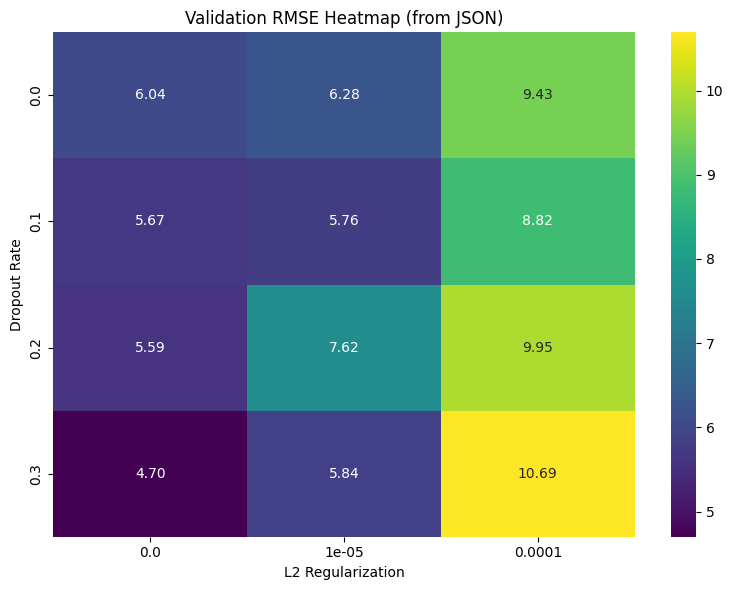

In [12]:
import pandas as pd
import seaborn as sns
!pip install matplotlib
import matplotlib
import matplotlib.pyplot as plt

# Create DataFrame
df_loaded = pd.DataFrame(loaded_results)
df_loaded['dropout'] = df_loaded['dropout'].astype(float)
heatmap_data = df_loaded.pivot(index='dropout', columns='l2', values='val_rmse')

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="viridis")
plt.title("Validation RMSE Heatmap (from JSON)")
plt.xlabel("L2 Regularization")
plt.ylabel("Dropout Rate")
plt.tight_layout()
plt.show()



Retraining model: dropout=0.0, L2=0.0


Epochs:   3%|█▏                                  | 1/30 [00:03<01:50,  3.80s/it]

Epoch 1 - Train Loss: 1.3789, Val Loss: 0.0498, RMSE: 44.26 kcal/mol


Epochs:   7%|██▍                                 | 2/30 [00:06<01:35,  3.42s/it]

Epoch 2 - Train Loss: 0.1062, Val Loss: 0.0327, RMSE: 35.81 kcal/mol


Epochs:  10%|███▌                                | 3/30 [00:10<01:34,  3.52s/it]

Epoch 3 - Train Loss: 0.0488, Val Loss: 0.0244, RMSE: 30.94 kcal/mol


Epochs:  13%|████▊                               | 4/30 [00:14<01:31,  3.51s/it]

Epoch 4 - Train Loss: 0.0283, Val Loss: 0.0209, RMSE: 28.62 kcal/mol


Epochs:  17%|██████                              | 5/30 [00:18<01:36,  3.87s/it]

Epoch 5 - Train Loss: 0.0207, Val Loss: 0.0168, RMSE: 25.68 kcal/mol


Epochs:  20%|███████▏                            | 6/30 [00:21<01:28,  3.69s/it]

Epoch 6 - Train Loss: 0.0168, Val Loss: 0.0147, RMSE: 24.03 kcal/mol


Epochs:  23%|████████▍                           | 7/30 [00:25<01:23,  3.61s/it]

Epoch 7 - Train Loss: 0.0142, Val Loss: 0.0126, RMSE: 22.22 kcal/mol


Epochs:  27%|█████████▌                          | 8/30 [00:28<01:15,  3.45s/it]

Epoch 8 - Train Loss: 0.0121, Val Loss: 0.0107, RMSE: 20.49 kcal/mol


Epochs:  30%|██████████▊                         | 9/30 [00:31<01:08,  3.27s/it]

Epoch 9 - Train Loss: 0.0098, Val Loss: 0.0083, RMSE: 18.08 kcal/mol


Epochs:  33%|███████████▋                       | 10/30 [00:34<01:03,  3.20s/it]

Epoch 10 - Train Loss: 0.0071, Val Loss: 0.0058, RMSE: 15.12 kcal/mol


Epochs:  37%|████████████▊                      | 11/30 [00:37<01:01,  3.24s/it]

Epoch 11 - Train Loss: 0.0047, Val Loss: 0.0041, RMSE: 12.63 kcal/mol


Epochs:  40%|██████████████                     | 12/30 [00:41<00:58,  3.28s/it]

Epoch 12 - Train Loss: 0.0031, Val Loss: 0.0031, RMSE: 11.08 kcal/mol


Epochs:  43%|███████████████▏                   | 13/30 [00:43<00:53,  3.13s/it]

Epoch 13 - Train Loss: 0.0022, Val Loss: 0.0026, RMSE: 10.10 kcal/mol


Epochs:  47%|████████████████▎                  | 14/30 [00:46<00:49,  3.09s/it]

Epoch 14 - Train Loss: 0.0017, Val Loss: 0.0022, RMSE: 9.25 kcal/mol


Epochs:  50%|█████████████████▌                 | 15/30 [00:49<00:45,  3.05s/it]

Epoch 15 - Train Loss: 0.0014, Val Loss: 0.0019, RMSE: 8.57 kcal/mol


Epochs:  53%|██████████████████▋                | 16/30 [00:52<00:41,  2.98s/it]

Epoch 16 - Train Loss: 0.0012, Val Loss: 0.0017, RMSE: 8.09 kcal/mol


Epochs:  57%|███████████████████▊               | 17/30 [00:55<00:38,  2.92s/it]

Epoch 17 - Train Loss: 0.0010, Val Loss: 0.0015, RMSE: 7.71 kcal/mol


Epochs:  60%|█████████████████████              | 18/30 [00:58<00:34,  2.90s/it]

Epoch 18 - Train Loss: 0.0009, Val Loss: 0.0013, RMSE: 7.30 kcal/mol


Epochs:  63%|██████████████████████▏            | 19/30 [01:01<00:31,  2.86s/it]

Epoch 19 - Train Loss: 0.0008, Val Loss: 0.0012, RMSE: 6.89 kcal/mol


Epochs:  67%|███████████████████████▎           | 20/30 [01:03<00:28,  2.84s/it]

Epoch 20 - Train Loss: 0.0007, Val Loss: 0.0011, RMSE: 6.53 kcal/mol


Epochs:  70%|████████████████████████▌          | 21/30 [01:06<00:25,  2.82s/it]

Epoch 21 - Train Loss: 0.0007, Val Loss: 0.0010, RMSE: 6.29 kcal/mol


Epochs:  73%|█████████████████████████▋         | 22/30 [01:09<00:22,  2.83s/it]

Epoch 22 - Train Loss: 0.0006, Val Loss: 0.0009, RMSE: 6.11 kcal/mol


Epochs:  77%|██████████████████████████▊        | 23/30 [01:12<00:19,  2.81s/it]

Epoch 23 - Train Loss: 0.0006, Val Loss: 0.0009, RMSE: 5.96 kcal/mol


Epochs:  80%|████████████████████████████       | 24/30 [01:15<00:16,  2.80s/it]

Epoch 24 - Train Loss: 0.0005, Val Loss: 0.0009, RMSE: 5.83 kcal/mol


Epochs:  83%|█████████████████████████████▏     | 25/30 [01:17<00:14,  2.83s/it]

Epoch 25 - Train Loss: 0.0005, Val Loss: 0.0008, RMSE: 5.70 kcal/mol


Epochs:  87%|██████████████████████████████▎    | 26/30 [01:20<00:11,  2.83s/it]

Epoch 26 - Train Loss: 0.0005, Val Loss: 0.0008, RMSE: 5.58 kcal/mol


Epochs:  90%|███████████████████████████████▌   | 27/30 [01:23<00:08,  2.81s/it]

Epoch 27 - Train Loss: 0.0004, Val Loss: 0.0008, RMSE: 5.46 kcal/mol


Epochs:  93%|████████████████████████████████▋  | 28/30 [01:27<00:06,  3.09s/it]

Epoch 28 - Train Loss: 0.0004, Val Loss: 0.0007, RMSE: 5.36 kcal/mol


Epochs:  97%|█████████████████████████████████▊ | 29/30 [01:30<00:03,  3.03s/it]

Epoch 29 - Train Loss: 0.0004, Val Loss: 0.0007, RMSE: 5.25 kcal/mol


Epochs: 100%|███████████████████████████████████| 30/30 [01:33<00:00,  3.10s/it]

Epoch 30 - Train Loss: 0.0004, Val Loss: 0.0007, RMSE: 5.16 kcal/mol

Retraining model: dropout=0.0, L2=1e-05



Epochs:   3%|█▏                                  | 1/30 [00:04<02:02,  4.21s/it]

Epoch 1 - Train Loss: 1.0657, Val Loss: 0.0788, RMSE: 55.62 kcal/mol


Epochs:   7%|██▍                                 | 2/30 [00:07<01:36,  3.44s/it]

Epoch 2 - Train Loss: 0.1107, Val Loss: 0.0561, RMSE: 46.94 kcal/mol


Epochs:  10%|███▌                                | 3/30 [00:10<01:28,  3.28s/it]

Epoch 3 - Train Loss: 0.0485, Val Loss: 0.0370, RMSE: 38.12 kcal/mol


Epochs:  13%|████▊                               | 4/30 [00:13<01:20,  3.09s/it]

Epoch 4 - Train Loss: 0.0280, Val Loss: 0.0235, RMSE: 30.40 kcal/mol


Epochs:  17%|██████                              | 5/30 [00:15<01:14,  2.99s/it]

Epoch 5 - Train Loss: 0.0190, Val Loss: 0.0143, RMSE: 23.69 kcal/mol


Epochs:  20%|███████▏                            | 6/30 [00:18<01:09,  2.91s/it]

Epoch 6 - Train Loss: 0.0138, Val Loss: 0.0115, RMSE: 21.21 kcal/mol


Epochs:  23%|████████▍                           | 7/30 [00:21<01:06,  2.89s/it]

Epoch 7 - Train Loss: 0.0111, Val Loss: 0.0098, RMSE: 19.65 kcal/mol


Epochs:  27%|█████████▌                          | 8/30 [00:24<01:04,  2.91s/it]

Epoch 8 - Train Loss: 0.0093, Val Loss: 0.0082, RMSE: 17.98 kcal/mol


Epochs:  30%|██████████▊                         | 9/30 [00:27<01:00,  2.90s/it]

Epoch 9 - Train Loss: 0.0075, Val Loss: 0.0064, RMSE: 15.93 kcal/mol


Epochs:  33%|███████████▋                       | 10/30 [00:30<00:57,  2.86s/it]

Epoch 10 - Train Loss: 0.0056, Val Loss: 0.0050, RMSE: 13.97 kcal/mol


Epochs:  37%|████████████▊                      | 11/30 [00:32<00:53,  2.83s/it]

Epoch 11 - Train Loss: 0.0040, Val Loss: 0.0038, RMSE: 12.26 kcal/mol


Epochs:  40%|██████████████                     | 12/30 [00:35<00:51,  2.87s/it]

Epoch 12 - Train Loss: 0.0029, Val Loss: 0.0031, RMSE: 10.99 kcal/mol


Epochs:  43%|███████████████▏                   | 13/30 [00:38<00:47,  2.82s/it]

Epoch 13 - Train Loss: 0.0022, Val Loss: 0.0027, RMSE: 10.39 kcal/mol


Epochs:  47%|████████████████▎                  | 14/30 [00:41<00:44,  2.80s/it]

Epoch 14 - Train Loss: 0.0017, Val Loss: 0.0022, RMSE: 9.35 kcal/mol


Epochs:  50%|█████████████████▌                 | 15/30 [00:43<00:41,  2.75s/it]

Epoch 15 - Train Loss: 0.0014, Val Loss: 0.0019, RMSE: 8.73 kcal/mol


Epochs:  53%|██████████████████▋                | 16/30 [00:46<00:38,  2.77s/it]

Epoch 16 - Train Loss: 0.0012, Val Loss: 0.0018, RMSE: 8.35 kcal/mol


Epochs:  57%|███████████████████▊               | 17/30 [00:49<00:35,  2.75s/it]

Epoch 17 - Train Loss: 0.0010, Val Loss: 0.0016, RMSE: 7.94 kcal/mol


Epochs:  60%|█████████████████████              | 18/30 [00:52<00:32,  2.75s/it]

Epoch 18 - Train Loss: 0.0009, Val Loss: 0.0014, RMSE: 7.56 kcal/mol


Epochs:  63%|██████████████████████▏            | 19/30 [00:54<00:30,  2.75s/it]

Epoch 19 - Train Loss: 0.0008, Val Loss: 0.0013, RMSE: 7.31 kcal/mol


Epochs:  67%|███████████████████████▎           | 20/30 [00:57<00:27,  2.75s/it]

Epoch 20 - Train Loss: 0.0008, Val Loss: 0.0012, RMSE: 7.05 kcal/mol


Epochs:  70%|████████████████████████▌          | 21/30 [01:00<00:24,  2.75s/it]

Epoch 21 - Train Loss: 0.0007, Val Loss: 0.0012, RMSE: 6.84 kcal/mol


Epochs:  73%|█████████████████████████▋         | 22/30 [01:03<00:21,  2.74s/it]

Epoch 22 - Train Loss: 0.0007, Val Loss: 0.0011, RMSE: 6.69 kcal/mol


Epochs:  77%|██████████████████████████▊        | 23/30 [01:05<00:19,  2.76s/it]

Epoch 23 - Train Loss: 0.0006, Val Loss: 0.0011, RMSE: 6.56 kcal/mol


Epochs:  80%|████████████████████████████       | 24/30 [01:08<00:16,  2.74s/it]

Epoch 24 - Train Loss: 0.0006, Val Loss: 0.0010, RMSE: 6.45 kcal/mol


Epochs:  83%|█████████████████████████████▏     | 25/30 [01:11<00:13,  2.74s/it]

Epoch 25 - Train Loss: 0.0006, Val Loss: 0.0010, RMSE: 6.33 kcal/mol


Epochs:  87%|██████████████████████████████▎    | 26/30 [01:14<00:10,  2.72s/it]

Epoch 26 - Train Loss: 0.0006, Val Loss: 0.0010, RMSE: 6.21 kcal/mol


Epochs:  90%|███████████████████████████████▌   | 27/30 [01:16<00:08,  2.73s/it]

Epoch 27 - Train Loss: 0.0005, Val Loss: 0.0009, RMSE: 6.09 kcal/mol


Epochs:  93%|████████████████████████████████▋  | 28/30 [01:19<00:05,  2.74s/it]

Epoch 28 - Train Loss: 0.0005, Val Loss: 0.0010, RMSE: 6.20 kcal/mol


Epochs:  97%|█████████████████████████████████▊ | 29/30 [01:22<00:02,  2.73s/it]

Epoch 29 - Train Loss: 0.0005, Val Loss: 0.0010, RMSE: 6.16 kcal/mol


Epochs: 100%|███████████████████████████████████| 30/30 [01:24<00:00,  2.83s/it]

Epoch 30 - Train Loss: 0.0005, Val Loss: 0.0009, RMSE: 5.96 kcal/mol

Retraining model: dropout=0.0, L2=0.0001



Epochs:   3%|█▏                                  | 1/30 [00:02<01:19,  2.73s/it]

Epoch 1 - Train Loss: 0.6512, Val Loss: 0.1411, RMSE: 74.55 kcal/mol


Epochs:   7%|██▍                                 | 2/30 [00:05<01:15,  2.70s/it]

Epoch 2 - Train Loss: 0.0850, Val Loss: 0.0326, RMSE: 35.79 kcal/mol


Epochs:  10%|███▌                                | 3/30 [00:08<01:13,  2.71s/it]

Epoch 3 - Train Loss: 0.0270, Val Loss: 0.0284, RMSE: 33.41 kcal/mol


Epochs:  13%|████▊                               | 4/30 [00:10<01:11,  2.73s/it]

Epoch 4 - Train Loss: 0.0221, Val Loss: 0.0158, RMSE: 24.90 kcal/mol


Epochs:  17%|██████                              | 5/30 [00:13<01:07,  2.72s/it]

Epoch 5 - Train Loss: 0.0152, Val Loss: 0.0138, RMSE: 23.26 kcal/mol


Epochs:  20%|███████▏                            | 6/30 [00:16<01:05,  2.73s/it]

Epoch 6 - Train Loss: 0.0125, Val Loss: 0.0110, RMSE: 20.83 kcal/mol


Epochs:  23%|████████▍                           | 7/30 [00:19<01:05,  2.84s/it]

Epoch 7 - Train Loss: 0.0106, Val Loss: 0.0095, RMSE: 19.28 kcal/mol


Epochs:  27%|█████████▌                          | 8/30 [00:22<01:02,  2.83s/it]

Epoch 8 - Train Loss: 0.0091, Val Loss: 0.0082, RMSE: 17.98 kcal/mol


Epochs:  30%|██████████▊                         | 9/30 [00:24<00:58,  2.80s/it]

Epoch 9 - Train Loss: 0.0077, Val Loss: 0.0071, RMSE: 16.65 kcal/mol


Epochs:  33%|███████████▋                       | 10/30 [00:27<00:55,  2.78s/it]

Epoch 10 - Train Loss: 0.0065, Val Loss: 0.0060, RMSE: 15.38 kcal/mol


Epochs:  37%|████████████▊                      | 11/30 [00:30<00:53,  2.79s/it]

Epoch 11 - Train Loss: 0.0055, Val Loss: 0.0051, RMSE: 14.18 kcal/mol


Epochs:  40%|██████████████                     | 12/30 [00:33<00:50,  2.81s/it]

Epoch 12 - Train Loss: 0.0047, Val Loss: 0.0044, RMSE: 13.12 kcal/mol


Epochs:  43%|███████████████▏                   | 13/30 [00:36<00:47,  2.79s/it]

Epoch 13 - Train Loss: 0.0040, Val Loss: 0.0039, RMSE: 12.40 kcal/mol


Epochs:  47%|████████████████▎                  | 14/30 [00:38<00:44,  2.75s/it]

Epoch 14 - Train Loss: 0.0035, Val Loss: 0.0036, RMSE: 11.89 kcal/mol


Epochs:  50%|█████████████████▌                 | 15/30 [00:41<00:41,  2.80s/it]

Epoch 15 - Train Loss: 0.0031, Val Loss: 0.0034, RMSE: 11.55 kcal/mol


Epochs:  53%|██████████████████▋                | 16/30 [00:44<00:38,  2.78s/it]

Epoch 16 - Train Loss: 0.0028, Val Loss: 0.0033, RMSE: 11.36 kcal/mol


Epochs:  57%|███████████████████▊               | 17/30 [00:47<00:36,  2.78s/it]

Epoch 17 - Train Loss: 0.0027, Val Loss: 0.0031, RMSE: 11.09 kcal/mol


Epochs:  60%|█████████████████████              | 18/30 [00:49<00:33,  2.76s/it]

Epoch 18 - Train Loss: 0.0025, Val Loss: 0.0029, RMSE: 10.74 kcal/mol


Epochs:  63%|██████████████████████▏            | 19/30 [00:52<00:30,  2.76s/it]

Epoch 19 - Train Loss: 0.0024, Val Loss: 0.0027, RMSE: 10.37 kcal/mol


Epochs:  67%|███████████████████████▎           | 20/30 [00:55<00:27,  2.75s/it]

Epoch 20 - Train Loss: 0.0023, Val Loss: 0.0026, RMSE: 10.09 kcal/mol


Epochs:  70%|████████████████████████▌          | 21/30 [00:58<00:24,  2.76s/it]

Epoch 21 - Train Loss: 0.0022, Val Loss: 0.0025, RMSE: 9.92 kcal/mol


Epochs:  73%|█████████████████████████▋         | 22/30 [01:00<00:22,  2.76s/it]

Epoch 22 - Train Loss: 0.0021, Val Loss: 0.0024, RMSE: 9.81 kcal/mol


Epochs:  77%|██████████████████████████▊        | 23/30 [01:03<00:19,  2.74s/it]

Epoch 23 - Train Loss: 0.0020, Val Loss: 0.0024, RMSE: 9.74 kcal/mol


Epochs:  80%|████████████████████████████       | 24/30 [01:06<00:16,  2.74s/it]

Epoch 24 - Train Loss: 0.0019, Val Loss: 0.0024, RMSE: 9.73 kcal/mol


Epochs:  83%|█████████████████████████████▏     | 25/30 [01:09<00:13,  2.73s/it]

Epoch 25 - Train Loss: 0.0019, Val Loss: 0.0024, RMSE: 9.73 kcal/mol


Epochs:  87%|██████████████████████████████▎    | 26/30 [01:11<00:10,  2.74s/it]

Epoch 26 - Train Loss: 0.0019, Val Loss: 0.0024, RMSE: 9.72 kcal/mol


Epochs:  90%|███████████████████████████████▌   | 27/30 [01:14<00:08,  2.74s/it]

Epoch 27 - Train Loss: 0.0018, Val Loss: 0.0024, RMSE: 9.69 kcal/mol


Epochs:  93%|████████████████████████████████▋  | 28/30 [01:17<00:05,  2.73s/it]

Epoch 28 - Train Loss: 0.0018, Val Loss: 0.0023, RMSE: 9.66 kcal/mol


Epochs:  97%|█████████████████████████████████▊ | 29/30 [01:20<00:02,  2.73s/it]

Epoch 29 - Train Loss: 0.0017, Val Loss: 0.0023, RMSE: 9.60 kcal/mol


Epochs: 100%|███████████████████████████████████| 30/30 [01:22<00:00,  2.76s/it]

Epoch 30 - Train Loss: 0.0017, Val Loss: 0.0023, RMSE: 9.55 kcal/mol

Retraining model: dropout=0.1, L2=0.0



Epochs:   3%|█▏                                  | 1/30 [00:03<01:40,  3.47s/it]

Epoch 1 - Train Loss: 0.6121, Val Loss: 0.0532, RMSE: 45.74 kcal/mol


Epochs:   7%|██▍                                 | 2/30 [00:06<01:24,  3.02s/it]

Epoch 2 - Train Loss: 0.0658, Val Loss: 0.0331, RMSE: 36.08 kcal/mol


Epochs:  10%|███▌                                | 3/30 [00:08<01:18,  2.90s/it]

Epoch 3 - Train Loss: 0.0326, Val Loss: 0.0283, RMSE: 33.38 kcal/mol


Epochs:  13%|████▊                               | 4/30 [00:11<01:13,  2.84s/it]

Epoch 4 - Train Loss: 0.0256, Val Loss: 0.0221, RMSE: 29.49 kcal/mol


Epochs:  17%|██████                              | 5/30 [00:14<01:10,  2.80s/it]

Epoch 5 - Train Loss: 0.0198, Val Loss: 0.0175, RMSE: 26.22 kcal/mol


Epochs:  20%|███████▏                            | 6/30 [00:17<01:06,  2.79s/it]

Epoch 6 - Train Loss: 0.0167, Val Loss: 0.0146, RMSE: 23.99 kcal/mol


Epochs:  23%|████████▍                           | 7/30 [00:19<01:03,  2.76s/it]

Epoch 7 - Train Loss: 0.0145, Val Loss: 0.0127, RMSE: 22.33 kcal/mol


Epochs:  27%|█████████▌                          | 8/30 [00:22<01:00,  2.76s/it]

Epoch 8 - Train Loss: 0.0124, Val Loss: 0.0110, RMSE: 20.80 kcal/mol


Epochs:  30%|██████████▊                         | 9/30 [00:25<00:57,  2.74s/it]

Epoch 9 - Train Loss: 0.0104, Val Loss: 0.0091, RMSE: 18.96 kcal/mol


Epochs:  33%|███████████▋                       | 10/30 [00:28<00:54,  2.74s/it]

Epoch 10 - Train Loss: 0.0082, Val Loss: 0.0071, RMSE: 16.73 kcal/mol


Epochs:  37%|████████████▊                      | 11/30 [00:30<00:51,  2.73s/it]

Epoch 11 - Train Loss: 0.0061, Val Loss: 0.0054, RMSE: 14.61 kcal/mol


Epochs:  40%|██████████████                     | 12/30 [00:33<00:49,  2.73s/it]

Epoch 12 - Train Loss: 0.0043, Val Loss: 0.0042, RMSE: 12.79 kcal/mol


Epochs:  43%|███████████████▏                   | 13/30 [00:36<00:46,  2.73s/it]

Epoch 13 - Train Loss: 0.0030, Val Loss: 0.0033, RMSE: 11.44 kcal/mol


Epochs:  47%|████████████████▎                  | 14/30 [00:39<00:43,  2.74s/it]

Epoch 14 - Train Loss: 0.0021, Val Loss: 0.0027, RMSE: 10.22 kcal/mol


Epochs:  50%|█████████████████▌                 | 15/30 [00:41<00:41,  2.73s/it]

Epoch 15 - Train Loss: 0.0017, Val Loss: 0.0024, RMSE: 9.74 kcal/mol


Epochs:  53%|██████████████████▋                | 16/30 [00:44<00:38,  2.73s/it]

Epoch 16 - Train Loss: 0.0014, Val Loss: 0.0021, RMSE: 9.11 kcal/mol


Epochs:  57%|███████████████████▊               | 17/30 [00:47<00:35,  2.73s/it]

Epoch 17 - Train Loss: 0.0012, Val Loss: 0.0018, RMSE: 8.48 kcal/mol


Epochs:  60%|█████████████████████              | 18/30 [00:49<00:32,  2.74s/it]

Epoch 18 - Train Loss: 0.0010, Val Loss: 0.0016, RMSE: 8.00 kcal/mol


Epochs:  63%|██████████████████████▏            | 19/30 [00:52<00:30,  2.74s/it]

Epoch 19 - Train Loss: 0.0009, Val Loss: 0.0015, RMSE: 7.58 kcal/mol


Epochs:  67%|███████████████████████▎           | 20/30 [00:55<00:27,  2.76s/it]

Epoch 20 - Train Loss: 0.0008, Val Loss: 0.0013, RMSE: 7.15 kcal/mol


Epochs:  70%|████████████████████████▌          | 21/30 [00:58<00:24,  2.77s/it]

Epoch 21 - Train Loss: 0.0007, Val Loss: 0.0012, RMSE: 6.78 kcal/mol


Epochs:  73%|█████████████████████████▋         | 22/30 [01:01<00:22,  2.76s/it]

Epoch 22 - Train Loss: 0.0006, Val Loss: 0.0011, RMSE: 6.47 kcal/mol


Epochs:  77%|██████████████████████████▊        | 23/30 [01:03<00:19,  2.75s/it]

Epoch 23 - Train Loss: 0.0006, Val Loss: 0.0010, RMSE: 6.24 kcal/mol


Epochs:  80%|████████████████████████████       | 24/30 [01:06<00:16,  2.74s/it]

Epoch 24 - Train Loss: 0.0005, Val Loss: 0.0009, RMSE: 6.05 kcal/mol


Epochs:  83%|█████████████████████████████▏     | 25/30 [01:09<00:13,  2.74s/it]

Epoch 25 - Train Loss: 0.0005, Val Loss: 0.0009, RMSE: 5.88 kcal/mol


Epochs:  87%|██████████████████████████████▎    | 26/30 [01:11<00:10,  2.74s/it]

Epoch 26 - Train Loss: 0.0005, Val Loss: 0.0008, RMSE: 5.74 kcal/mol


Epochs:  90%|███████████████████████████████▌   | 27/30 [01:14<00:08,  2.75s/it]

Epoch 27 - Train Loss: 0.0004, Val Loss: 0.0008, RMSE: 5.61 kcal/mol


Epochs:  93%|████████████████████████████████▋  | 28/30 [01:17<00:05,  2.80s/it]

Epoch 28 - Train Loss: 0.0004, Val Loss: 0.0008, RMSE: 5.49 kcal/mol


Epochs:  97%|█████████████████████████████████▊ | 29/30 [01:21<00:02,  2.98s/it]

Epoch 29 - Train Loss: 0.0004, Val Loss: 0.0007, RMSE: 5.38 kcal/mol


Epochs: 100%|███████████████████████████████████| 30/30 [01:24<00:00,  2.81s/it]

Epoch 30 - Train Loss: 0.0004, Val Loss: 0.0007, RMSE: 5.31 kcal/mol

Retraining model: dropout=0.1, L2=1e-05



Epochs:   3%|█▏                                  | 1/30 [00:04<02:04,  4.29s/it]

Epoch 1 - Train Loss: 0.2069, Val Loss: 0.0684, RMSE: 51.89 kcal/mol


Epochs:   7%|██▍                                 | 2/30 [00:07<01:47,  3.85s/it]

Epoch 2 - Train Loss: 0.0491, Val Loss: 0.0311, RMSE: 34.98 kcal/mol


Epochs:  10%|███▌                                | 3/30 [00:11<01:42,  3.79s/it]

Epoch 3 - Train Loss: 0.0284, Val Loss: 0.0227, RMSE: 29.90 kcal/mol


Epochs:  13%|████▊                               | 4/30 [00:14<01:28,  3.39s/it]

Epoch 4 - Train Loss: 0.0189, Val Loss: 0.0172, RMSE: 25.95 kcal/mol


Epochs:  17%|██████                              | 5/30 [00:17<01:18,  3.15s/it]

Epoch 5 - Train Loss: 0.0149, Val Loss: 0.0131, RMSE: 22.65 kcal/mol


Epochs:  20%|███████▏                            | 6/30 [00:20<01:13,  3.08s/it]

Epoch 6 - Train Loss: 0.0118, Val Loss: 0.0104, RMSE: 20.25 kcal/mol


Epochs:  23%|████████▍                           | 7/30 [00:22<01:09,  3.01s/it]

Epoch 7 - Train Loss: 0.0090, Val Loss: 0.0071, RMSE: 16.74 kcal/mol


Epochs:  27%|█████████▌                          | 8/30 [00:25<01:04,  2.94s/it]

Epoch 8 - Train Loss: 0.0058, Val Loss: 0.0049, RMSE: 13.93 kcal/mol


Epochs:  30%|██████████▊                         | 9/30 [00:29<01:05,  3.13s/it]

Epoch 9 - Train Loss: 0.0035, Val Loss: 0.0036, RMSE: 11.93 kcal/mol


Epochs:  33%|███████████▋                       | 10/30 [00:33<01:07,  3.38s/it]

Epoch 10 - Train Loss: 0.0023, Val Loss: 0.0027, RMSE: 10.29 kcal/mol


Epochs:  37%|████████████▊                      | 11/30 [00:37<01:12,  3.81s/it]

Epoch 11 - Train Loss: 0.0017, Val Loss: 0.0023, RMSE: 9.48 kcal/mol


Epochs:  40%|██████████████                     | 12/30 [00:42<01:14,  4.11s/it]

Epoch 12 - Train Loss: 0.0014, Val Loss: 0.0020, RMSE: 8.92 kcal/mol


Epochs:  43%|███████████████▏                   | 13/30 [00:46<01:09,  4.06s/it]

Epoch 13 - Train Loss: 0.0012, Val Loss: 0.0017, RMSE: 8.20 kcal/mol


Epochs:  47%|████████████████▎                  | 14/30 [00:51<01:06,  4.16s/it]

Epoch 14 - Train Loss: 0.0010, Val Loss: 0.0015, RMSE: 7.65 kcal/mol


Epochs:  50%|█████████████████▌                 | 15/30 [00:55<01:05,  4.34s/it]

Epoch 15 - Train Loss: 0.0008, Val Loss: 0.0013, RMSE: 7.29 kcal/mol


Epochs:  53%|██████████████████▋                | 16/30 [01:01<01:07,  4.86s/it]

Epoch 16 - Train Loss: 0.0008, Val Loss: 0.0012, RMSE: 7.03 kcal/mol


Epochs:  57%|███████████████████▊               | 17/30 [01:06<01:03,  4.89s/it]

Epoch 17 - Train Loss: 0.0007, Val Loss: 0.0012, RMSE: 6.86 kcal/mol


Epochs:  60%|█████████████████████              | 18/30 [01:11<00:58,  4.88s/it]

Epoch 18 - Train Loss: 0.0007, Val Loss: 0.0011, RMSE: 6.62 kcal/mol


Epochs:  63%|██████████████████████▏            | 19/30 [01:15<00:50,  4.63s/it]

Epoch 19 - Train Loss: 0.0006, Val Loss: 0.0010, RMSE: 6.42 kcal/mol


Epochs:  67%|███████████████████████▎           | 20/30 [01:19<00:43,  4.34s/it]

Epoch 20 - Train Loss: 0.0006, Val Loss: 0.0010, RMSE: 6.26 kcal/mol


Epochs:  70%|████████████████████████▌          | 21/30 [01:23<00:37,  4.14s/it]

Epoch 21 - Train Loss: 0.0006, Val Loss: 0.0010, RMSE: 6.15 kcal/mol


Epochs:  73%|█████████████████████████▋         | 22/30 [01:26<00:32,  4.02s/it]

Epoch 22 - Train Loss: 0.0006, Val Loss: 0.0009, RMSE: 6.05 kcal/mol


Epochs:  77%|██████████████████████████▊        | 23/30 [01:30<00:27,  3.87s/it]

Epoch 23 - Train Loss: 0.0006, Val Loss: 0.0010, RMSE: 6.25 kcal/mol


Epochs:  80%|████████████████████████████       | 24/30 [01:33<00:22,  3.78s/it]

Epoch 24 - Train Loss: 0.0005, Val Loss: 0.0009, RMSE: 5.91 kcal/mol


Epochs:  83%|█████████████████████████████▏     | 25/30 [01:37<00:18,  3.68s/it]

Epoch 25 - Train Loss: 0.0005, Val Loss: 0.0010, RMSE: 6.17 kcal/mol


Epochs:  87%|██████████████████████████████▎    | 26/30 [01:40<00:14,  3.63s/it]

Epoch 26 - Train Loss: 0.0005, Val Loss: 0.0008, RMSE: 5.73 kcal/mol


Epochs:  90%|███████████████████████████████▌   | 27/30 [01:44<00:10,  3.56s/it]

Epoch 27 - Train Loss: 0.0005, Val Loss: 0.0008, RMSE: 5.66 kcal/mol


Epochs:  93%|████████████████████████████████▋  | 28/30 [01:47<00:07,  3.52s/it]

Epoch 28 - Train Loss: 0.0005, Val Loss: 0.0008, RMSE: 5.75 kcal/mol


Epochs:  97%|█████████████████████████████████▊ | 29/30 [01:51<00:03,  3.50s/it]

Epoch 29 - Train Loss: 0.0005, Val Loss: 0.0009, RMSE: 6.08 kcal/mol


Epochs: 100%|███████████████████████████████████| 30/30 [01:54<00:00,  3.82s/it]

Epoch 30 - Train Loss: 0.0005, Val Loss: 0.0010, RMSE: 6.25 kcal/mol

Retraining model: dropout=0.1, L2=0.0001



Epochs:   3%|█▏                                  | 1/30 [00:04<02:24,  4.97s/it]

Epoch 1 - Train Loss: 0.1218, Val Loss: 0.0465, RMSE: 42.69 kcal/mol


Epochs:   7%|██▍                                 | 2/30 [00:08<01:52,  4.01s/it]

Epoch 2 - Train Loss: 0.0313, Val Loss: 0.0133, RMSE: 22.83 kcal/mol


Epochs:  10%|███▌                                | 3/30 [00:11<01:39,  3.70s/it]

Epoch 3 - Train Loss: 0.0141, Val Loss: 0.0094, RMSE: 19.20 kcal/mol


Epochs:  13%|████▊                               | 4/30 [00:15<01:33,  3.58s/it]

Epoch 4 - Train Loss: 0.0094, Val Loss: 0.0076, RMSE: 17.25 kcal/mol


Epochs:  17%|██████                              | 5/30 [00:18<01:25,  3.40s/it]

Epoch 5 - Train Loss: 0.0072, Val Loss: 0.0062, RMSE: 15.68 kcal/mol


Epochs:  20%|███████▏                            | 6/30 [00:20<01:17,  3.22s/it]

Epoch 6 - Train Loss: 0.0059, Val Loss: 0.0053, RMSE: 14.44 kcal/mol


Epochs:  23%|████████▍                           | 7/30 [00:23<01:10,  3.08s/it]

Epoch 7 - Train Loss: 0.0049, Val Loss: 0.0048, RMSE: 13.74 kcal/mol


Epochs:  27%|█████████▌                          | 8/30 [00:26<01:05,  2.97s/it]

Epoch 8 - Train Loss: 0.0043, Val Loss: 0.0044, RMSE: 13.13 kcal/mol


Epochs:  30%|██████████▊                         | 9/30 [00:29<01:00,  2.89s/it]

Epoch 9 - Train Loss: 0.0037, Val Loss: 0.0036, RMSE: 12.01 kcal/mol


Epochs:  33%|███████████▋                       | 10/30 [00:32<00:57,  2.86s/it]

Epoch 10 - Train Loss: 0.0030, Val Loss: 0.0032, RMSE: 11.19 kcal/mol


Epochs:  37%|████████████▊                      | 11/30 [00:34<00:53,  2.84s/it]

Epoch 11 - Train Loss: 0.0025, Val Loss: 0.0029, RMSE: 10.70 kcal/mol


Epochs:  40%|██████████████                     | 12/30 [00:37<00:51,  2.83s/it]

Epoch 12 - Train Loss: 0.0022, Val Loss: 0.0026, RMSE: 10.23 kcal/mol


Epochs:  43%|███████████████▏                   | 13/30 [00:40<00:47,  2.82s/it]

Epoch 13 - Train Loss: 0.0019, Val Loss: 0.0025, RMSE: 9.89 kcal/mol


Epochs:  47%|████████████████▎                  | 14/30 [00:43<00:44,  2.80s/it]

Epoch 14 - Train Loss: 0.0019, Val Loss: 0.0024, RMSE: 9.69 kcal/mol


Epochs:  50%|█████████████████▌                 | 15/30 [00:45<00:41,  2.79s/it]

Epoch 15 - Train Loss: 0.0017, Val Loss: 0.0023, RMSE: 9.58 kcal/mol


Epochs:  53%|██████████████████▋                | 16/30 [00:48<00:38,  2.77s/it]

Epoch 16 - Train Loss: 0.0016, Val Loss: 0.0023, RMSE: 9.54 kcal/mol


Epochs:  57%|███████████████████▊               | 17/30 [00:51<00:36,  2.77s/it]

Epoch 17 - Train Loss: 0.0016, Val Loss: 0.0022, RMSE: 9.39 kcal/mol


Epochs:  60%|█████████████████████              | 18/30 [00:54<00:33,  2.75s/it]

Epoch 18 - Train Loss: 0.0015, Val Loss: 0.0022, RMSE: 9.26 kcal/mol


Epochs:  63%|██████████████████████▏            | 19/30 [00:56<00:30,  2.77s/it]

Epoch 19 - Train Loss: 0.0015, Val Loss: 0.0019, RMSE: 8.70 kcal/mol


Epochs:  67%|███████████████████████▎           | 20/30 [00:59<00:27,  2.76s/it]

Epoch 20 - Train Loss: 0.0020, Val Loss: 0.0021, RMSE: 9.07 kcal/mol


Epochs:  70%|████████████████████████▌          | 21/30 [01:02<00:24,  2.75s/it]

Epoch 21 - Train Loss: 0.0019, Val Loss: 0.0026, RMSE: 10.25 kcal/mol


Epochs:  73%|█████████████████████████▋         | 22/30 [01:05<00:22,  2.76s/it]

Epoch 22 - Train Loss: 0.0018, Val Loss: 0.0021, RMSE: 9.15 kcal/mol


Epochs:  77%|██████████████████████████▊        | 23/30 [01:08<00:19,  2.82s/it]

Epoch 23 - Train Loss: 0.0016, Val Loss: 0.0018, RMSE: 8.57 kcal/mol


Epochs:  80%|████████████████████████████       | 24/30 [01:10<00:16,  2.80s/it]

Epoch 24 - Train Loss: 0.0014, Val Loss: 0.0019, RMSE: 8.79 kcal/mol


Epochs:  83%|█████████████████████████████▏     | 25/30 [01:13<00:13,  2.78s/it]

Epoch 25 - Train Loss: 0.0015, Val Loss: 0.0020, RMSE: 8.93 kcal/mol


Epochs:  87%|██████████████████████████████▎    | 26/30 [01:16<00:11,  2.77s/it]

Epoch 26 - Train Loss: 0.0014, Val Loss: 0.0017, RMSE: 8.28 kcal/mol


Epochs:  90%|███████████████████████████████▌   | 27/30 [01:19<00:08,  2.77s/it]

Epoch 27 - Train Loss: 0.0013, Val Loss: 0.0017, RMSE: 8.33 kcal/mol


Epochs:  93%|████████████████████████████████▋  | 28/30 [01:21<00:05,  2.76s/it]

Epoch 28 - Train Loss: 0.0014, Val Loss: 0.0017, RMSE: 8.25 kcal/mol


Epochs:  97%|█████████████████████████████████▊ | 29/30 [01:24<00:02,  2.76s/it]

Epoch 29 - Train Loss: 0.0012, Val Loss: 0.0017, RMSE: 8.24 kcal/mol


Epochs: 100%|███████████████████████████████████| 30/30 [01:27<00:00,  2.91s/it]

Epoch 30 - Train Loss: 0.0012, Val Loss: 0.0019, RMSE: 8.69 kcal/mol

Retraining model: dropout=0.2, L2=0.0



Epochs:   3%|█▏                                  | 1/30 [00:03<01:43,  3.59s/it]

Epoch 1 - Train Loss: 0.1259, Val Loss: 0.0435, RMSE: 41.39 kcal/mol


Epochs:   7%|██▍                                 | 2/30 [00:06<01:26,  3.08s/it]

Epoch 2 - Train Loss: 0.0334, Val Loss: 0.0242, RMSE: 30.86 kcal/mol


Epochs:  10%|███▌                                | 3/30 [00:09<01:20,  2.96s/it]

Epoch 3 - Train Loss: 0.0210, Val Loss: 0.0161, RMSE: 25.11 kcal/mol


Epochs:  13%|████▊                               | 4/30 [00:11<01:15,  2.89s/it]

Epoch 4 - Train Loss: 0.0150, Val Loss: 0.0119, RMSE: 21.63 kcal/mol


Epochs:  17%|██████                              | 5/30 [00:14<01:12,  2.89s/it]

Epoch 5 - Train Loss: 0.0114, Val Loss: 0.0095, RMSE: 19.29 kcal/mol


Epochs:  20%|███████▏                            | 6/30 [00:17<01:08,  2.84s/it]

Epoch 6 - Train Loss: 0.0081, Val Loss: 0.0062, RMSE: 15.58 kcal/mol


Epochs:  23%|████████▍                           | 7/30 [00:20<01:04,  2.80s/it]

Epoch 7 - Train Loss: 0.0050, Val Loss: 0.0045, RMSE: 13.36 kcal/mol


Epochs:  27%|█████████▌                          | 8/30 [00:23<01:01,  2.79s/it]

Epoch 8 - Train Loss: 0.0032, Val Loss: 0.0035, RMSE: 11.75 kcal/mol


Epochs:  30%|██████████▊                         | 9/30 [00:25<00:57,  2.75s/it]

Epoch 9 - Train Loss: 0.0022, Val Loss: 0.0026, RMSE: 10.23 kcal/mol


Epochs:  33%|███████████▋                       | 10/30 [00:28<00:54,  2.74s/it]

Epoch 10 - Train Loss: 0.0016, Val Loss: 0.0022, RMSE: 9.42 kcal/mol


Epochs:  37%|████████████▊                      | 11/30 [00:31<00:53,  2.82s/it]

Epoch 11 - Train Loss: 0.0013, Val Loss: 0.0019, RMSE: 8.60 kcal/mol


Epochs:  40%|██████████████                     | 12/30 [00:34<00:50,  2.79s/it]

Epoch 12 - Train Loss: 0.0011, Val Loss: 0.0016, RMSE: 7.90 kcal/mol


Epochs:  43%|███████████████▏                   | 13/30 [00:36<00:47,  2.78s/it]

Epoch 13 - Train Loss: 0.0009, Val Loss: 0.0014, RMSE: 7.39 kcal/mol


Epochs:  47%|████████████████▎                  | 14/30 [00:39<00:44,  2.76s/it]

Epoch 14 - Train Loss: 0.0008, Val Loss: 0.0012, RMSE: 6.96 kcal/mol


Epochs:  50%|█████████████████▌                 | 15/30 [00:42<00:41,  2.76s/it]

Epoch 15 - Train Loss: 0.0007, Val Loss: 0.0011, RMSE: 6.59 kcal/mol


Epochs:  53%|██████████████████▋                | 16/30 [00:45<00:38,  2.75s/it]

Epoch 16 - Train Loss: 0.0006, Val Loss: 0.0010, RMSE: 6.34 kcal/mol


Epochs:  57%|███████████████████▊               | 17/30 [00:47<00:35,  2.73s/it]

Epoch 17 - Train Loss: 0.0005, Val Loss: 0.0009, RMSE: 6.09 kcal/mol


Epochs:  60%|█████████████████████              | 18/30 [00:50<00:32,  2.73s/it]

Epoch 18 - Train Loss: 0.0005, Val Loss: 0.0009, RMSE: 5.82 kcal/mol


Epochs:  63%|██████████████████████▏            | 19/30 [00:53<00:30,  2.73s/it]

Epoch 19 - Train Loss: 0.0004, Val Loss: 0.0008, RMSE: 5.63 kcal/mol


Epochs:  67%|███████████████████████▎           | 20/30 [00:55<00:27,  2.73s/it]

Epoch 20 - Train Loss: 0.0004, Val Loss: 0.0007, RMSE: 5.43 kcal/mol


Epochs:  70%|████████████████████████▌          | 21/30 [00:58<00:24,  2.74s/it]

Epoch 21 - Train Loss: 0.0004, Val Loss: 0.0007, RMSE: 5.30 kcal/mol


Epochs:  73%|█████████████████████████▋         | 22/30 [01:03<00:25,  3.21s/it]

Epoch 22 - Train Loss: 0.0003, Val Loss: 0.0007, RMSE: 5.21 kcal/mol


Epochs:  77%|██████████████████████████▊        | 23/30 [01:05<00:21,  3.07s/it]

Epoch 23 - Train Loss: 0.0003, Val Loss: 0.0007, RMSE: 5.15 kcal/mol


Epochs:  80%|████████████████████████████       | 24/30 [01:08<00:17,  2.97s/it]

Epoch 24 - Train Loss: 0.0003, Val Loss: 0.0006, RMSE: 5.06 kcal/mol


Epochs:  83%|█████████████████████████████▏     | 25/30 [01:11<00:14,  2.91s/it]

Epoch 25 - Train Loss: 0.0003, Val Loss: 0.0006, RMSE: 4.91 kcal/mol


Epochs:  87%|██████████████████████████████▎    | 26/30 [01:14<00:11,  2.85s/it]

Epoch 26 - Train Loss: 0.0003, Val Loss: 0.0007, RMSE: 5.09 kcal/mol


Epochs:  90%|███████████████████████████████▌   | 27/30 [01:16<00:08,  2.82s/it]

Epoch 27 - Train Loss: 0.0004, Val Loss: 0.0006, RMSE: 5.07 kcal/mol


Epochs:  93%|████████████████████████████████▋  | 28/30 [01:19<00:05,  2.81s/it]

Epoch 28 - Train Loss: 0.0003, Val Loss: 0.0007, RMSE: 5.41 kcal/mol


Epochs:  97%|█████████████████████████████████▊ | 29/30 [01:22<00:02,  2.78s/it]

Epoch 29 - Train Loss: 0.0003, Val Loss: 0.0006, RMSE: 4.69 kcal/mol


Epochs: 100%|███████████████████████████████████| 30/30 [01:25<00:00,  2.83s/it]

Epoch 30 - Train Loss: 0.0002, Val Loss: 0.0005, RMSE: 4.59 kcal/mol

Retraining model: dropout=0.2, L2=1e-05



Epochs:   3%|█▏                                  | 1/30 [00:03<01:54,  3.95s/it]

Epoch 1 - Train Loss: 1.2875, Val Loss: 0.1473, RMSE: 76.04 kcal/mol


Epochs:   7%|██▍                                 | 2/30 [00:06<01:34,  3.36s/it]

Epoch 2 - Train Loss: 0.1582, Val Loss: 0.0537, RMSE: 45.92 kcal/mol


Epochs:  10%|███▌                                | 3/30 [00:09<01:23,  3.09s/it]

Epoch 3 - Train Loss: 0.0557, Val Loss: 0.0355, RMSE: 37.36 kcal/mol


Epochs:  13%|████▊                               | 4/30 [00:12<01:18,  3.01s/it]

Epoch 4 - Train Loss: 0.0332, Val Loss: 0.0276, RMSE: 32.94 kcal/mol


Epochs:  17%|██████                              | 5/30 [00:15<01:14,  2.96s/it]

Epoch 5 - Train Loss: 0.0230, Val Loss: 0.0199, RMSE: 27.99 kcal/mol


Epochs:  20%|███████▏                            | 6/30 [00:18<01:09,  2.89s/it]

Epoch 6 - Train Loss: 0.0184, Val Loss: 0.0158, RMSE: 24.91 kcal/mol


Epochs:  23%|████████▍                           | 7/30 [00:20<01:05,  2.85s/it]

Epoch 7 - Train Loss: 0.0152, Val Loss: 0.0134, RMSE: 22.95 kcal/mol


Epochs:  27%|█████████▌                          | 8/30 [00:23<01:02,  2.86s/it]

Epoch 8 - Train Loss: 0.0128, Val Loss: 0.0116, RMSE: 21.36 kcal/mol


Epochs:  30%|██████████▊                         | 9/30 [00:26<00:59,  2.82s/it]

Epoch 9 - Train Loss: 0.0107, Val Loss: 0.0092, RMSE: 18.96 kcal/mol


Epochs:  33%|███████████▋                       | 10/30 [00:29<00:55,  2.79s/it]

Epoch 10 - Train Loss: 0.0084, Val Loss: 0.0071, RMSE: 16.65 kcal/mol


Epochs:  37%|████████████▊                      | 11/30 [00:32<00:52,  2.77s/it]

Epoch 11 - Train Loss: 0.0064, Val Loss: 0.0054, RMSE: 14.50 kcal/mol


Epochs:  40%|██████████████                     | 12/30 [00:34<00:49,  2.78s/it]

Epoch 12 - Train Loss: 0.0047, Val Loss: 0.0045, RMSE: 13.25 kcal/mol


Epochs:  43%|███████████████▏                   | 13/30 [00:37<00:47,  2.78s/it]

Epoch 13 - Train Loss: 0.0036, Val Loss: 0.0037, RMSE: 11.97 kcal/mol


Epochs:  47%|████████████████▎                  | 14/30 [00:40<00:44,  2.78s/it]

Epoch 14 - Train Loss: 0.0028, Val Loss: 0.0030, RMSE: 10.81 kcal/mol


Epochs:  50%|█████████████████▌                 | 15/30 [00:43<00:41,  2.80s/it]

Epoch 15 - Train Loss: 0.0022, Val Loss: 0.0026, RMSE: 10.05 kcal/mol


Epochs:  53%|██████████████████▋                | 16/30 [00:46<00:39,  2.81s/it]

Epoch 16 - Train Loss: 0.0019, Val Loss: 0.0023, RMSE: 9.53 kcal/mol


Epochs:  57%|███████████████████▊               | 17/30 [00:48<00:36,  2.78s/it]

Epoch 17 - Train Loss: 0.0016, Val Loss: 0.0021, RMSE: 9.14 kcal/mol


Epochs:  60%|█████████████████████              | 18/30 [00:51<00:33,  2.77s/it]

Epoch 18 - Train Loss: 0.0014, Val Loss: 0.0019, RMSE: 8.57 kcal/mol


Epochs:  63%|██████████████████████▏            | 19/30 [00:54<00:30,  2.77s/it]

Epoch 19 - Train Loss: 0.0012, Val Loss: 0.0017, RMSE: 8.17 kcal/mol


Epochs:  67%|███████████████████████▎           | 20/30 [00:57<00:27,  2.77s/it]

Epoch 20 - Train Loss: 0.0011, Val Loss: 0.0016, RMSE: 7.85 kcal/mol


Epochs:  70%|████████████████████████▌          | 21/30 [00:59<00:24,  2.76s/it]

Epoch 21 - Train Loss: 0.0010, Val Loss: 0.0015, RMSE: 7.61 kcal/mol


Epochs:  73%|█████████████████████████▋         | 22/30 [01:02<00:22,  2.76s/it]

Epoch 22 - Train Loss: 0.0010, Val Loss: 0.0014, RMSE: 7.40 kcal/mol


Epochs:  77%|██████████████████████████▊        | 23/30 [01:05<00:19,  2.77s/it]

Epoch 23 - Train Loss: 0.0009, Val Loss: 0.0013, RMSE: 7.18 kcal/mol


Epochs:  80%|████████████████████████████       | 24/30 [01:08<00:16,  2.76s/it]

Epoch 24 - Train Loss: 0.0008, Val Loss: 0.0012, RMSE: 6.93 kcal/mol


Epochs:  83%|█████████████████████████████▏     | 25/30 [01:10<00:13,  2.75s/it]

Epoch 25 - Train Loss: 0.0008, Val Loss: 0.0011, RMSE: 6.69 kcal/mol


Epochs:  87%|██████████████████████████████▎    | 26/30 [01:13<00:11,  2.77s/it]

Epoch 26 - Train Loss: 0.0007, Val Loss: 0.0011, RMSE: 6.58 kcal/mol


Epochs:  90%|███████████████████████████████▌   | 27/30 [01:16<00:08,  2.76s/it]

Epoch 27 - Train Loss: 0.0007, Val Loss: 0.0010, RMSE: 6.40 kcal/mol


Epochs:  93%|████████████████████████████████▋  | 28/30 [01:19<00:05,  2.76s/it]

Epoch 28 - Train Loss: 0.0007, Val Loss: 0.0010, RMSE: 6.31 kcal/mol


Epochs:  97%|█████████████████████████████████▊ | 29/30 [01:21<00:02,  2.77s/it]

Epoch 29 - Train Loss: 0.0006, Val Loss: 0.0010, RMSE: 6.19 kcal/mol


Epochs: 100%|███████████████████████████████████| 30/30 [01:24<00:00,  2.82s/it]

Epoch 30 - Train Loss: 0.0006, Val Loss: 0.0009, RMSE: 6.07 kcal/mol

Retraining model: dropout=0.2, L2=0.0001



Epochs:   3%|█▏                                  | 1/30 [00:03<01:43,  3.57s/it]

Epoch 1 - Train Loss: 0.1069, Val Loss: 0.0549, RMSE: 46.47 kcal/mol


Epochs:   7%|██▍                                 | 2/30 [00:06<01:25,  3.06s/it]

Epoch 2 - Train Loss: 0.0348, Val Loss: 0.0266, RMSE: 32.38 kcal/mol


Epochs:  10%|███▌                                | 3/30 [00:09<01:18,  2.92s/it]

Epoch 3 - Train Loss: 0.0237, Val Loss: 0.0190, RMSE: 27.30 kcal/mol


Epochs:  13%|████▊                               | 4/30 [00:11<01:13,  2.84s/it]

Epoch 4 - Train Loss: 0.0184, Val Loss: 0.0169, RMSE: 25.81 kcal/mol


Epochs:  17%|██████                              | 5/30 [00:14<01:10,  2.80s/it]

Epoch 5 - Train Loss: 0.0155, Val Loss: 0.0143, RMSE: 23.73 kcal/mol


Epochs:  20%|███████▏                            | 6/30 [00:17<01:06,  2.78s/it]

Epoch 6 - Train Loss: 0.0133, Val Loss: 0.0115, RMSE: 21.25 kcal/mol


Epochs:  23%|████████▍                           | 7/30 [00:20<01:04,  2.80s/it]

Epoch 7 - Train Loss: 0.0109, Val Loss: 0.0092, RMSE: 19.00 kcal/mol


Epochs:  27%|█████████▌                          | 8/30 [00:22<01:01,  2.78s/it]

Epoch 8 - Train Loss: 0.0084, Val Loss: 0.0072, RMSE: 16.84 kcal/mol


Epochs:  30%|██████████▊                         | 9/30 [00:25<00:58,  2.78s/it]

Epoch 9 - Train Loss: 0.0063, Val Loss: 0.0054, RMSE: 14.58 kcal/mol


Epochs:  33%|███████████▋                       | 10/30 [00:28<00:55,  2.77s/it]

Epoch 10 - Train Loss: 0.0046, Val Loss: 0.0045, RMSE: 13.30 kcal/mol


Epochs:  37%|████████████▊                      | 11/30 [00:31<00:52,  2.76s/it]

Epoch 11 - Train Loss: 0.0036, Val Loss: 0.0036, RMSE: 11.89 kcal/mol


Epochs:  40%|██████████████                     | 12/30 [00:33<00:49,  2.75s/it]

Epoch 12 - Train Loss: 0.0029, Val Loss: 0.0033, RMSE: 11.32 kcal/mol


Epochs:  43%|███████████████▏                   | 13/30 [00:36<00:46,  2.73s/it]

Epoch 13 - Train Loss: 0.0026, Val Loss: 0.0029, RMSE: 10.76 kcal/mol


Epochs:  47%|████████████████▎                  | 14/30 [00:39<00:43,  2.74s/it]

Epoch 14 - Train Loss: 0.0024, Val Loss: 0.0027, RMSE: 10.36 kcal/mol


Epochs:  50%|█████████████████▌                 | 15/30 [00:42<00:42,  2.81s/it]

Epoch 15 - Train Loss: 0.0021, Val Loss: 0.0025, RMSE: 9.94 kcal/mol


Epochs:  53%|██████████████████▋                | 16/30 [00:45<00:42,  3.01s/it]

Epoch 16 - Train Loss: 0.0020, Val Loss: 0.0025, RMSE: 10.03 kcal/mol


Epochs:  57%|███████████████████▊               | 17/30 [00:48<00:40,  3.09s/it]

Epoch 17 - Train Loss: 0.0020, Val Loss: 0.0024, RMSE: 9.68 kcal/mol


Epochs:  60%|█████████████████████              | 18/30 [00:52<00:39,  3.30s/it]

Epoch 18 - Train Loss: 0.0017, Val Loss: 0.0021, RMSE: 9.10 kcal/mol


Epochs:  63%|██████████████████████▏            | 19/30 [00:56<00:37,  3.39s/it]

Epoch 19 - Train Loss: 0.0018, Val Loss: 0.0025, RMSE: 10.04 kcal/mol


Epochs:  67%|███████████████████████▎           | 20/30 [00:59<00:33,  3.40s/it]

Epoch 20 - Train Loss: 0.0018, Val Loss: 0.0020, RMSE: 8.94 kcal/mol


Epochs:  70%|████████████████████████▌          | 21/30 [01:02<00:28,  3.21s/it]

Epoch 21 - Train Loss: 0.0014, Val Loss: 0.0018, RMSE: 8.56 kcal/mol


Epochs:  73%|█████████████████████████▋         | 22/30 [01:05<00:25,  3.13s/it]

Epoch 22 - Train Loss: 0.0016, Val Loss: 0.0018, RMSE: 8.41 kcal/mol


Epochs:  77%|██████████████████████████▊        | 23/30 [01:08<00:21,  3.02s/it]

Epoch 23 - Train Loss: 0.0017, Val Loss: 0.0018, RMSE: 8.49 kcal/mol


Epochs:  80%|████████████████████████████       | 24/30 [01:10<00:17,  2.93s/it]

Epoch 24 - Train Loss: 0.0015, Val Loss: 0.0019, RMSE: 8.62 kcal/mol


Epochs:  83%|█████████████████████████████▏     | 25/30 [01:13<00:14,  2.88s/it]

Epoch 25 - Train Loss: 0.0015, Val Loss: 0.0018, RMSE: 8.38 kcal/mol


Epochs:  87%|██████████████████████████████▎    | 26/30 [01:16<00:11,  2.84s/it]

Epoch 26 - Train Loss: 0.0013, Val Loss: 0.0017, RMSE: 8.27 kcal/mol


Epochs:  90%|███████████████████████████████▌   | 27/30 [01:19<00:08,  2.84s/it]

Epoch 27 - Train Loss: 0.0014, Val Loss: 0.0020, RMSE: 8.83 kcal/mol


Epochs:  93%|████████████████████████████████▋  | 28/30 [01:22<00:05,  2.83s/it]

Epoch 28 - Train Loss: 0.0017, Val Loss: 0.0017, RMSE: 8.16 kcal/mol


Epochs:  97%|█████████████████████████████████▊ | 29/30 [01:24<00:02,  2.80s/it]

Epoch 29 - Train Loss: 0.0015, Val Loss: 0.0019, RMSE: 8.69 kcal/mol


Epochs: 100%|███████████████████████████████████| 30/30 [01:27<00:00,  2.92s/it]

Epoch 30 - Train Loss: 0.0013, Val Loss: 0.0016, RMSE: 8.05 kcal/mol

Retraining model: dropout=0.3, L2=0.0



Epochs:   3%|█▏                                  | 1/30 [00:03<01:48,  3.74s/it]

Epoch 1 - Train Loss: 0.1650, Val Loss: 0.0511, RMSE: 44.85 kcal/mol


Epochs:   7%|██▍                                 | 2/30 [00:06<01:27,  3.12s/it]

Epoch 2 - Train Loss: 0.0275, Val Loss: 0.0201, RMSE: 28.11 kcal/mol


Epochs:  10%|███▌                                | 3/30 [00:09<01:19,  2.95s/it]

Epoch 3 - Train Loss: 0.0154, Val Loss: 0.0123, RMSE: 21.96 kcal/mol


Epochs:  13%|████▊                               | 4/30 [00:11<01:15,  2.90s/it]

Epoch 4 - Train Loss: 0.0106, Val Loss: 0.0084, RMSE: 18.16 kcal/mol


Epochs:  17%|██████                              | 5/30 [00:14<01:10,  2.82s/it]

Epoch 5 - Train Loss: 0.0075, Val Loss: 0.0058, RMSE: 15.06 kcal/mol


Epochs:  20%|███████▏                            | 6/30 [00:17<01:06,  2.79s/it]

Epoch 6 - Train Loss: 0.0048, Val Loss: 0.0041, RMSE: 12.77 kcal/mol


Epochs:  23%|████████▍                           | 7/30 [00:20<01:03,  2.76s/it]

Epoch 7 - Train Loss: 0.0031, Val Loss: 0.0030, RMSE: 10.93 kcal/mol


Epochs:  27%|█████████▌                          | 8/30 [00:22<01:00,  2.75s/it]

Epoch 8 - Train Loss: 0.0021, Val Loss: 0.0024, RMSE: 9.73 kcal/mol


Epochs:  30%|██████████▊                         | 9/30 [00:25<00:57,  2.75s/it]

Epoch 9 - Train Loss: 0.0016, Val Loss: 0.0020, RMSE: 8.83 kcal/mol


Epochs:  33%|███████████▋                       | 10/30 [00:28<00:54,  2.74s/it]

Epoch 10 - Train Loss: 0.0013, Val Loss: 0.0017, RMSE: 8.25 kcal/mol


Epochs:  37%|████████████▊                      | 11/30 [00:31<00:51,  2.73s/it]

Epoch 11 - Train Loss: 0.0010, Val Loss: 0.0015, RMSE: 7.60 kcal/mol


Epochs:  40%|██████████████                     | 12/30 [00:33<00:49,  2.75s/it]

Epoch 12 - Train Loss: 0.0009, Val Loss: 0.0013, RMSE: 7.17 kcal/mol


Epochs:  43%|███████████████▏                   | 13/30 [00:36<00:46,  2.74s/it]

Epoch 13 - Train Loss: 0.0008, Val Loss: 0.0012, RMSE: 6.82 kcal/mol


Epochs:  47%|████████████████▎                  | 14/30 [00:39<00:43,  2.74s/it]

Epoch 14 - Train Loss: 0.0007, Val Loss: 0.0010, RMSE: 6.45 kcal/mol


Epochs:  50%|█████████████████▌                 | 15/30 [00:42<00:41,  2.74s/it]

Epoch 15 - Train Loss: 0.0006, Val Loss: 0.0010, RMSE: 6.17 kcal/mol


Epochs:  53%|██████████████████▋                | 16/30 [00:44<00:38,  2.75s/it]

Epoch 16 - Train Loss: 0.0006, Val Loss: 0.0009, RMSE: 5.95 kcal/mol


Epochs:  57%|███████████████████▊               | 17/30 [00:47<00:35,  2.75s/it]

Epoch 17 - Train Loss: 0.0005, Val Loss: 0.0008, RMSE: 5.79 kcal/mol


Epochs:  60%|█████████████████████              | 18/30 [00:50<00:32,  2.73s/it]

Epoch 18 - Train Loss: 0.0005, Val Loss: 0.0008, RMSE: 5.74 kcal/mol


Epochs:  63%|██████████████████████▏            | 19/30 [00:52<00:30,  2.74s/it]

Epoch 19 - Train Loss: 0.0005, Val Loss: 0.0008, RMSE: 5.75 kcal/mol


Epochs:  67%|███████████████████████▎           | 20/30 [00:55<00:27,  2.74s/it]

Epoch 20 - Train Loss: 0.0004, Val Loss: 0.0008, RMSE: 5.68 kcal/mol


Epochs:  70%|████████████████████████▌          | 21/30 [00:58<00:24,  2.74s/it]

Epoch 21 - Train Loss: 0.0004, Val Loss: 0.0008, RMSE: 5.50 kcal/mol


Epochs:  73%|█████████████████████████▋         | 22/30 [01:01<00:22,  2.78s/it]

Epoch 22 - Train Loss: 0.0004, Val Loss: 0.0008, RMSE: 5.78 kcal/mol


Epochs:  77%|██████████████████████████▊        | 23/30 [01:04<00:19,  2.79s/it]

Epoch 23 - Train Loss: 0.0004, Val Loss: 0.0006, RMSE: 5.02 kcal/mol


Epochs:  80%|████████████████████████████       | 24/30 [01:06<00:16,  2.76s/it]

Epoch 24 - Train Loss: 0.0004, Val Loss: 0.0010, RMSE: 6.15 kcal/mol


Epochs:  83%|█████████████████████████████▏     | 25/30 [01:09<00:13,  2.76s/it]

Epoch 25 - Train Loss: 0.0004, Val Loss: 0.0007, RMSE: 5.23 kcal/mol


Epochs:  87%|██████████████████████████████▎    | 26/30 [01:12<00:11,  2.78s/it]

Epoch 26 - Train Loss: 0.0004, Val Loss: 0.0008, RMSE: 5.52 kcal/mol


Epochs:  90%|███████████████████████████████▌   | 27/30 [01:15<00:08,  2.80s/it]

Epoch 27 - Train Loss: 0.0004, Val Loss: 0.0006, RMSE: 4.92 kcal/mol


Epochs:  93%|████████████████████████████████▋  | 28/30 [01:18<00:05,  2.79s/it]

Epoch 28 - Train Loss: 0.0003, Val Loss: 0.0006, RMSE: 4.77 kcal/mol


Epochs:  97%|█████████████████████████████████▊ | 29/30 [01:20<00:02,  2.78s/it]

Epoch 29 - Train Loss: 0.0003, Val Loss: 0.0006, RMSE: 4.82 kcal/mol


Epochs: 100%|███████████████████████████████████| 30/30 [01:23<00:00,  2.78s/it]

Epoch 30 - Train Loss: 0.0003, Val Loss: 0.0006, RMSE: 4.79 kcal/mol

Retraining model: dropout=0.3, L2=1e-05



Epochs:   3%|█▏                                  | 1/30 [00:03<01:47,  3.71s/it]

Epoch 1 - Train Loss: 0.5001, Val Loss: 0.2499, RMSE: 99.26 kcal/mol


Epochs:   7%|██▍                                 | 2/30 [00:06<01:27,  3.14s/it]

Epoch 2 - Train Loss: 0.1851, Val Loss: 0.1332, RMSE: 72.40 kcal/mol


Epochs:  10%|███▌                                | 3/30 [00:09<01:19,  2.95s/it]

Epoch 3 - Train Loss: 0.0973, Val Loss: 0.0602, RMSE: 48.66 kcal/mol


Epochs:  13%|████▊                               | 4/30 [00:12<01:15,  2.92s/it]

Epoch 4 - Train Loss: 0.0476, Val Loss: 0.0356, RMSE: 37.38 kcal/mol


Epochs:  17%|██████                              | 5/30 [00:14<01:12,  2.92s/it]

Epoch 5 - Train Loss: 0.0305, Val Loss: 0.0232, RMSE: 30.21 kcal/mol


Epochs:  20%|███████▏                            | 6/30 [00:17<01:09,  2.90s/it]

Epoch 6 - Train Loss: 0.0207, Val Loss: 0.0164, RMSE: 25.40 kcal/mol


Epochs:  23%|████████▍                           | 7/30 [00:20<01:05,  2.85s/it]

Epoch 7 - Train Loss: 0.0147, Val Loss: 0.0119, RMSE: 21.63 kcal/mol


Epochs:  27%|█████████▌                          | 8/30 [00:23<01:05,  2.98s/it]

Epoch 8 - Train Loss: 0.0103, Val Loss: 0.0086, RMSE: 18.38 kcal/mol


Epochs:  30%|██████████▊                         | 9/30 [00:27<01:04,  3.07s/it]

Epoch 9 - Train Loss: 0.0071, Val Loss: 0.0069, RMSE: 16.38 kcal/mol


Epochs:  33%|███████████▋                       | 10/30 [00:30<01:02,  3.15s/it]

Epoch 10 - Train Loss: 0.0051, Val Loss: 0.0053, RMSE: 14.41 kcal/mol


Epochs:  37%|████████████▊                      | 11/30 [00:33<01:00,  3.18s/it]

Epoch 11 - Train Loss: 0.0039, Val Loss: 0.0042, RMSE: 12.89 kcal/mol


Epochs:  40%|██████████████                     | 12/30 [00:37<00:58,  3.23s/it]

Epoch 12 - Train Loss: 0.0030, Val Loss: 0.0037, RMSE: 12.00 kcal/mol


Epochs:  43%|███████████████▏                   | 13/30 [00:40<00:55,  3.25s/it]

Epoch 13 - Train Loss: 0.0025, Val Loss: 0.0034, RMSE: 11.49 kcal/mol


Epochs:  47%|████████████████▎                  | 14/30 [00:43<00:51,  3.25s/it]

Epoch 14 - Train Loss: 0.0021, Val Loss: 0.0029, RMSE: 10.66 kcal/mol


Epochs:  50%|█████████████████▌                 | 15/30 [00:46<00:49,  3.28s/it]

Epoch 15 - Train Loss: 0.0018, Val Loss: 0.0026, RMSE: 10.04 kcal/mol


Epochs:  53%|██████████████████▋                | 16/30 [00:50<00:45,  3.28s/it]

Epoch 16 - Train Loss: 0.0015, Val Loss: 0.0023, RMSE: 9.60 kcal/mol


Epochs:  57%|███████████████████▊               | 17/30 [00:53<00:42,  3.30s/it]

Epoch 17 - Train Loss: 0.0014, Val Loss: 0.0021, RMSE: 9.17 kcal/mol


Epochs:  60%|█████████████████████              | 18/30 [00:56<00:39,  3.32s/it]

Epoch 18 - Train Loss: 0.0013, Val Loss: 0.0020, RMSE: 8.83 kcal/mol


Epochs:  63%|██████████████████████▏            | 19/30 [01:00<00:36,  3.30s/it]

Epoch 19 - Train Loss: 0.0012, Val Loss: 0.0019, RMSE: 8.66 kcal/mol


Epochs:  67%|███████████████████████▎           | 20/30 [01:04<00:34,  3.48s/it]

Epoch 20 - Train Loss: 0.0011, Val Loss: 0.0019, RMSE: 8.58 kcal/mol


Epochs:  70%|████████████████████████▌          | 21/30 [01:07<00:30,  3.42s/it]

Epoch 21 - Train Loss: 0.0010, Val Loss: 0.0018, RMSE: 8.46 kcal/mol


Epochs:  73%|█████████████████████████▋         | 22/30 [01:10<00:27,  3.41s/it]

Epoch 22 - Train Loss: 0.0010, Val Loss: 0.0017, RMSE: 8.22 kcal/mol


Epochs:  77%|██████████████████████████▊        | 23/30 [01:14<00:23,  3.41s/it]

Epoch 23 - Train Loss: 0.0009, Val Loss: 0.0016, RMSE: 7.88 kcal/mol


Epochs:  80%|████████████████████████████       | 24/30 [01:17<00:20,  3.40s/it]

Epoch 24 - Train Loss: 0.0008, Val Loss: 0.0014, RMSE: 7.45 kcal/mol


Epochs:  83%|█████████████████████████████▏     | 25/30 [01:20<00:17,  3.41s/it]

Epoch 25 - Train Loss: 0.0007, Val Loss: 0.0013, RMSE: 7.08 kcal/mol


Epochs:  87%|██████████████████████████████▎    | 26/30 [01:24<00:13,  3.39s/it]

Epoch 26 - Train Loss: 0.0007, Val Loss: 0.0012, RMSE: 6.92 kcal/mol


Epochs:  90%|███████████████████████████████▌   | 27/30 [01:27<00:10,  3.38s/it]

Epoch 27 - Train Loss: 0.0006, Val Loss: 0.0012, RMSE: 6.76 kcal/mol


Epochs:  93%|████████████████████████████████▋  | 28/30 [01:31<00:06,  3.40s/it]

Epoch 28 - Train Loss: 0.0006, Val Loss: 0.0011, RMSE: 6.62 kcal/mol


Epochs:  97%|█████████████████████████████████▊ | 29/30 [01:34<00:03,  3.31s/it]

Epoch 29 - Train Loss: 0.0006, Val Loss: 0.0011, RMSE: 6.49 kcal/mol


Epochs: 100%|███████████████████████████████████| 30/30 [01:37<00:00,  3.25s/it]

Epoch 30 - Train Loss: 0.0006, Val Loss: 0.0011, RMSE: 6.50 kcal/mol

Retraining model: dropout=0.3, L2=0.0001



Epochs:   3%|█▏                                  | 1/30 [00:04<02:03,  4.26s/it]

Epoch 1 - Train Loss: 0.9202, Val Loss: 0.1270, RMSE: 70.76 kcal/mol


Epochs:   7%|██▍                                 | 2/30 [00:07<01:43,  3.68s/it]

Epoch 2 - Train Loss: 0.1434, Val Loss: 0.0753, RMSE: 54.49 kcal/mol


Epochs:  10%|███▌                                | 3/30 [00:10<01:35,  3.55s/it]

Epoch 3 - Train Loss: 0.0763, Val Loss: 0.0648, RMSE: 50.58 kcal/mol


Epochs:  13%|████▊                               | 4/30 [00:18<02:16,  5.25s/it]

Epoch 4 - Train Loss: 0.0569, Val Loss: 0.0459, RMSE: 42.53 kcal/mol


Epochs:  17%|██████                              | 5/30 [00:27<02:40,  6.42s/it]

Epoch 5 - Train Loss: 0.0418, Val Loss: 0.0336, RMSE: 36.37 kcal/mol


Epochs:  20%|███████▏                            | 6/30 [00:32<02:20,  5.86s/it]

Epoch 6 - Train Loss: 0.0323, Val Loss: 0.0279, RMSE: 33.15 kcal/mol


Epochs:  23%|████████▍                           | 7/30 [00:36<02:04,  5.42s/it]

Epoch 7 - Train Loss: 0.0264, Val Loss: 0.0232, RMSE: 30.18 kcal/mol


Epochs:  27%|█████████▌                          | 8/30 [00:40<01:48,  4.94s/it]

Epoch 8 - Train Loss: 0.0216, Val Loss: 0.0190, RMSE: 27.34 kcal/mol


Epochs:  30%|██████████▊                         | 9/30 [00:45<01:43,  4.93s/it]

Epoch 9 - Train Loss: 0.0177, Val Loss: 0.0153, RMSE: 24.53 kcal/mol


Epochs:  33%|███████████▋                       | 10/30 [00:49<01:33,  4.67s/it]

Epoch 10 - Train Loss: 0.0143, Val Loss: 0.0126, RMSE: 22.21 kcal/mol


Epochs:  37%|████████████▊                      | 11/30 [00:56<01:45,  5.53s/it]

Epoch 11 - Train Loss: 0.0113, Val Loss: 0.0101, RMSE: 19.87 kcal/mol


Epochs:  40%|██████████████                     | 12/30 [01:07<02:05,  6.99s/it]

Epoch 12 - Train Loss: 0.0088, Val Loss: 0.0083, RMSE: 18.00 kcal/mol


Epochs:  43%|███████████████▏                   | 13/30 [01:13<01:55,  6.78s/it]

Epoch 13 - Train Loss: 0.0069, Val Loss: 0.0071, RMSE: 16.73 kcal/mol


Epochs:  47%|████████████████▎                  | 14/30 [01:18<01:40,  6.25s/it]

Epoch 14 - Train Loss: 0.0057, Val Loss: 0.0063, RMSE: 15.70 kcal/mol


Epochs:  50%|█████████████████▌                 | 15/30 [01:27<01:43,  6.91s/it]

Epoch 15 - Train Loss: 0.0049, Val Loss: 0.0057, RMSE: 14.89 kcal/mol


Epochs:  53%|██████████████████▋                | 16/30 [01:32<01:32,  6.59s/it]

Epoch 16 - Train Loss: 0.0043, Val Loss: 0.0052, RMSE: 14.25 kcal/mol


Epochs:  57%|███████████████████▊               | 17/30 [01:38<01:22,  6.32s/it]

Epoch 17 - Train Loss: 0.0039, Val Loss: 0.0048, RMSE: 13.71 kcal/mol


Epochs:  60%|█████████████████████              | 18/30 [01:42<01:06,  5.57s/it]

Epoch 18 - Train Loss: 0.0036, Val Loss: 0.0044, RMSE: 13.15 kcal/mol


Epochs:  63%|██████████████████████▏            | 19/30 [01:45<00:53,  4.91s/it]

Epoch 19 - Train Loss: 0.0033, Val Loss: 0.0040, RMSE: 12.55 kcal/mol


Epochs:  67%|███████████████████████▎           | 20/30 [01:49<00:44,  4.44s/it]

Epoch 20 - Train Loss: 0.0031, Val Loss: 0.0038, RMSE: 12.16 kcal/mol


Epochs:  70%|████████████████████████▌          | 21/30 [01:52<00:37,  4.15s/it]

Epoch 21 - Train Loss: 0.0029, Val Loss: 0.0037, RMSE: 11.98 kcal/mol


Epochs:  73%|█████████████████████████▋         | 22/30 [01:56<00:31,  3.93s/it]

Epoch 22 - Train Loss: 0.0028, Val Loss: 0.0035, RMSE: 11.74 kcal/mol


Epochs:  77%|██████████████████████████▊        | 23/30 [01:59<00:26,  3.78s/it]

Epoch 23 - Train Loss: 0.0026, Val Loss: 0.0034, RMSE: 11.60 kcal/mol


Epochs:  80%|████████████████████████████       | 24/30 [02:02<00:21,  3.64s/it]

Epoch 24 - Train Loss: 0.0026, Val Loss: 0.0034, RMSE: 11.49 kcal/mol


Epochs:  83%|█████████████████████████████▏     | 25/30 [02:05<00:16,  3.39s/it]

Epoch 25 - Train Loss: 0.0025, Val Loss: 0.0033, RMSE: 11.46 kcal/mol


Epochs:  87%|██████████████████████████████▎    | 26/30 [02:08<00:13,  3.33s/it]

Epoch 26 - Train Loss: 0.0024, Val Loss: 0.0033, RMSE: 11.45 kcal/mol


Epochs:  90%|███████████████████████████████▌   | 27/30 [02:12<00:10,  3.49s/it]

Epoch 27 - Train Loss: 0.0024, Val Loss: 0.0033, RMSE: 11.45 kcal/mol


Epochs:  93%|████████████████████████████████▋  | 28/30 [02:16<00:07,  3.59s/it]

Epoch 28 - Train Loss: 0.0023, Val Loss: 0.0033, RMSE: 11.41 kcal/mol


Epochs:  97%|█████████████████████████████████▊ | 29/30 [02:19<00:03,  3.46s/it]

Epoch 29 - Train Loss: 0.0023, Val Loss: 0.0033, RMSE: 11.38 kcal/mol


Epochs: 100%|███████████████████████████████████| 30/30 [02:22<00:00,  4.76s/it]

Epoch 30 - Train Loss: 0.0023, Val Loss: 0.0032, RMSE: 11.29 kcal/mol


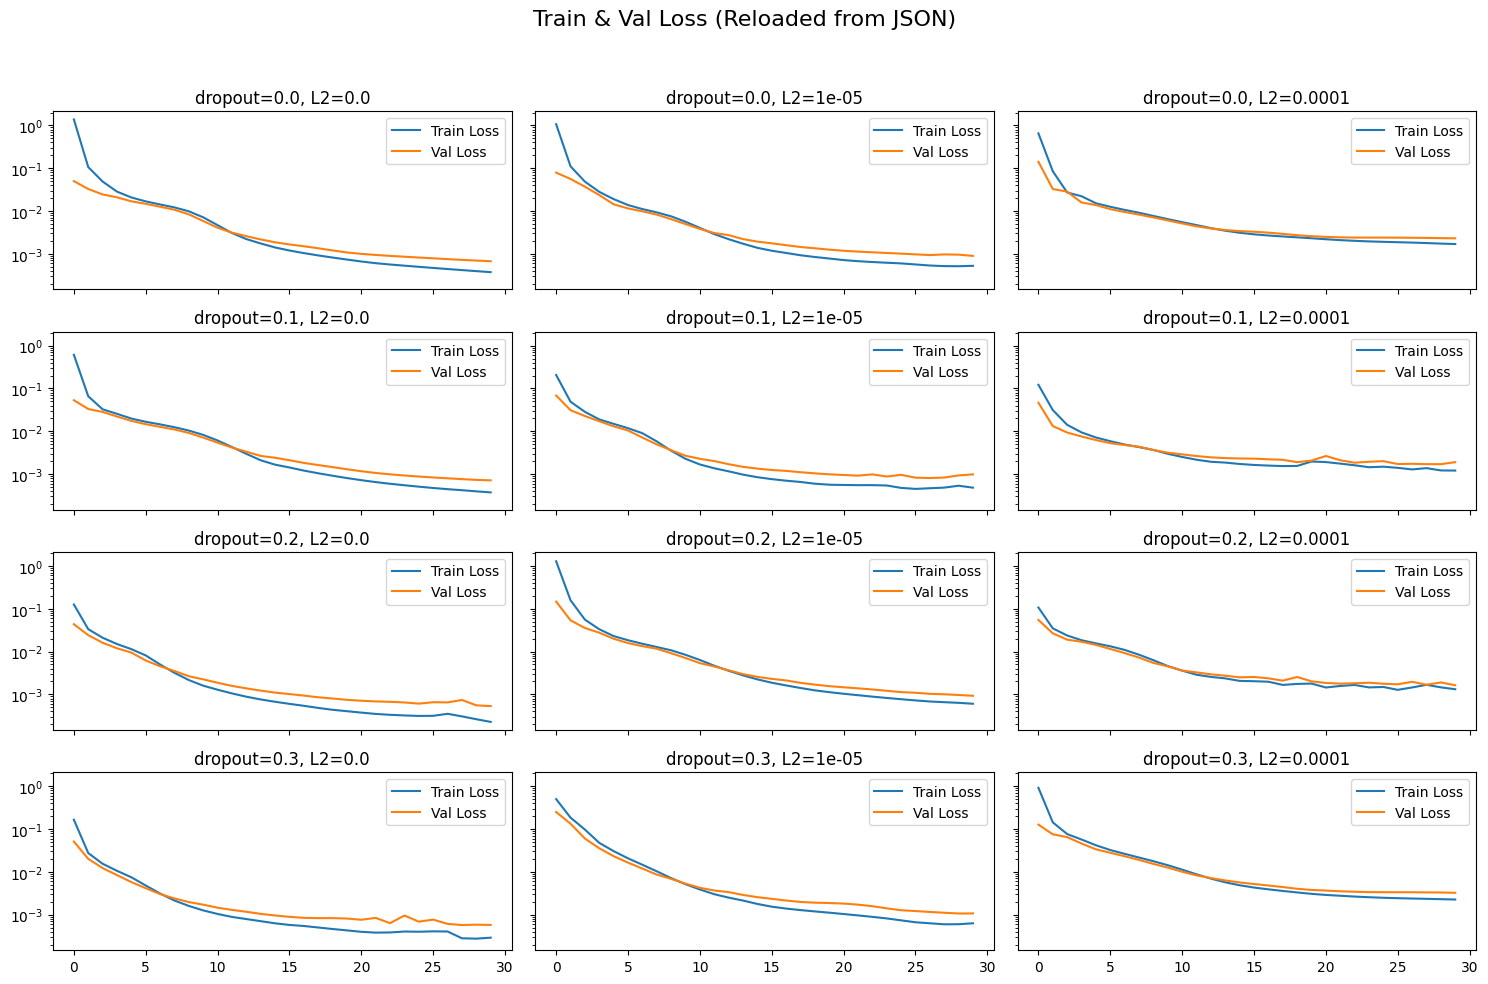

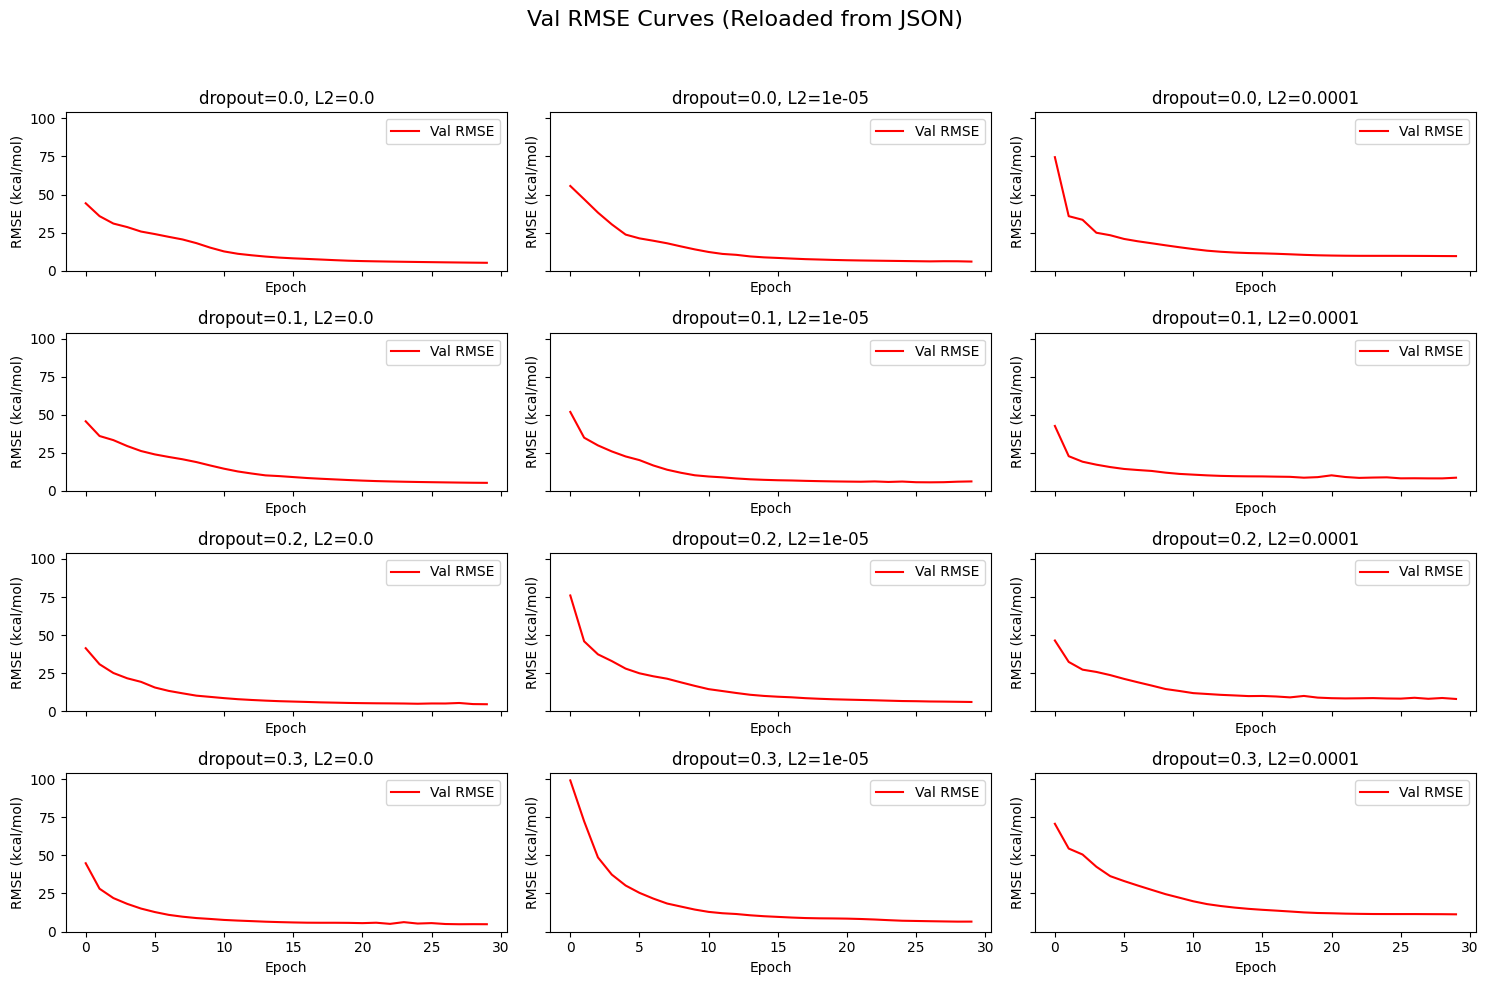

In [20]:
num_rows = len(df_loaded['dropout'].unique())
num_cols = len(df_loaded['l2'].unique())

fig_loss, axes_loss = plt.subplots(num_rows, num_cols, figsize=(15, 10), sharex=True, sharey=True)
fig_rmse, axes_rmse = plt.subplots(num_rows, num_cols, figsize=(15, 10), sharex=True, sharey=True)

dropout_list = sorted(df_loaded['dropout'].unique())
l2_list = sorted(df_loaded['l2'].unique())

for i, dropout in enumerate(dropout_list):
    for j, l2 in enumerate(l2_list):
        print(f"\nRetraining model: dropout={dropout}, L2={l2}")
        model = build_model(dropout, l2, device)
        trainer = ANITrainer(model, epoch=30, l2=l2)
        train_losses, val_losses, val_rmses = trainer.train(
            train_subset, val_subset, early_stop=True, draw_curve=False
        )

        # Plot Loss
        ax_loss = axes_loss[i][j]
        ax_loss.plot(train_losses, label="Train Loss")
        ax_loss.plot(val_losses, label="Val Loss")
        ax_loss.set_yscale("log")
        ax_loss.set_title(f"dropout={dropout}, L2={l2}")
        ax_loss.legend()

        # Plot RMSE
        ax_rmse = axes_rmse[i][j]
        ax_rmse.plot(val_rmses, color='red', label="Val RMSE")
        ax_rmse.set_title(f"dropout={dropout}, L2={l2}")
        ax_rmse.set_ylabel("RMSE (kcal/mol)")
        ax_rmse.set_xlabel("Epoch")
        ax_rmse.legend()

# Finalize layout
fig_loss.suptitle("Train & Val Loss (Reloaded from JSON)", fontsize=16)
fig_rmse.suptitle("Val RMSE Curves (Reloaded from JSON)", fontsize=16)
fig_loss.tight_layout(rect=[0, 0, 1, 0.95])
fig_rmse.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [34]:
from sklearn.model_selection import KFold
import numpy as np
import torch

k = 5
dropout = 0.3
l2 = 0.0
num_epochs = 30
batch_size = 512

# Convert TransformableIterable to a list of samples for indexing
indexed_dataset = list(get_data_subset(train_data, 'large'))

kf = KFold(n_splits=k, shuffle=True, random_state=42)
rmse_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(indexed_dataset)):
    print(f"\n--- Fold {fold + 1} ---")

    # Get the samples for each fold
    train_samples = [indexed_dataset[i] for i in train_idx]
    val_samples = [indexed_dataset[i] for i in val_idx]

    # Convert them back to TorchANI-compatible datasets
    train_subset = torchani.data.TransformableIterable(train_samples)
    val_subset = torchani.data.TransformableIterable(val_samples)

    model = build_model(dropout=dropout, l2=l2, device=device)

    trainer = ANITrainer(model, epoch=num_epochs, l2=l2, batch_size=batch_size)
    _, _, val_rmses = trainer.train(train_subset, val_subset, early_stop=True, draw_curve=False)

    final_rmse = val_rmses[-1]
    rmse_scores.append(final_rmse)
    print(f"Final RMSE for fold {fold + 1}: {final_rmse:.4f} kcal/mol")

mean_rmse = np.mean(rmse_scores)
std_rmse = np.std(rmse_scores)
print(f"\nAverage RMSE over {k} folds: {mean_rmse:.4f} ± {std_rmse:.4f} kcal/mol")



--- Fold 1 ---


Epochs:   3%|█▏                                  | 1/30 [00:11<05:35, 11.58s/it]

Epoch 1 - Train Loss: 2.3360, Val Loss: 0.0219, RMSE: 32.92 kcal/mol


Epochs:   7%|██▍                                 | 2/30 [00:21<04:51, 10.42s/it]

Epoch 2 - Train Loss: 0.0678, Val Loss: 0.0130, RMSE: 25.41 kcal/mol


Epochs:  10%|███▌                                | 3/30 [00:29<04:14,  9.44s/it]

Epoch 3 - Train Loss: 0.0417, Val Loss: 0.0084, RMSE: 20.39 kcal/mol


Epochs:  13%|████▊                               | 4/30 [00:39<04:15,  9.84s/it]

Epoch 4 - Train Loss: 0.0257, Val Loss: 0.0047, RMSE: 15.29 kcal/mol


Epochs:  17%|██████                              | 5/30 [00:54<04:45, 11.43s/it]

Epoch 5 - Train Loss: 0.0152, Val Loss: 0.0029, RMSE: 11.97 kcal/mol


Epochs:  20%|███████▏                            | 6/30 [01:08<04:58, 12.43s/it]

Epoch 6 - Train Loss: 0.0098, Val Loss: 0.0017, RMSE: 9.13 kcal/mol


Epochs:  23%|████████▍                           | 7/30 [01:17<04:23, 11.45s/it]

Epoch 7 - Train Loss: 0.0059, Val Loss: 0.0012, RMSE: 7.74 kcal/mol


Epochs:  27%|█████████▌                          | 8/30 [01:24<03:34,  9.75s/it]

Epoch 8 - Train Loss: 0.0042, Val Loss: 0.0010, RMSE: 6.92 kcal/mol


Epochs:  30%|██████████▊                         | 9/30 [01:30<03:01,  8.66s/it]

Epoch 9 - Train Loss: 0.0033, Val Loss: 0.0008, RMSE: 6.28 kcal/mol


Epochs:  33%|███████████▋                       | 10/30 [01:37<02:41,  8.05s/it]

Epoch 10 - Train Loss: 0.0026, Val Loss: 0.0007, RMSE: 5.84 kcal/mol


Epochs:  37%|████████████▊                      | 11/30 [01:43<02:23,  7.55s/it]

Epoch 11 - Train Loss: 0.0022, Val Loss: 0.0006, RMSE: 5.53 kcal/mol


Epochs:  40%|██████████████                     | 12/30 [01:50<02:13,  7.42s/it]

Epoch 12 - Train Loss: 0.0019, Val Loss: 0.0006, RMSE: 5.27 kcal/mol


Epochs:  43%|███████████████▏                   | 13/30 [01:57<02:01,  7.16s/it]

Epoch 13 - Train Loss: 0.0017, Val Loss: 0.0005, RMSE: 5.06 kcal/mol


Epochs:  47%|████████████████▎                  | 14/30 [02:03<01:50,  6.94s/it]

Epoch 14 - Train Loss: 0.0015, Val Loss: 0.0005, RMSE: 4.89 kcal/mol


Epochs:  50%|█████████████████▌                 | 15/30 [02:09<01:40,  6.69s/it]

Epoch 15 - Train Loss: 0.0014, Val Loss: 0.0005, RMSE: 4.74 kcal/mol


Epochs:  53%|██████████████████▋                | 16/30 [02:16<01:32,  6.60s/it]

Epoch 16 - Train Loss: 0.0013, Val Loss: 0.0004, RMSE: 4.60 kcal/mol


Epochs:  57%|███████████████████▊               | 17/30 [02:22<01:23,  6.46s/it]

Epoch 17 - Train Loss: 0.0012, Val Loss: 0.0004, RMSE: 4.48 kcal/mol


Epochs:  60%|█████████████████████              | 18/30 [02:28<01:15,  6.31s/it]

Epoch 18 - Train Loss: 0.0011, Val Loss: 0.0004, RMSE: 4.38 kcal/mol


Epochs:  63%|██████████████████████▏            | 19/30 [02:34<01:08,  6.20s/it]

Epoch 19 - Train Loss: 0.0010, Val Loss: 0.0004, RMSE: 4.32 kcal/mol


Epochs:  67%|███████████████████████▎           | 20/30 [02:40<01:01,  6.20s/it]

Epoch 20 - Train Loss: 0.0009, Val Loss: 0.0004, RMSE: 4.25 kcal/mol


Epochs:  70%|████████████████████████▌          | 21/30 [02:47<00:57,  6.37s/it]

Epoch 21 - Train Loss: 0.0009, Val Loss: 0.0003, RMSE: 4.16 kcal/mol


Epochs:  73%|█████████████████████████▋         | 22/30 [02:53<00:50,  6.36s/it]

Epoch 22 - Train Loss: 0.0008, Val Loss: 0.0003, RMSE: 4.03 kcal/mol


Epochs:  77%|██████████████████████████▊        | 23/30 [02:59<00:44,  6.35s/it]

Epoch 23 - Train Loss: 0.0008, Val Loss: 0.0003, RMSE: 3.93 kcal/mol


Epochs:  80%|████████████████████████████       | 24/30 [03:05<00:37,  6.32s/it]

Epoch 24 - Train Loss: 0.0007, Val Loss: 0.0003, RMSE: 3.83 kcal/mol


Epochs:  83%|█████████████████████████████▏     | 25/30 [03:12<00:31,  6.40s/it]

Epoch 25 - Train Loss: 0.0007, Val Loss: 0.0003, RMSE: 3.76 kcal/mol


Epochs:  87%|██████████████████████████████▎    | 26/30 [03:19<00:25,  6.45s/it]

Epoch 26 - Train Loss: 0.0007, Val Loss: 0.0003, RMSE: 3.68 kcal/mol


Epochs:  90%|███████████████████████████████▌   | 27/30 [03:25<00:19,  6.53s/it]

Epoch 27 - Train Loss: 0.0006, Val Loss: 0.0003, RMSE: 3.61 kcal/mol


Epochs:  93%|████████████████████████████████▋  | 28/30 [03:32<00:13,  6.54s/it]

Epoch 28 - Train Loss: 0.0006, Val Loss: 0.0002, RMSE: 3.53 kcal/mol


Epochs:  97%|█████████████████████████████████▊ | 29/30 [03:38<00:06,  6.36s/it]

Epoch 29 - Train Loss: 0.0006, Val Loss: 0.0002, RMSE: 3.46 kcal/mol


Epochs: 100%|███████████████████████████████████| 30/30 [03:44<00:00,  7.49s/it]

Epoch 30 - Train Loss: 0.0006, Val Loss: 0.0002, RMSE: 3.39 kcal/mol
Final RMSE for fold 1: 3.3935 kcal/mol

--- Fold 2 ---



Epochs:   3%|█▏                                  | 1/30 [00:10<04:53, 10.13s/it]

Epoch 1 - Train Loss: 1.6018, Val Loss: 0.0178, RMSE: 29.65 kcal/mol


Epochs:   7%|██▍                                 | 2/30 [00:16<03:42,  7.95s/it]

Epoch 2 - Train Loss: 0.0571, Val Loss: 0.0121, RMSE: 24.51 kcal/mol


Epochs:  10%|███▌                                | 3/30 [00:22<03:08,  6.98s/it]

Epoch 3 - Train Loss: 0.0362, Val Loss: 0.0079, RMSE: 19.76 kcal/mol


Epochs:  13%|████▊                               | 4/30 [00:28<02:50,  6.55s/it]

Epoch 4 - Train Loss: 0.0211, Val Loss: 0.0045, RMSE: 14.91 kcal/mol


Epochs:  17%|██████                              | 5/30 [00:35<02:51,  6.87s/it]

Epoch 5 - Train Loss: 0.0116, Val Loss: 0.0026, RMSE: 11.29 kcal/mol


Epochs:  20%|███████▏                            | 6/30 [00:44<03:04,  7.69s/it]

Epoch 6 - Train Loss: 0.0063, Val Loss: 0.0015, RMSE: 8.61 kcal/mol


Epochs:  23%|████████▍                           | 7/30 [00:52<02:54,  7.61s/it]

Epoch 7 - Train Loss: 0.0039, Val Loss: 0.0010, RMSE: 7.17 kcal/mol


Epochs:  27%|█████████▌                          | 8/30 [01:04<03:19,  9.06s/it]

Epoch 8 - Train Loss: 0.0028, Val Loss: 0.0008, RMSE: 6.28 kcal/mol


Epochs:  30%|██████████▊                         | 9/30 [01:13<03:07,  8.93s/it]

Epoch 9 - Train Loss: 0.0023, Val Loss: 0.0007, RMSE: 5.69 kcal/mol


Epochs:  33%|███████████▋                       | 10/30 [01:22<03:03,  9.17s/it]

Epoch 10 - Train Loss: 0.0019, Val Loss: 0.0006, RMSE: 5.32 kcal/mol


Epochs:  37%|████████████▊                      | 11/30 [01:30<02:47,  8.79s/it]

Epoch 11 - Train Loss: 0.0017, Val Loss: 0.0005, RMSE: 5.07 kcal/mol


Epochs:  40%|██████████████                     | 12/30 [01:37<02:23,  8.00s/it]

Epoch 12 - Train Loss: 0.0016, Val Loss: 0.0005, RMSE: 4.85 kcal/mol


Epochs:  43%|███████████████▏                   | 13/30 [01:43<02:08,  7.59s/it]

Epoch 13 - Train Loss: 0.0014, Val Loss: 0.0004, RMSE: 4.66 kcal/mol


Epochs:  47%|████████████████▎                  | 14/30 [01:50<01:56,  7.30s/it]

Epoch 14 - Train Loss: 0.0013, Val Loss: 0.0004, RMSE: 4.46 kcal/mol


Epochs:  50%|█████████████████▌                 | 15/30 [01:58<01:55,  7.69s/it]

Epoch 15 - Train Loss: 0.0012, Val Loss: 0.0004, RMSE: 4.31 kcal/mol


Epochs:  53%|██████████████████▋                | 16/30 [02:05<01:44,  7.47s/it]

Epoch 16 - Train Loss: 0.0011, Val Loss: 0.0004, RMSE: 4.17 kcal/mol


Epochs:  57%|███████████████████▊               | 17/30 [02:12<01:32,  7.10s/it]

Epoch 17 - Train Loss: 0.0010, Val Loss: 0.0003, RMSE: 3.99 kcal/mol


Epochs:  60%|█████████████████████              | 18/30 [02:18<01:21,  6.80s/it]

Epoch 18 - Train Loss: 0.0009, Val Loss: 0.0003, RMSE: 3.78 kcal/mol


Epochs:  63%|██████████████████████▏            | 19/30 [02:27<01:23,  7.58s/it]

Epoch 19 - Train Loss: 0.0008, Val Loss: 0.0003, RMSE: 3.61 kcal/mol


Epochs:  67%|███████████████████████▎           | 20/30 [02:34<01:14,  7.50s/it]

Epoch 20 - Train Loss: 0.0008, Val Loss: 0.0002, RMSE: 3.51 kcal/mol


Epochs:  70%|████████████████████████▌          | 21/30 [02:41<01:04,  7.20s/it]

Epoch 21 - Train Loss: 0.0007, Val Loss: 0.0002, RMSE: 3.42 kcal/mol


Epochs:  73%|█████████████████████████▋         | 22/30 [02:47<00:55,  6.98s/it]

Epoch 22 - Train Loss: 0.0007, Val Loss: 0.0002, RMSE: 3.35 kcal/mol


Epochs:  77%|██████████████████████████▊        | 23/30 [02:55<00:49,  7.12s/it]

Epoch 23 - Train Loss: 0.0006, Val Loss: 0.0002, RMSE: 3.29 kcal/mol


Epochs:  80%|████████████████████████████       | 24/30 [03:03<00:43,  7.32s/it]

Epoch 24 - Train Loss: 0.0006, Val Loss: 0.0002, RMSE: 3.27 kcal/mol


Epochs:  83%|█████████████████████████████▏     | 25/30 [03:09<00:34,  6.95s/it]

Epoch 25 - Train Loss: 0.0006, Val Loss: 0.0002, RMSE: 3.24 kcal/mol


Epochs:  87%|██████████████████████████████▎    | 26/30 [03:15<00:26,  6.65s/it]

Epoch 26 - Train Loss: 0.0006, Val Loss: 0.0002, RMSE: 3.21 kcal/mol


Epochs:  90%|███████████████████████████████▌   | 27/30 [03:21<00:19,  6.53s/it]

Epoch 27 - Train Loss: 0.0006, Val Loss: 0.0002, RMSE: 3.20 kcal/mol


Epochs:  93%|████████████████████████████████▋  | 28/30 [03:27<00:12,  6.45s/it]

Epoch 28 - Train Loss: 0.0005, Val Loss: 0.0002, RMSE: 3.15 kcal/mol


Epochs:  97%|█████████████████████████████████▊ | 29/30 [03:34<00:06,  6.46s/it]

Epoch 29 - Train Loss: 0.0005, Val Loss: 0.0002, RMSE: 3.10 kcal/mol


Epochs: 100%|███████████████████████████████████| 30/30 [03:40<00:00,  7.34s/it]

Epoch 30 - Train Loss: 0.0005, Val Loss: 0.0002, RMSE: 3.05 kcal/mol
Final RMSE for fold 2: 3.0455 kcal/mol

--- Fold 3 ---



Epochs:   3%|█▏                                  | 1/30 [00:09<04:24,  9.12s/it]

Epoch 1 - Train Loss: 0.4296, Val Loss: 0.0150, RMSE: 27.20 kcal/mol


Epochs:   7%|██▍                                 | 2/30 [00:15<03:22,  7.24s/it]

Epoch 2 - Train Loss: 0.0462, Val Loss: 0.0081, RMSE: 19.94 kcal/mol


Epochs:  10%|███▌                                | 3/30 [00:21<03:02,  6.77s/it]

Epoch 3 - Train Loss: 0.0231, Val Loss: 0.0033, RMSE: 12.70 kcal/mol


Epochs:  13%|████▊                               | 4/30 [00:27<02:55,  6.75s/it]

Epoch 4 - Train Loss: 0.0104, Val Loss: 0.0018, RMSE: 9.54 kcal/mol


Epochs:  17%|██████                              | 5/30 [00:34<02:43,  6.52s/it]

Epoch 5 - Train Loss: 0.0063, Val Loss: 0.0011, RMSE: 7.33 kcal/mol


Epochs:  20%|███████▏                            | 6/30 [00:40<02:34,  6.42s/it]

Epoch 6 - Train Loss: 0.0040, Val Loss: 0.0008, RMSE: 6.42 kcal/mol


Epochs:  23%|████████▍                           | 7/30 [00:46<02:25,  6.31s/it]

Epoch 7 - Train Loss: 0.0030, Val Loss: 0.0006, RMSE: 5.53 kcal/mol


Epochs:  27%|█████████▌                          | 8/30 [00:52<02:19,  6.36s/it]

Epoch 8 - Train Loss: 0.0023, Val Loss: 0.0006, RMSE: 5.33 kcal/mol


Epochs:  30%|██████████▊                         | 9/30 [00:59<02:12,  6.29s/it]

Epoch 9 - Train Loss: 0.0020, Val Loss: 0.0006, RMSE: 5.32 kcal/mol


Epochs:  33%|███████████▋                       | 10/30 [01:04<02:03,  6.16s/it]

Epoch 10 - Train Loss: 0.0017, Val Loss: 0.0005, RMSE: 5.07 kcal/mol


Epochs:  37%|████████████▊                      | 11/30 [01:11<01:57,  6.17s/it]

Epoch 11 - Train Loss: 0.0015, Val Loss: 0.0005, RMSE: 4.72 kcal/mol


Epochs:  40%|██████████████                     | 12/30 [01:17<01:54,  6.35s/it]

Epoch 12 - Train Loss: 0.0013, Val Loss: 0.0004, RMSE: 4.57 kcal/mol


Epochs:  43%|███████████████▏                   | 13/30 [01:25<01:54,  6.73s/it]

Epoch 13 - Train Loss: 0.0012, Val Loss: 0.0004, RMSE: 4.49 kcal/mol


Epochs:  47%|████████████████▎                  | 14/30 [01:33<01:52,  7.06s/it]

Epoch 14 - Train Loss: 0.0011, Val Loss: 0.0004, RMSE: 4.49 kcal/mol


Epochs:  50%|█████████████████▌                 | 15/30 [01:40<01:48,  7.25s/it]

Epoch 15 - Train Loss: 0.0010, Val Loss: 0.0004, RMSE: 4.52 kcal/mol


Epochs:  53%|██████████████████▋                | 16/30 [01:49<01:45,  7.52s/it]

Epoch 16 - Train Loss: 0.0010, Val Loss: 0.0004, RMSE: 4.52 kcal/mol


Epochs:  57%|███████████████████▊               | 17/30 [01:56<01:36,  7.40s/it]

Epoch 17 - Train Loss: 0.0009, Val Loss: 0.0004, RMSE: 4.50 kcal/mol


Epochs:  60%|█████████████████████              | 18/30 [02:04<01:32,  7.69s/it]

Epoch 18 - Train Loss: 0.0008, Val Loss: 0.0004, RMSE: 4.48 kcal/mol


Epochs:  63%|██████████████████████▏            | 19/30 [02:11<01:23,  7.56s/it]

Epoch 19 - Train Loss: 0.0008, Val Loss: 0.0004, RMSE: 4.44 kcal/mol


Epochs:  67%|███████████████████████▎           | 20/30 [02:19<01:15,  7.59s/it]

Epoch 20 - Train Loss: 0.0007, Val Loss: 0.0004, RMSE: 4.38 kcal/mol


Epochs:  70%|████████████████████████▌          | 21/30 [02:27<01:08,  7.66s/it]

Epoch 21 - Train Loss: 0.0008, Val Loss: 0.0004, RMSE: 4.36 kcal/mol


Epochs:  73%|█████████████████████████▋         | 22/30 [02:35<01:02,  7.78s/it]

Epoch 22 - Train Loss: 0.0006, Val Loss: 0.0004, RMSE: 4.33 kcal/mol


Epochs:  77%|██████████████████████████▊        | 23/30 [02:42<00:52,  7.54s/it]

Epoch 23 - Train Loss: 0.0008, Val Loss: 0.0004, RMSE: 4.37 kcal/mol


Epochs:  80%|████████████████████████████       | 24/30 [02:50<00:46,  7.73s/it]

Epoch 24 - Train Loss: 0.0007, Val Loss: 0.0004, RMSE: 4.43 kcal/mol


Epochs:  83%|█████████████████████████████▏     | 25/30 [02:57<00:38,  7.64s/it]

Epoch 25 - Train Loss: 0.0007, Val Loss: 0.0005, RMSE: 5.07 kcal/mol


Epochs:  87%|██████████████████████████████▎    | 26/30 [03:04<00:29,  7.40s/it]

Epoch 26 - Train Loss: 0.0007, Val Loss: 0.0004, RMSE: 4.38 kcal/mol


Epochs:  90%|███████████████████████████████▌   | 27/30 [03:11<00:21,  7.30s/it]

Epoch 27 - Train Loss: 0.0006, Val Loss: 0.0004, RMSE: 4.19 kcal/mol


Epochs:  93%|████████████████████████████████▋  | 28/30 [03:19<00:14,  7.32s/it]

Epoch 28 - Train Loss: 0.0005, Val Loss: 0.0004, RMSE: 4.29 kcal/mol


Epochs:  97%|█████████████████████████████████▊ | 29/30 [03:26<00:07,  7.43s/it]

Epoch 29 - Train Loss: 0.0005, Val Loss: 0.0004, RMSE: 4.20 kcal/mol


Epochs: 100%|███████████████████████████████████| 30/30 [03:34<00:00,  7.15s/it]

Epoch 30 - Train Loss: 0.0006, Val Loss: 0.0004, RMSE: 4.33 kcal/mol
Final RMSE for fold 3: 4.3349 kcal/mol

--- Fold 4 ---



Epochs:   3%|█▏                                  | 1/30 [00:11<05:43, 11.85s/it]

Epoch 1 - Train Loss: 2.1076, Val Loss: 0.0444, RMSE: 46.70 kcal/mol


Epochs:   7%|██▍                                 | 2/30 [00:19<04:18,  9.23s/it]

Epoch 2 - Train Loss: 0.1429, Val Loss: 0.0214, RMSE: 32.43 kcal/mol


Epochs:  10%|███▌                                | 3/30 [00:25<03:31,  7.82s/it]

Epoch 3 - Train Loss: 0.0663, Val Loss: 0.0096, RMSE: 21.68 kcal/mol


Epochs:  13%|████▊                               | 4/30 [00:32<03:12,  7.41s/it]

Epoch 4 - Train Loss: 0.0254, Val Loss: 0.0032, RMSE: 12.52 kcal/mol


Epochs:  17%|██████                              | 5/30 [00:40<03:13,  7.74s/it]

Epoch 5 - Train Loss: 0.0115, Val Loss: 0.0021, RMSE: 10.01 kcal/mol


Epochs:  20%|███████▏                            | 6/30 [00:49<03:13,  8.07s/it]

Epoch 6 - Train Loss: 0.0077, Val Loss: 0.0015, RMSE: 8.51 kcal/mol


Epochs:  23%|████████▍                           | 7/30 [00:55<02:52,  7.48s/it]

Epoch 7 - Train Loss: 0.0057, Val Loss: 0.0011, RMSE: 7.41 kcal/mol


Epochs:  27%|█████████▌                          | 8/30 [01:03<02:47,  7.60s/it]

Epoch 8 - Train Loss: 0.0043, Val Loss: 0.0009, RMSE: 6.58 kcal/mol


Epochs:  30%|██████████▊                         | 9/30 [01:10<02:34,  7.38s/it]

Epoch 9 - Train Loss: 0.0033, Val Loss: 0.0007, RMSE: 5.98 kcal/mol


Epochs:  33%|███████████▋                       | 10/30 [01:17<02:28,  7.43s/it]

Epoch 10 - Train Loss: 0.0027, Val Loss: 0.0006, RMSE: 5.44 kcal/mol


Epochs:  37%|████████████▊                      | 11/30 [01:24<02:15,  7.14s/it]

Epoch 11 - Train Loss: 0.0022, Val Loss: 0.0005, RMSE: 5.09 kcal/mol


Epochs:  40%|██████████████                     | 12/30 [01:30<02:04,  6.91s/it]

Epoch 12 - Train Loss: 0.0019, Val Loss: 0.0005, RMSE: 4.86 kcal/mol


Epochs:  43%|███████████████▏                   | 13/30 [01:36<01:52,  6.61s/it]

Epoch 13 - Train Loss: 0.0017, Val Loss: 0.0005, RMSE: 4.71 kcal/mol


Epochs:  47%|████████████████▎                  | 14/30 [01:42<01:43,  6.46s/it]

Epoch 14 - Train Loss: 0.0015, Val Loss: 0.0004, RMSE: 4.56 kcal/mol


Epochs:  50%|█████████████████▌                 | 15/30 [01:48<01:33,  6.26s/it]

Epoch 15 - Train Loss: 0.0014, Val Loss: 0.0004, RMSE: 4.37 kcal/mol


Epochs:  53%|██████████████████▋                | 16/30 [01:54<01:25,  6.11s/it]

Epoch 16 - Train Loss: 0.0013, Val Loss: 0.0004, RMSE: 4.14 kcal/mol


Epochs:  57%|███████████████████▊               | 17/30 [02:00<01:18,  6.03s/it]

Epoch 17 - Train Loss: 0.0011, Val Loss: 0.0003, RMSE: 3.91 kcal/mol


Epochs:  60%|█████████████████████              | 18/30 [02:06<01:15,  6.28s/it]

Epoch 18 - Train Loss: 0.0011, Val Loss: 0.0003, RMSE: 3.78 kcal/mol


Epochs:  63%|██████████████████████▏            | 19/30 [02:13<01:09,  6.33s/it]

Epoch 19 - Train Loss: 0.0010, Val Loss: 0.0003, RMSE: 3.70 kcal/mol


Epochs:  67%|███████████████████████▎           | 20/30 [02:20<01:04,  6.49s/it]

Epoch 20 - Train Loss: 0.0009, Val Loss: 0.0003, RMSE: 3.61 kcal/mol


Epochs:  70%|████████████████████████▌          | 21/30 [02:28<01:01,  6.88s/it]

Epoch 21 - Train Loss: 0.0009, Val Loss: 0.0003, RMSE: 3.54 kcal/mol


Epochs:  73%|█████████████████████████▋         | 22/30 [02:35<00:56,  7.02s/it]

Epoch 22 - Train Loss: 0.0009, Val Loss: 0.0002, RMSE: 3.45 kcal/mol


Epochs:  77%|██████████████████████████▊        | 23/30 [02:42<00:49,  7.05s/it]

Epoch 23 - Train Loss: 0.0008, Val Loss: 0.0002, RMSE: 3.38 kcal/mol


Epochs:  80%|████████████████████████████       | 24/30 [02:51<00:46,  7.68s/it]

Epoch 24 - Train Loss: 0.0008, Val Loss: 0.0002, RMSE: 3.32 kcal/mol


Epochs:  83%|█████████████████████████████▏     | 25/30 [02:59<00:38,  7.79s/it]

Epoch 25 - Train Loss: 0.0008, Val Loss: 0.0002, RMSE: 3.25 kcal/mol


Epochs:  87%|██████████████████████████████▎    | 26/30 [03:07<00:31,  7.92s/it]

Epoch 26 - Train Loss: 0.0008, Val Loss: 0.0002, RMSE: 3.18 kcal/mol


Epochs:  90%|███████████████████████████████▌   | 27/30 [03:16<00:24,  8.23s/it]

Epoch 27 - Train Loss: 0.0007, Val Loss: 0.0002, RMSE: 3.12 kcal/mol


Epochs:  93%|████████████████████████████████▋  | 28/30 [03:24<00:15,  7.98s/it]

Epoch 28 - Train Loss: 0.0007, Val Loss: 0.0002, RMSE: 3.08 kcal/mol


Epochs:  97%|█████████████████████████████████▊ | 29/30 [03:35<00:08,  8.98s/it]

Epoch 29 - Train Loss: 0.0007, Val Loss: 0.0002, RMSE: 3.05 kcal/mol


Epochs: 100%|███████████████████████████████████| 30/30 [03:47<00:00,  7.60s/it]

Epoch 30 - Train Loss: 0.0007, Val Loss: 0.0002, RMSE: 3.02 kcal/mol
Final RMSE for fold 4: 3.0220 kcal/mol

--- Fold 5 ---



Epochs:   3%|█▏                                  | 1/30 [00:14<07:09, 14.82s/it]

Epoch 1 - Train Loss: 2.3109, Val Loss: 0.0335, RMSE: 40.61 kcal/mol


Epochs:   7%|██▍                                 | 2/30 [00:27<06:14, 13.37s/it]

Epoch 2 - Train Loss: 0.1092, Val Loss: 0.0157, RMSE: 27.77 kcal/mol


Epochs:  10%|███▌                                | 3/30 [00:34<04:51, 10.81s/it]

Epoch 3 - Train Loss: 0.0461, Val Loss: 0.0073, RMSE: 18.89 kcal/mol


Epochs:  13%|████▊                               | 4/30 [00:45<04:36, 10.63s/it]

Epoch 4 - Train Loss: 0.0193, Val Loss: 0.0030, RMSE: 12.21 kcal/mol


Epochs:  17%|██████                              | 5/30 [00:54<04:12, 10.11s/it]

Epoch 5 - Train Loss: 0.0096, Val Loss: 0.0019, RMSE: 9.53 kcal/mol


Epochs:  20%|███████▏                            | 6/30 [01:12<05:09, 12.88s/it]

Epoch 6 - Train Loss: 0.0064, Val Loss: 0.0013, RMSE: 8.12 kcal/mol


Epochs:  23%|████████▍                           | 7/30 [01:25<04:53, 12.78s/it]

Epoch 7 - Train Loss: 0.0049, Val Loss: 0.0011, RMSE: 7.30 kcal/mol


Epochs:  27%|█████████▌                          | 8/30 [01:33<04:08, 11.32s/it]

Epoch 8 - Train Loss: 0.0040, Val Loss: 0.0009, RMSE: 6.77 kcal/mol


Epochs:  30%|██████████▊                         | 9/30 [01:40<03:29,  9.98s/it]

Epoch 9 - Train Loss: 0.0033, Val Loss: 0.0008, RMSE: 6.35 kcal/mol


Epochs:  33%|███████████▋                       | 10/30 [01:47<03:01,  9.06s/it]

Epoch 10 - Train Loss: 0.0029, Val Loss: 0.0007, RMSE: 5.97 kcal/mol


Epochs:  37%|████████████▊                      | 11/30 [01:54<02:41,  8.50s/it]

Epoch 11 - Train Loss: 0.0025, Val Loss: 0.0006, RMSE: 5.60 kcal/mol


Epochs:  40%|██████████████                     | 12/30 [02:01<02:23,  7.96s/it]

Epoch 12 - Train Loss: 0.0023, Val Loss: 0.0006, RMSE: 5.29 kcal/mol


Epochs:  43%|███████████████▏                   | 13/30 [02:08<02:08,  7.54s/it]

Epoch 13 - Train Loss: 0.0021, Val Loss: 0.0005, RMSE: 5.00 kcal/mol


Epochs:  47%|████████████████▎                  | 14/30 [02:19<02:17,  8.59s/it]

Epoch 14 - Train Loss: 0.0019, Val Loss: 0.0005, RMSE: 4.79 kcal/mol


Epochs:  50%|█████████████████▌                 | 15/30 [02:27<02:06,  8.45s/it]

Epoch 15 - Train Loss: 0.0017, Val Loss: 0.0004, RMSE: 4.61 kcal/mol


Epochs:  53%|██████████████████▋                | 16/30 [02:33<01:50,  7.89s/it]

Epoch 16 - Train Loss: 0.0016, Val Loss: 0.0004, RMSE: 4.47 kcal/mol


Epochs:  57%|███████████████████▊               | 17/30 [02:39<01:35,  7.31s/it]

Epoch 17 - Train Loss: 0.0015, Val Loss: 0.0004, RMSE: 4.33 kcal/mol


Epochs:  60%|█████████████████████              | 18/30 [02:45<01:22,  6.91s/it]

Epoch 18 - Train Loss: 0.0014, Val Loss: 0.0004, RMSE: 4.24 kcal/mol


Epochs:  63%|██████████████████████▏            | 19/30 [02:51<01:13,  6.65s/it]

Epoch 19 - Train Loss: 0.0013, Val Loss: 0.0003, RMSE: 4.10 kcal/mol


Epochs:  67%|███████████████████████▎           | 20/30 [02:57<01:04,  6.47s/it]

Epoch 20 - Train Loss: 0.0012, Val Loss: 0.0003, RMSE: 4.03 kcal/mol


Epochs:  70%|████████████████████████▌          | 21/30 [03:04<00:59,  6.62s/it]

Epoch 21 - Train Loss: 0.0012, Val Loss: 0.0003, RMSE: 3.91 kcal/mol


Epochs:  73%|█████████████████████████▋         | 22/30 [03:14<01:01,  7.66s/it]

Epoch 22 - Train Loss: 0.0011, Val Loss: 0.0003, RMSE: 3.84 kcal/mol


Epochs:  77%|██████████████████████████▊        | 23/30 [03:25<00:59,  8.57s/it]

Epoch 23 - Train Loss: 0.0010, Val Loss: 0.0003, RMSE: 3.75 kcal/mol


Epochs:  80%|████████████████████████████       | 24/30 [03:33<00:50,  8.50s/it]

Epoch 24 - Train Loss: 0.0010, Val Loss: 0.0003, RMSE: 3.68 kcal/mol


Epochs:  83%|█████████████████████████████▏     | 25/30 [03:40<00:38,  7.80s/it]

Epoch 25 - Train Loss: 0.0009, Val Loss: 0.0003, RMSE: 3.60 kcal/mol


Epochs:  87%|██████████████████████████████▎    | 26/30 [03:46<00:29,  7.32s/it]

Epoch 26 - Train Loss: 0.0009, Val Loss: 0.0003, RMSE: 3.54 kcal/mol


Epochs:  90%|███████████████████████████████▌   | 27/30 [03:53<00:21,  7.29s/it]

Epoch 27 - Train Loss: 0.0009, Val Loss: 0.0002, RMSE: 3.47 kcal/mol


Epochs:  93%|████████████████████████████████▋  | 28/30 [04:00<00:14,  7.21s/it]

Epoch 28 - Train Loss: 0.0008, Val Loss: 0.0002, RMSE: 3.43 kcal/mol


Epochs:  97%|█████████████████████████████████▊ | 29/30 [04:09<00:07,  7.59s/it]

Epoch 29 - Train Loss: 0.0008, Val Loss: 0.0002, RMSE: 3.39 kcal/mol


Epochs: 100%|███████████████████████████████████| 30/30 [04:16<00:00,  8.53s/it]

Epoch 30 - Train Loss: 0.0007, Val Loss: 0.0002, RMSE: 3.36 kcal/mol
Final RMSE for fold 5: 3.3601 kcal/mol

Average RMSE over 5 folds: 3.4312 ± 0.4773 kcal/mol
